In [174]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [88]:
import numpy as np
import pandas as pd
import math
import random
import re

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Import required for random matrix generation
import scipy.stats as stats
import scipy.sparse as sparse
from docplex.cp.utils_visu import display

from qiskit import *
from qiskit_optimization.applications import Maxcut, Tsp, GraphPartition

# QP specific imports
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo, LinearInequalityToPenalty

# QAOA and circuit cutting specific imports
from qiskit.circuit.library import QAOAAnsatz
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires

In [31]:
import random
import seaborn as sns

# Import required for random matrix generation
import scipy.stats as stats
import scipy.sparse as sparse
from docplex.cp.utils_visu import display

from qiskit import *


# QAOA and circuit cutting specific imports
from qiskit.circuit.library import QAOAAnsatz
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires

In [32]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import PauliList
from qiskit_aer.primitives import Estimator, Sampler
from qiskit.circuit import Parameter

from circuit_knitting.cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

from circuit_knitting.cutting.instructions import CutWire, Move
from circuit_knitting.cutting import cut_wires, expand_observables

In [33]:
import string
from collections import OrderedDict

from matplotlib import pylab as pl

from sklearn.cluster import SpectralClustering
from sklearn import metrics
import markov_clustering as mc

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering

In [34]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp 
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [35]:
labels = string.ascii_uppercase + string.ascii_lowercase   #string.ascii_letters#
labels

'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

In [36]:
greek_alphabet = {
    u'\u03B1': 'alpha',
    u'\u03B2': 'beta',
    u'\u03B3': 'gamma',
    u'\u03B4': 'delta',
    u'\u03B5': 'epsilon',
    u'\u03B6': 'zeta',
    u'\u03B7': 'eta',
    u'\u03B8': 'theta',
    u'\u03B9': 'iota',
    u'\u03BA': 'kappa',
    u'\u03BB': 'lamda',
    u'\u03BC': 'mu',
    u'\u03BD': 'nu',
    u'\u03BE': 'xi',
    u'\u03BF': 'omicron',
    u'\u03C0': 'pi',
    u'\u03C1': 'rho',
    u'\u03C3': 'sigma',
    u'\u03C4': 'tau',
    u'\u03C5': 'upsilon',
    u'\u03C6': 'phi',
    u'\u03C7': 'chi',
    u'\u03C8': 'psi',
    u'\u03C9': 'omega',
}
greek_alpha = [k for k in greek_alphabet.keys()]

In [37]:
labels = ''.join(k for k in greek_alphabet.keys()) + labels
labels

'αβγδεζηθικλμνξοπρστυφχψωABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

In [39]:
'''
Methods required to generate random ER graphs
'''
#Erdos Renyi graph
def generate_er_graph(n, p, random_seed):
    G = nx.erdos_renyi_graph(n,p,seed=random_seed)
    M = nx.adjacency_matrix(G).todense()
    return M, G

'''
Methods required to generate random sparse matrices
'''
def sprandsym(n, density,seed):
    np.random.seed((seed))
    rvs = stats.poisson(25, loc=10).rvs
    X = sparse.random(n, n, density=density, data_rvs=rvs)
    upper_X = sparse.triu(X) 
    result = upper_X + upper_X.T - sparse.diags(X.diagonal())
    return result

def binarize_sparse_matrix(sparse_matrix):
    # create a copy of the sparse matrix to keep the operation non-destructive
    sparse_copy = sparse_matrix.copy()
    #sparse_copy=sparse_copy-sparse.diags(sparse_copy.diagonal())
    # find the coordinates of non-zero elements
    non_zero_coords = sparse_copy.nonzero()
    # set those elements to 1
    sparse_copy[non_zero_coords] = 1
    return sparse_copy

def generate_graph_from_matrix(binarized_sparse_mat):
    G = nx.from_scipy_sparse_array(binarized_sparse_mat)
    return G


# create the quadratic program instance and define the variables
def create_qp_from_qmatrix(Q_matrix):
    max_keys = Q_matrix.shape[0]
    qp = QuadraticProgram('QUBO Matrix Optimization')
    x = qp.binary_var_list(name='x', keys=range(1, max_keys + 1))

    linear_vars = {qp.get_variable(i).name: Q_matrix[i, j]
                   for i in range(max_keys) for j in range(max_keys) if i == j}
    quadratic_vars = {(qp.get_variable(i).name, qp.get_variable(j).name): Q_matrix[i, j]
                      for i in range(max_keys) for j in range(max_keys) if i != j}

    qp.minimize(linear=linear_vars, quadratic=quadratic_vars)
    return qp
    #print(self.qp.prettyprint())


def create_qaoa_ansatz(qp):
    #self.create_qp_from_qmatrix()
    h_qubo, offset = qp.to_ising()
    #print(h_qubo)
    qaoa_ansatz = QAOAAnsatz(cost_operator=h_qubo, reps=1, )
    qaoa_ansatz.entanglement = 'linear'
    params = len(qaoa_ansatz.parameters)
    theta_range = np.linspace(0, np.pi, params)
    qaoa_qc = qaoa_ansatz.bind_parameters(theta_range)
    decomposed_qaoa_ansatz = qaoa_qc.decompose().decompose().decompose().decompose()
    return h_qubo, offset, decomposed_qaoa_ansatz


In [40]:
def get_subgraph_properties1(G):
    cnt=0
    subgraphs = (G.subgraph(c) for c in nx.connected_components(G))
    subgraph_prop = {}
    prop = []
    max_size = []
    max_subgraph_nodes = ''
    for s in subgraphs:
        #print(s.nodes())
        n = tuple(s.nodes())
        subgraph_prop[n] = nx.adjacency_matrix(s).todense()
        #print(s.size())
        #print(f'Subgraph {cnt}:: Num of Edges: {s.size()},  Nodes : {s.nodes()}  ')
        cnt+=1
        max_size.append(len(s.nodes()))
        if len(s.nodes)== np.max(max_size):
            max_subgraph_nodes = s.nodes()
        
        
    #print(max_subgraph_nodes)
    return cnt, np.max(max_size), subgraph_prop, max_subgraph_nodes



- Create a random sparse matrix
- Create a graph from the matrix
- Find the subgraphs and the nodes of each of the subgraph
- create the parition labels such that all nodes of a subgraph get the same partition label

- create the QP from the matrix
- Convert the QP to QUBO, then create the QAOA ansatz for this QUBO
- apply gate cutting to reduce the width of circuit with these partition labels

In [41]:
labels

'αβγδεζηθικλμνξοπρστυφχψωABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

In [43]:
'''
Methods for clustering 
'''

def bfs(q1, max_cluster_size):
    q1_nd = [q[0] for q in sorted(q1.degree, key=lambda x:x[1], reverse=True)]
            
    q_scidx = {}
    scidx_q = {}
    sc_idx = 0
    visited = []

    #for node in sorted(q1.nodes):
    for node in q1_nd:
        if node not in visited:
            scidx_q.setdefault(sc_idx, [])

            nodes_in_sc = set(list(sum(sorted(list(nx.bfs_tree(q1, source=node, depth_limit=1).edges())),())))
            #print(f'nodes_in_sc: {nodes_in_sc}')

            for k in nodes_in_sc:
                ## required only if using to find cut wire position*****
                q_scidx.setdefault(k,[]) #q_scidx
                q_scidx[k].append(sc_idx) #q_scidx
                ## ********

                #print(f'visited: {visited}')
                if (k not in visited) and (len(scidx_q[sc_idx])<max_cluster_size) :
                    scidx_q[sc_idx].append(k)
                    visited.append(k)
            sc_idx += 1

    qsc = OrderedDict(sorted(scidx_q.items()))
    cluster_qubit ={}
    bfs_cluster_labels = []

    for qsc_k, qsc_val in qsc.items():
        for qsc_i in qsc_val:
            cluster_qubit.setdefault(qsc_i,[])
            cluster_qubit[qsc_i].append(qsc_k)
    bfs_cluster_labels = [i for val in (OrderedDict(sorted(cluster_qubit.items()))).values() for i in val]
    return bfs_cluster_labels

def sc(data, n_clusters, key, max_cluster_size):
    sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
    sc.fit(data)
    #TODO: verify sub cluster size<max_cluster_size
    return sc.labels_

def kmeans(data, n_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=0)
    kmeans.fit(data)
    return kmeans.labels_
    
def kmeans_pca(data, n_clusters):
    pca = PCA(n_components=n_clusters).fit(data)
    kmeans_pca = KMeans(init=pca.components_, n_clusters=n_clusters, n_init=1)
    kmeans_pca.fit(data)
    return kmeans_pca.labels_

def kmeans_random(data, n_clusters):
    kmeans_rand = KMeans(init="random", n_clusters=n_clusters, n_init=4, random_state=0)
    kmeans_rand.fit(data)
    return kmeans_rand.labels_

def birch(data, n_clusters):
    brc = Birch(n_clusters=n_clusters)
    brc.fit(data)
    birch_labels = brc.predict(data)
    return birch_labels

def agglom(data, n_clusters):
    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(data)
    return clustering.labels_

         
def partitioning(max_cluster_size, qsubgraph_prop, clustering_method):
    cm_part_lbl = {}
    for cm in clustering_method:
        part_lbl = {}
        max_key_cnt = -1
   
        for i, key in enumerate(qsubgraph_prop.keys()):  
            print(f'Subgraph nodes : {key}')
            if len(key)>max_cluster_size:
                data = qsubgraph_prop[key]
                n_clusters = int(np.ceil(len(key)/max_cluster_size))
                q1=nx.from_numpy_array(data)
                
                #call diff clustering methods here
                if 'bfs' in cm:
                    clabels = bfs(q1, max_cluster_size)

                elif 'spectral_clustering' in cm:
                    clabels = sc(data, n_clusters, key, max_cluster_size)
                
                elif cm=='kmeans':
                    clabels = kmeans(data, n_clusters)
                
                elif cm=='kmeans_pca':
                    clabels = kmeans_pca(data, n_clusters)

                elif cm=='kmeans_random':
                    clabels = kmeans_random(data, n_clusters)
                
                elif 'birch' in cm:
                    clabels = birch(data, n_clusters)
                
                elif 'agglom' in cm:
                    clabels = agglom(data, n_clusters)



                #increment the sclbl with max_key_cnt so that the next sub-graphs labels are not repeated
                cluster_lbls = [lbl + max_key_cnt +1 for lbl in clabels]
                for j, k_ in enumerate(key):
                    part_lbl[k_] = labels[cluster_lbls[j]] 

                max_key_cnt = np.max(cluster_lbls) 

            else:
                max_key_cnt += 1
                for k in key:
                    part_lbl[k] = labels[max_key_cnt]
            
        cm_part_lbl[cm] = part_lbl
        #print(f'cm_part_lbl : {cm_part_lbl}')
    return cm_part_lbl


'''
Find the CKT sampling overhead given the circuit and its partitioning labels
'''
def ckt(qaoa_decomposed, part_lbl, observables):
    
    ordered_part_lbl = OrderedDict(sorted(part_lbl.items()))
    partition_labels = ''.join(ordered_part_lbl.values())
    print(f'\nPartition labels for CKT: {partition_labels}')
    
    partitioned_problem = partition_problem(circuit=qaoa_decomposed, 
                                            partition_labels=partition_labels, 
                                            observables=observables)
    bases = partitioned_problem.bases
    sampling_overhead = np.prod([basis.overhead for basis in bases])
    print(f"Sampling overhead: {sampling_overhead}")
    return partition_labels,sampling_overhead


In [44]:
def ckt_exp(mat_size, prob, random_seeds, max_cluster_sizes, matrix_type):
    
    cols = ['n', 'p', 'seed', 'max_cluster_size', 'qsubgraph_prop']
    
    df = pd.DataFrame(columns=cols)
    i = 0
    for n in mat_size:
        for p in (prob): 
            for seed in random_seeds:
                print(f'\n\nExperiment for size {n}, density {p}, seed {seed}')
                
                ## Create sparse matrix for a given size and density
                if 'random_sparse' in matrix_type:
                    M = sprandsym(n,p,seed)
                    M = binarize_sparse_matrix(M)
                    q=generate_graph_from_matrix(M)
                
                ## Get adjacency matrix for a random Erdos Renyi Graph 
                elif 'er_graph' in matrix_type:
                    M,q = generate_er_graph(n,p,seed)
                    
                qnum_sub_graphs, largest_subgraph_size, qsubgraph_prop, max_subgraph_nodes = get_subgraph_properties1(q)
               
                ## Convert the sparse matrix into QUBO
                qp = create_qp_from_qmatrix(M)
                qp2qubo = QuadraticProgramToQubo()
                qubo = qp2qubo.convert(qp)
                qubitOp, offset = qubo.to_ising()
                
                ## Generate QAOA ansatz for QUBO and assign its observables
                qaoa = QAOAAnsatz(cost_operator=qubitOp,reps=1)
                qaoa_decomposed = qaoa.decompose().decompose().decompose().decompose()
                qaoa_observable_pat = '[A-Z]+'
                observables = PauliList(re.findall(qaoa_observable_pat, str(qubitOp)))
                
                ## Clustering methods for qaoa ansatz partitioning
                clustering_methods = ['bfs','spectral_clustering','kmeans',
                                      'kmeans_pca','kmeans_random','birch','agglom']
                    

                ## Generate partition labels for the QAOA
                for max_cluster_size in max_cluster_sizes:
                    i += 1
                    cm_part_lbl = partitioning(max_cluster_size, qsubgraph_prop, clustering_methods)
                    
                    df.loc[i,'n'] = n
                    df.loc[i,'p'] = p
                    df.loc[i,'seed'] = seed
                    df.loc[i,'max_cluster_size'] = max_cluster_size
                    df.loc[i,'qsubgraph_prop'] = [qsubgraph_prop]
                    
                    for cm_ in clustering_methods:
                        sc_partlabel, sampling_overhead = ckt(qaoa_decomposed, cm_part_lbl[cm_], observables)
                        df.loc[i,cm_] = sampling_overhead
                    
    return df
  
    
    


In [196]:
def generate_rel_plot( df_grp, df_std, graph_type, plot_error ):
    
    x = df_grp['np']
    y = df_grp['SamplingOverhead']
    
    N = df_grp['n'].unique()
    
    cm = ['bfs','spectral_clustering','kmeans','kmeans_pca','kmeans_random','birch','agglom']

    colors = ['cyan', 'blue', 'red', 'green', 'blue', 'black', 'orange']
    linestyles = ['solid', 'dashed', 'dotted', 'dotted',':', '-', '-.']


    #vsize = df_grp['Graph Size'].apply(lambda x:math.log10(x)).unique()
    colors = ['mediumseagreen','xkcd:sky blue','tab:purple',
              'tab:cyan','cyan', 'blue', 'red', 'green', 'blue', 'black', 'orange']
    
    facet_kws={'sharey': False, 'sharex': False}
    plt.tight_layout()
    g = sns.relplot(
        data=df_grp, kind=graph_type,
        col='PartitionType', 
        x='np', y='SamplingOverhead', palette=colors, hue='PartitionType',
        col_wrap=2, facet_kws=facet_kws,
        size='n', size_order=N,
        
        )
    
    ylabel = 'sampling overhead'
    xlabel = 'n*p'
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    g.set(xscale='log')
    g.set(yscale='log')

    axes = g.axes
    for j,ax in enumerate(axes):
        #y = df_grp[cm]
        #sns.scatterplot(x=x, y=y, color=colors[j], linestyle=linestyles[j] , label=cm)#, hue_order=hue_order ,
    
        if plot_error:
            #yerr = df_std[df_std['Graph Size']==N[j]]['Largest Component Size']
            #xe = df_grp[df_grp['Graph Size']==N[j]]['np']
            #ye = df_grp[df_grp['Graph Size']==N[j]]['Largest Component Size']
            #ax.errorbar(x=x, y=y, yerr=yerr, linestyle='None',capsize=3, color=colors[j])
            ygerr = df_std['SamplingOverhead']#.apply(lambda x1: np.log(x1)).values
            
            ax.errorbar(x=x, y=y, yerr=ygerr, linestyle='None',capsize=3, color=colors[i])

    
    #sns.move_legend(g, "upper left", bbox_to_anchor=(.10, .95))


In [45]:
matrix_sizes =  [15,20]#,50]#,75,100]
matrix_densities = [0.05,0.06]#, 0.15]#[0.05,0.07]#,0.1,0.2,0.25,0.27] #[0.20,0.30,0.40,0.50,0.60,0.70]
num_of_experiments = 3
random_seeds = [random.randint(3000, 10000) for _ in range(num_of_experiments)]
max_cluster_sizes = [5]#,5,7]

df = ckt_exp(matrix_sizes, matrix_densities, random_seeds, max_cluster_sizes)



Experiment for size 15, density 0.05, seed 6591
Subgraph nodes : (0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 14)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (8,)
Subgraph nodes : (13,)
Subgraph nodes : (0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 14)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (8,)
Subgraph nodes : (13,)
Subgraph nodes : (0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 14)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (8,)
Subgraph nodes : (13,)
Subgraph nodes : (0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 14)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (8,)
Subgraph nodes : (13,)
Subgraph nodes : (0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 14)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (8,)
Subgraph nodes : (13,)
Subgraph nodes : (0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 14)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (8,)
Subgraph nodes : (13,)
Subgraph nodes : (0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 14)
Subgraph nodes : (2,)
Subgraph 

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Subgraph nodes : (0, 2, 6, 7, 9)
Subgraph nodes : (1,)
Subgraph nodes : (3,)
Subgraph nodes : (4, 14)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (0, 2, 6, 7, 9)
Subgraph nodes : (1,)
Subgraph nodes : (3,)
Subgraph nodes : (4, 14)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (0, 2, 6, 7, 9)
Subgraph nodes : (1,)
Subgraph nodes : (3,)
Subgraph nodes : (4, 14)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (0, 2, 6, 7, 9)
Subgraph nodes : (1,)
Subgraph nodes : (3,)
Subgraph nodes : (4, 14)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (0, 2, 6, 7, 9)
Subgraph nodes 

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Sampling overhead: 7.976644307687251e+22

Partition labels for CKT: αβδεαβααζβαβγηβ
Sampling overhead: 7.976644307687251e+22

Partition labels for CKT: γβδεααααζααααηβ
Sampling overhead: 1.2157665459056929e+19

Partition labels for CKT: βαδεγαββζαγααηα
Sampling overhead: 7.976644307687251e+22


Experiment for size 15, density 0.06, seed 9501
Subgraph nodes : (0, 2, 6, 7, 9)
Subgraph nodes : (1,)
Subgraph nodes : (3,)
Subgraph nodes : (4, 14)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (0, 2, 6, 7, 9)
Subgraph nodes : (1,)
Subgraph nodes : (3,)
Subgraph nodes : (4, 14)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (0, 2, 6, 7, 9)
Subgraph nodes : (1,)
Subgraph nodes : (3,)
Subgraph nodes : (4, 14)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (10,)
Subgraph no

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Sampling overhead: 1853020188851841.0

Partition labels for CKT: βδδβεαβαγαζαηαθαδγεα
Sampling overhead: 9.847709021836113e+20


Experiment for size 20, density 0.05, seed 9501
Subgraph nodes : (0, 6)
Subgraph nodes : (1, 4, 7, 13, 18)
Subgraph nodes : (2,)
Subgraph nodes : (3, 9, 19, 15)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (16, 10)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (14,)
Subgraph nodes : (17,)
Subgraph nodes : (0, 6)
Subgraph nodes : (1, 4, 7, 13, 18)
Subgraph nodes : (2,)
Subgraph nodes : (3, 9, 19, 15)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (16, 10)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (14,)
Subgraph nodes : (17,)
Subgraph nodes : (0, 6)
Subgraph nodes : (1, 4, 7, 13, 18)
Subgraph nodes : (2,)
Subgraph nodes : (3, 9, 19, 15)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (16, 10)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (14,)
Subgraph nodes : (17,

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Subgraph nodes : (0, 6)
Subgraph nodes : (1, 3, 4, 7, 9, 13, 15, 18, 19)
Subgraph nodes : (2,)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (16, 10)
Subgraph nodes : (11, 12)
Subgraph nodes : (14,)
Subgraph nodes : (17,)
Subgraph nodes : (0, 6)
Subgraph nodes : (1, 3, 4, 7, 9, 13, 15, 18, 19)
Subgraph nodes : (2,)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (16, 10)
Subgraph nodes : (11, 12)
Subgraph nodes : (14,)
Subgraph nodes : (17,)
Subgraph nodes : (0, 6)
Subgraph nodes : (1, 3, 4, 7, 9, 13, 15, 18, 19)
Subgraph nodes : (2,)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (16, 10)
Subgraph nodes : (11, 12)
Subgraph nodes : (14,)
Subgraph nodes : (17,)
Subgraph nodes : (0, 6)
Subgraph nodes : (1, 3, 4, 7, 9, 13, 15, 18, 19)
Subgraph nodes : (2,)
Subgraph nodes : (5,)
Subgraph nodes : (8,)
Subgraph nodes : (16, 10)
Subgraph nodes : (11, 12)
Subgraph nodes : (14,)
Subgraph nodes : (17,)
Subgraph nodes : (0, 6)
Subgraph nodes : (1, 3, 4, 7

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Subgraph nodes : (0,)
Subgraph nodes : (1, 3, 7, 8, 9, 13, 14, 16, 17, 18)
Subgraph nodes : (2,)
Subgraph nodes : (10, 4)
Subgraph nodes : (19, 5, 6)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (15,)
Subgraph nodes : (0,)
Subgraph nodes : (1, 3, 7, 8, 9, 13, 14, 16, 17, 18)
Subgraph nodes : (2,)
Subgraph nodes : (10, 4)
Subgraph nodes : (19, 5, 6)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (15,)
Subgraph nodes : (0,)
Subgraph nodes : (1, 3, 7, 8, 9, 13, 14, 16, 17, 18)
Subgraph nodes : (2,)
Subgraph nodes : (10, 4)
Subgraph nodes : (19, 5, 6)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (15,)
Subgraph nodes : (0,)
Subgraph nodes : (1, 3, 7, 8, 9, 13, 14, 16, 17, 18)
Subgraph nodes : (2,)
Subgraph nodes : (10, 4)
Subgraph nodes : (19, 5, 6)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (15,)
Subgraph nodes : (0,)
Subgraph nodes : (1, 3, 7, 8, 9, 13, 14, 16, 17, 18)
Subgraph nodes : (2,)
Subgraph nodes : (10, 4)
Su

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [94]:
df['np'] = df['n']*df['p']

In [158]:
cm_list = ['bfs','spectral_clustering','kmeans',
          'kmeans_pca','kmeans_random','birch','agglom']

In [161]:
df_melt = df.melt(id_vars=['n', 'p', 'np', 'seed', 'max_cluster_size', 'qsubgraph_prop'], 
        var_name="PartitionType", 
        value_name="SamplingOverhead")

In [156]:
df.columns

Index(['n', 'p', 'seed', 'max_cluster_size', 'qsubgraph_prop', 'bfs',
       'spectral_clustering', 'kmeans', 'kmeans_pca', 'kmeans_random', 'birch',
       'agglom', 'np'],
      dtype='object')

In [162]:
df_melt.columns

Index(['n', 'p', 'np', 'seed', 'max_cluster_size', 'qsubgraph_prop',
       'PartitionType', 'SamplingOverhead'],
      dtype='object')

In [166]:
df_melt_std = df_melt.groupby([ 'n','p', 'PartitionType']).std(ddof=1).reset_index()

/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_9032/3851084577.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_melt_std = df_melt.groupby([ 'n','p', 'PartitionType']).std(ddof=1).reset_index()


In [218]:
df_melt_std.head(3)

,n,p,PartitionType,SamplingOverhead
0,15,0.05,agglom,5.685577e+20
1,15,0.05,bfs,2.485304e+07
2,15,0.05,birch,7.019231e+18


In [48]:
df_std = df.groupby([ 'n','p']).std(ddof=1).reset_index()


/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_9032/3909445903.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_std = df.groupby([ 'n','p']).std(ddof=1).reset_index()


In [79]:
df2 = df.groupby(df['p']* df['n']).std(ddof=1).reset_index()

/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_9032/260844806.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(df['p']* df['n']).std(ddof=1).reset_index()


In [50]:
df_std

,n,p,bfs,spectral_clustering,kmeans,kmeans_pca,kmeans_random,birch,agglom
0,15,0.05,2.485304e+07,3787.417766,7.019231e+18,8.665718e+16,8.665718e+16,7.019231e+18,5.685577e+20
1,15,0.06,1.630608e+11,306827.027058,3.730307e+24,4.605318e+22,4.605318e+22,7.019231e+18,4.605318e+22
2,20,0.05,3.068270e+05,3787.417766,1.320792e+13,8.665718e+16,5.685577e+20,1.069842e+15,5.685577e+20
3,20,0.06,1.320792e+13,306780.839037,4.605318e+22,5.685577e+20,5.685139e+20,3.730307e+24,3.730307e+24


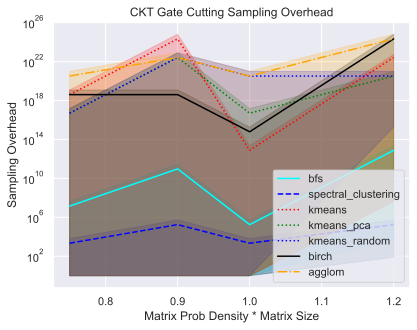

In [198]:
clustering_methods = ['bfs','spectral_clustering','kmeans','kmeans_pca','kmeans_random','birch','agglom']

x = df['p']* df['n']
colors = ['cyan', 'blue', 'red', 'green', 'blue', 'black', 'orange']
linestyles = ['solid', 'dashed', 'dotted', 'dotted',':', '-', '-.']
hue = df['max_cluster_size'].values

#ygerr = df_std[cm]['ER Graph Largest Component']

for i,cm in enumerate(clustering_methods):
    y = df[cm]#.apply(lambda x1: np.log(x1)).values
    ygerr = df2[cm]#.apply(lambda x1: np.log(x1)).values
    sns.lineplot(x=x, y=y, color=colors[i], linestyle=linestyles[i] , label=cm)#, hue_order=hue_order ,
    
    #plt.errorbar(x=x, y=y, yerr=y, linestyle='None',capsize=3, color=colors[i])

plt.title('CKT Gate Cutting Sampling Overhead')
plt.xlabel('Matrix Prob Density * Matrix Size')
plt.ylabel('Sampling Overhead')
plt.yscale('log')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


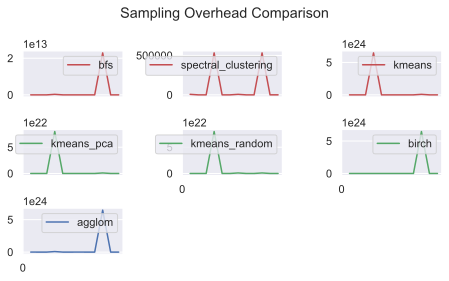

In [216]:
# Plotting
cm =['bfs','spectral_clustering','kmeans','kmeans_pca','kmeans_random','birch','agglom']

df[cm].plot(kind='line', subplots=True, grid=True, title="Sampling Overhead Comparison",
    layout=(4, 3), sharex=True, sharey=False, legend=False,    
    style=['r', 'r', 'r', 'g', 'g', 'g', 'b', 'b', 'b', 'r', 'r', 'r'],
    xticks=np.arange(0, len(df), 16))

for ax in plt.gcf().axes:
    ax.legend(loc=1)
    
plt.tight_layout()
plt.show()

/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_9032/103333949.py:20: UserWarning: The palette list has more values (11) than needed (7), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

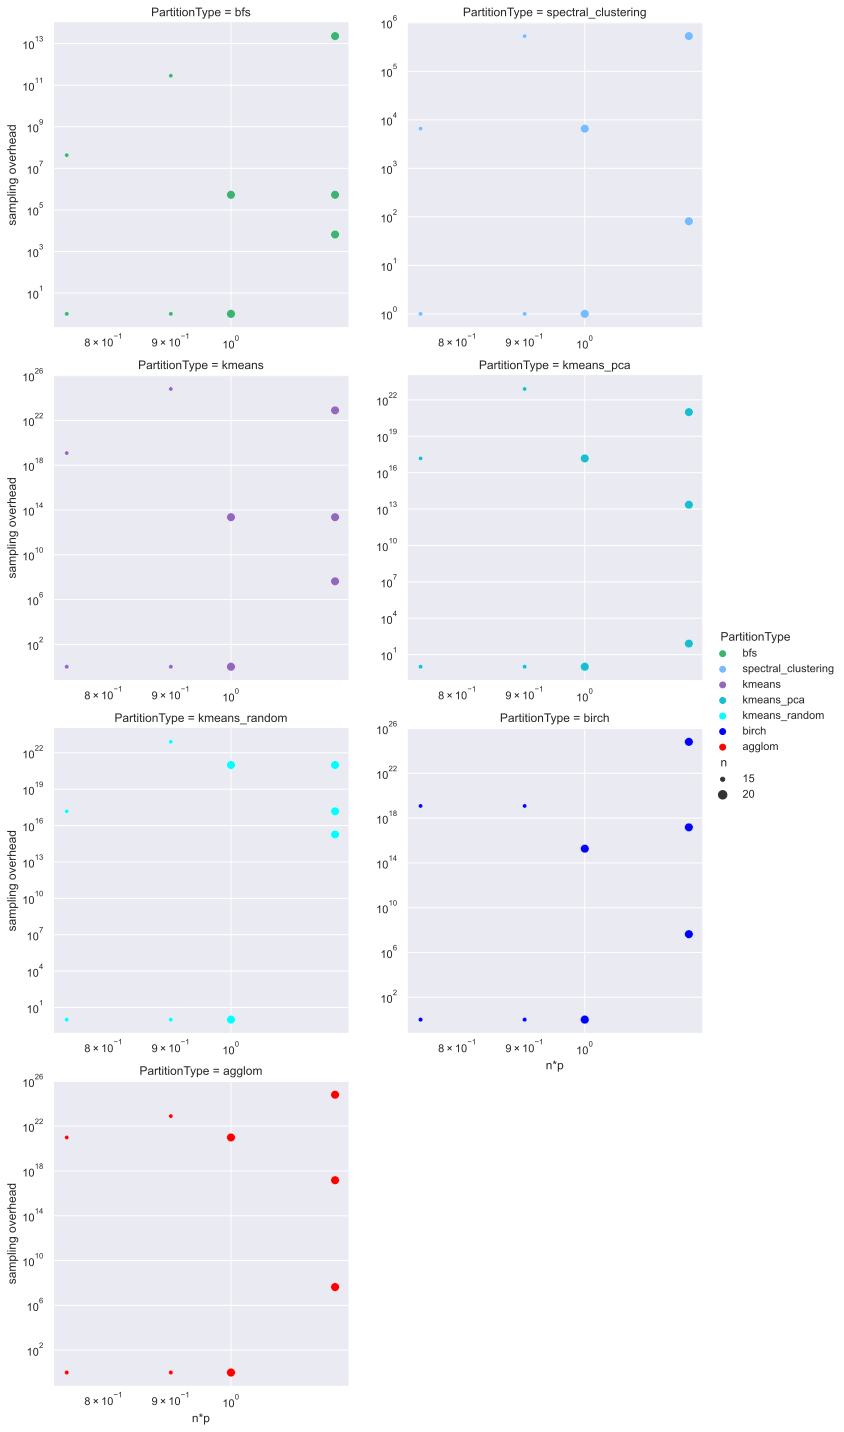

In [197]:
generate_rel_plot(df_melt, df_melt_std, 'scatter', False)

In [241]:
df_melt_mean = df_melt.groupby([ 'n','p', 'PartitionType']).mean().reset_index()

/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_9032/1156772013.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_melt_mean = df_melt.groupby([ 'n','p', 'PartitionType']).mean().reset_index()


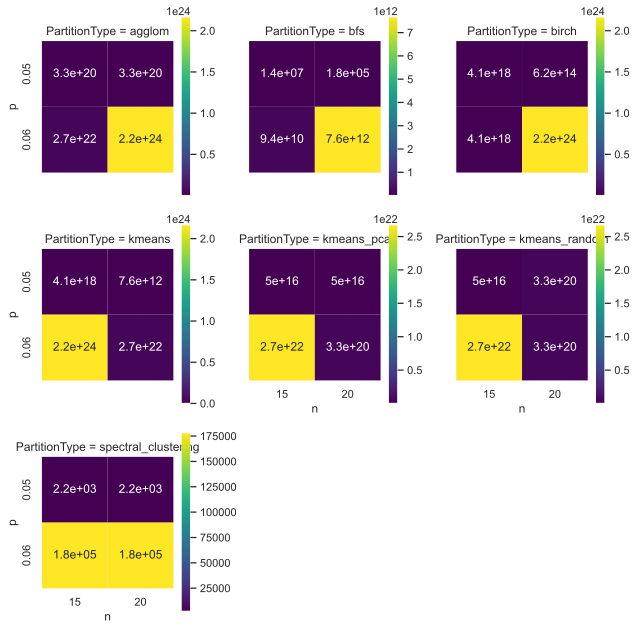

In [248]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    sns.heatmap(d, **kwargs,annot=True,cmap='viridis' )

fg = sns.FacetGrid(df_melt_mean, col='PartitionType',col_wrap=3)
fg.map_dataframe(draw_heatmap, 'n', 'p', 'SamplingOverhead', cbar=True, square = True)


In [229]:
df_melt.head(3)

,n,p,np,seed,max_cluster_size,qsubgraph_prop,PartitionType,SamplingOverhead
0,15,0.05,0.75,6591,5,"[{(0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 14): [[0 0...",bfs,43046721.0
1,15,0.05,0.75,9501,5,"[{(0, 2, 6, 7, 9): [[0 0 1 0 0], [0 0 1 0 0], ...",bfs,1.0
2,15,0.05,0.75,7139,5,"[{(0,): [[0.]], (1,): [[0.]], (2, 13, 6): [[0 ...",bfs,1.0


In [222]:
df_melt_std.head(3)

,n,p,PartitionType,SamplingOverhead
0,15,0.05,agglom,5.685577e+20
1,15,0.05,bfs,2.485304e+07
2,15,0.05,birch,7.019231e+18


In [232]:
df_melt_std[df_melt_std['PartitionType']=='bfs']

,n,p,PartitionType,SamplingOverhead
1,15,0.05,bfs,2.485304e+07
8,15,0.06,bfs,1.630608e+11
15,20,0.05,bfs,3.068270e+05
22,20,0.06,bfs,1.320792e+13


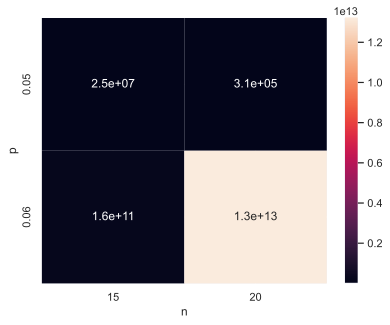

In [235]:
result = df_melt_std[df_melt_std['PartitionType']=='bfs'].pivot(index='p', columns='n', values='SamplingOverhead')
sns.heatmap(result, annot=True)
plt.show()
#result

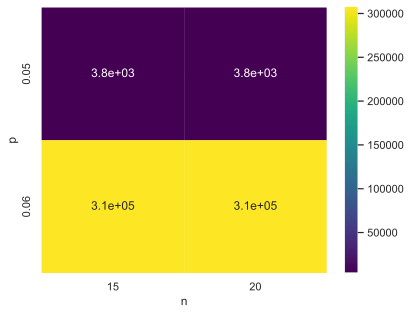

In [237]:
result = df_melt_std[df_melt_std['PartitionType']=='spectral_clustering'].pivot(index='p', columns='n', values='SamplingOverhead')
sns.heatmap(result, annot=True,cmap='viridis')
plt.show()

In [243]:
df_melt_mean.head(3)

,n,p,PartitionType,SamplingOverhead
0,15,0.05,agglom,3.282570e+20
1,15,0.05,bfs,1.434891e+07
2,15,0.05,birch,4.052555e+18


In [219]:
#df['bfs_log']= df['bfs'].apply(lambda x1: np.log(x1))

In [220]:
df3 = df.groupby(['n','p']).mean().reset_index()

In [227]:
df.head(5)

,n,p,seed,max_cluster_size,qsubgraph_prop,bfs,spectral_clustering,kmeans,kmeans_pca,kmeans_random,birch,agglom,np
1,15,0.05,6591,5,"[{(0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 14): [[0 0...",4.304672e+07,6561.0,1.215767e+19,1.500946e+17,1.500946e+17,1.215767e+19,9.847709e+20,0.75
2,15,0.05,9501,5,"[{(0, 2, 6, 7, 9): [[0 0 1 0 0], [0 0 1 0 0], ...",1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.75
3,15,0.05,7139,5,"[{(0,): [[0.]], (1,): [[0.]], (2, 13, 6): [[0 ...",1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.75
4,15,0.06,6591,5,"[{(0, 1, 4, 5, 6, 7, 9, 10, 11, 12, 14): [[0 1...",2.824295e+11,531441.0,6.461082e+24,7.976644e+22,7.976644e+22,1.215767e+19,7.976644e+22,0.9
5,15,0.06,9501,5,"[{(0, 2, 6, 7, 9): [[0 0 1 0 0], [0 0 1 0 0], ...",1.000000e+00,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.9


In [224]:
df3

,n,p,bfs,spectral_clustering,kmeans,kmeans_pca,kmeans_random,birch,agglom,bfs_log,bfs2,np
0,15,0.05,1.434891e+07,2187.666667,4.052555e+18,5.003155e+16,5.003155e+16,4.052555e+18,3.282570e+20,16.479184,5.666667,0.75
1,15,0.06,9.414318e+10,177147.666667,2.153694e+24,2.658881e+22,2.658881e+22,4.052555e+18,2.658881e+22,25.268083,8.666667,0.90
2,20,0.05,1.771477e+05,2187.666667,7.625597e+12,5.003155e+16,3.282570e+20,6.176734e+14,3.282570e+20,12.084739,4.333333,1.00
3,20,0.06,7.625598e+12,177201.000000,2.658881e+22,3.282570e+20,3.283076e+20,2.153694e+24,2.153694e+24,29.662532,17.000000,1.20


In [122]:
df3['np'] = df3['n'] * df3['p']

In [124]:
df3['bfs_log'] = df3['bfs'].apply(lambda x1: np.log(x1))

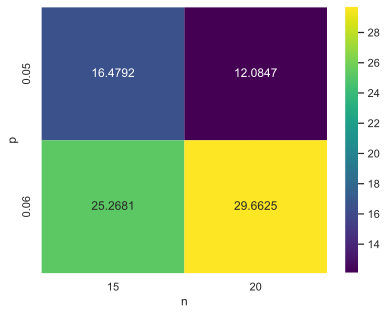

In [125]:
result = df3.pivot(index='p', columns='n', values='bfs_log')
sns.heatmap(result, annot=True, fmt="g", cmap='viridis')
plt.show()

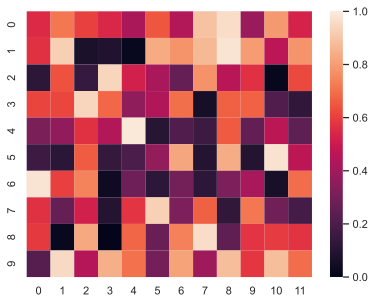

In [106]:
np.random.seed(0)
sns.set()
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(uniform_data, vmin=0, vmax=1)
plt.show()

### large n

In [36]:
matrix_sizes =  [75,100]
matrix_densities = [0.009,0.008]
num_of_experiments = 25
random_seeds = [random.randint(3000, 10000) for _ in range(num_of_experiments)]
max_cluster_sizes = [20]#,5,7]

df_large = ckt_exp(matrix_sizes, matrix_densities, random_seeds, max_cluster_sizes)



Experiment for size 75, density 0.009, seed 4382
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (33, 2, 38, 8, 9, 44, 13, 22)
Subgraph nodes : (3,)
Subgraph nodes : (4, 23)
Subgraph nodes : (5,)
Subgraph nodes : (6, 39)
Subgraph nodes : (7,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (16,)
Subgraph nodes : (17, 74, 60, 47)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (20, 62)
Subgraph nodes : (21,)
Subgraph nodes : (24, 55)
Subgraph nodes : (25, 53)
Subgraph nodes : (26, 70)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (61, 37, 31)
Subgraph nodes : (32, 67, 68, 73, 56)
Subgraph nodes : (34,)
Subgraph nodes : (35, 52)
Subgraph nodes : (58, 36, 45)
Subgraph nodes : (40, 50)
Subgraph nodes : (41, 63)
Subgraph nodes : (42,)
Subgraph nodes : (43,)
Subgraph nodes : (66, 46)
Subgraph nodes : (48,)
Subgraph no

Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2, 35, 67, 68, 70, 4, 8, 26, 44, 16, 18, 51, 19, 53, 22, 55, 58, 61)
Subgraph nodes : (3,)
Subgraph nodes : (5, 21)
Subgraph nodes : (6,)
Subgraph nodes : (64, 17, 52, 7)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12, 14)
Subgraph nodes : (13,)
Subgraph nodes : (15,)
Subgraph nodes : (20,)
Subgraph nodes : (54, 23)
Subgraph nodes : (24,)
Subgraph nodes : (25,)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (32,)
Subgraph nodes : (56, 33)
Subgraph nodes : (34,)
Subgraph nodes : (74, 36)
Subgraph nodes : (37,)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (43,)
Subgraph nodes : (45,)
Subgraph nodes : (46,)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph nodes : (49,)
Subgraph nodes : (50,)
Subgraph nodes : (57

Sampling overhead: 5.153775207320111e+47


Experiment for size 75, density 0.009, seed 6447
Subgraph nodes : (0, 73, 25)
Subgraph nodes : (1, 2, 39, 7, 9, 74, 16, 17, 18, 53, 58, 31)
Subgraph nodes : (3,)
Subgraph nodes : (27, 4)
Subgraph nodes : (5,)
Subgraph nodes : (6,)
Subgraph nodes : (8,)
Subgraph nodes : (10,)
Subgraph nodes : (11, 49, 43)
Subgraph nodes : (32, 36, 72, 12, 57)
Subgraph nodes : (13,)
Subgraph nodes : (50, 68, 14, 63)
Subgraph nodes : (15,)
Subgraph nodes : (19,)
Subgraph nodes : (20,)
Subgraph nodes : (47, 51, 21, 59, 29)
Subgraph nodes : (22,)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (65, 26)
Subgraph nodes : (28,)
Subgraph nodes : (30,)
Subgraph nodes : (33,)
Subgraph nodes : (34,)
Subgraph nodes : (35,)
Subgraph nodes : (37,)
Subgraph nodes : (38,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (44, 62)
Subgraph nodes : (45,)
Subgraph nodes : (46,)
Subgraph nodes : (48,)
Subgraph nodes : (52,)
Subgra

Sampling overhead: 4.1745579179292897e+49

Partition labels for CKT: αββγδεζβηβθικλμνβββξοπρσταυδφπχβκψωAκBCβDEFιGHIπJιμπKβLMNκβπOPGμQυRSμTUVκαβ
Sampling overhead: 4.1745579179292897e+49

Partition labels for CKT: αββγδεζβηβθικλμνβββξοπρσταυδφπχβκψωAκBCβDEFιGHIπJιμπKβLMNκβπOPGμQυRSμTUVκαβ
Sampling overhead: 4.1745579179292897e+49

Partition labels for CKT: αββγδεζβηβθικλμνβββξοπρσταυδφπχβκψωAκBCβDEFιGHIπJιμπKβLMNκβπOPGμQυRSμTUVκαβ
Sampling overhead: 4.1745579179292897e+49

Partition labels for CKT: αββγδεζβηβθικλμνβββξοπρσταυδφπχβκψωAκBCβDEFιGHIπJιμπKβLMNκβπOPGμQυRSμTUVκαβ
Sampling overhead: 4.1745579179292897e+49

Partition labels for CKT: αββγδεζβηβθικλμνβββξοπρσταυδφπχβκψωAκBCβDEFιGHIπJιμπKβLMNκβπOPGμQυRSμTUVκαβ
Sampling overhead: 4.1745579179292897e+49


Experiment for size 75, density 0.009, seed 4683
Subgraph nodes : (0, 35, 67, 3, 37, 70, 41, 74, 11, 10, 42, 45, 14, 49, 19, 51, 25)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph n

Sampling overhead: 3.381391913522724e+51


Experiment for size 75, density 0.009, seed 5222
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2, 44)
Subgraph nodes : (3,)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph nodes : (6,)
Subgraph nodes : (56, 29, 7)
Subgraph nodes : (67, 8, 73, 10, 20)
Subgraph nodes : (9,)
Subgraph nodes : (25, 11)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (18, 14)
Subgraph nodes : (65, 43, 52, 15)
Subgraph nodes : (16,)
Subgraph nodes : (17, 26, 66, 57)
Subgraph nodes : (19,)
Subgraph nodes : (21,)
Subgraph nodes : (22,)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (30,)
Subgraph nodes : (48, 31)
Subgraph nodes : (32,)
Subgraph nodes : (33, 49)
Subgraph nodes : (34, 74)
Subgraph nodes : (35,)
Subgraph nodes : (36, 46, 60)
Subgraph nodes : (37,)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (42,

Sampling overhead: 2.7389274499534066e+53


Experiment for size 75, density 0.009, seed 3190
Subgraph nodes : (0, 4, 37, 38, 71, 16, 18, 21, 56, 57, 63)
Subgraph nodes : (1,)
Subgraph nodes : (2, 43)
Subgraph nodes : (3,)
Subgraph nodes : (64, 5, 15)
Subgraph nodes : (72, 6)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (9, 26, 46)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (14,)
Subgraph nodes : (17,)
Subgraph nodes : (32, 19)
Subgraph nodes : (20,)
Subgraph nodes : (22,)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25,)
Subgraph nodes : (41, 27)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (40, 33, 68)
Subgraph nodes : (34,)
Subgraph nodes : (49, 35)
Subgraph nodes : (36,)
Subgraph nodes : (39,)
Subgraph nodes : (42,)
Subgraph nodes : (48, 66, 44)
Subgraph nodes : (45,)
Subgraph nodes : (47,)
Subgraph nodes : (50,)
Subgrap

Sampling overhead: 2.2185312344622594e+55

Partition labels for CKT: αβγδαεζηθικλμνξεαοαπραστυφιχψωABπCDEFααGCχHγIJιKIELMNOPQααRSTUVαεWIXCYZαζMa
Sampling overhead: 2.2185312344622594e+55

Partition labels for CKT: αβγδαεζηθικλμνξεαοαπραστυφιχψωABπCDEFααGCχHγIJιKIELMNOPQααRSTUVαεWIXCYZαζMa
Sampling overhead: 2.2185312344622594e+55

Partition labels for CKT: αβγδαεζηθικλμνξεαοαπραστυφιχψωABπCDEFααGCχHγIJιKIELMNOPQααRSTUVαεWIXCYZαζMa
Sampling overhead: 2.2185312344622594e+55

Partition labels for CKT: αβγδαεζηθικλμνξεαοαπραστυφιχψωABπCDEFααGCχHγIJιKIELMNOPQααRSTUVαεWIXCYZαζMa
Sampling overhead: 2.2185312344622594e+55

Partition labels for CKT: αβγδαεζηθικλμνξεαοαπραστυφιχψωABπCDEFααGCχHγIJιKIELMNOPQααRSTUVαεWIXCYZαζMa
Sampling overhead: 2.2185312344622594e+55


Experiment for size 75, density 0.009, seed 9320
Subgraph nodes : (0, 10, 48, 30)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph nodes : (53, 6)
Subgraph nodes

Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2, 5)
Subgraph nodes : (3,)
Subgraph nodes : (4,)
Subgraph nodes : (6,)
Subgraph nodes : (7,)
Subgraph nodes : (37, 8, 74, 10, 44, 47, 51, 54)
Subgraph nodes : (9,)
Subgraph nodes : (73, 11, 35)
Subgraph nodes : (12,)
Subgraph nodes : (13, 71)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (16, 17)
Subgraph nodes : (18, 43)
Subgraph nodes : (19,)
Subgraph nodes : (33, 20)
Subgraph nodes : (21,)
Subgraph nodes : (22,)
Subgraph nodes : (23,)
Subgraph nodes : (66, 72, 40, 24, 31)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (27,)
Subgraph nodes : (28, 70)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (32,)
Subgraph nodes : (34,)
Subgraph nodes : (36,)
Subgraph nodes : (41, 38)
Subgraph nodes : (39,)
Subgraph nodes : (42, 67, 46)
Subgraph nodes : (45,)
Subgraph nodes : (48,)
Subgraph nodes : (49,)
Subgraph nodes : (50,)
Subgraph nodes : (52,)
Subgraph nodes : (53,)
Subgraph node

Sampling overhead: 5.153775207320111e+47


Experiment for size 75, density 0.009, seed 4746
Subgraph nodes : (0,)
Subgraph nodes : (1, 6)
Subgraph nodes : (32, 2, 4, 5, 70, 72, 11, 17, 53, 22, 25, 62, 57)
Subgraph nodes : (56, 73, 3)
Subgraph nodes : (64, 7, 15)
Subgraph nodes : (67, 69, 8, 44, 21, 60)
Subgraph nodes : (9, 45)
Subgraph nodes : (10,)
Subgraph nodes : (12,)
Subgraph nodes : (33, 13)
Subgraph nodes : (14,)
Subgraph nodes : (16,)
Subgraph nodes : (18, 20, 50)
Subgraph nodes : (19,)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (26, 37)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (34,)
Subgraph nodes : (35,)
Subgraph nodes : (36, 63)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (43,)
Subgraph nodes : (52, 46)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph nodes : (49,)
Subgraph

Sampling overhead: 2.7389274499534066e+53

Partition labels for CKT: αβγδγγβεζηθγικλεμγνξνζγοπγρστυφχγκψωAρBCDEFGζηHIJKνLHγMNδγOPζQγAεRSζTζγUγδV
Sampling overhead: 2.7389274499534066e+53


Experiment for size 75, density 0.009, seed 3000
Subgraph nodes : (0, 65, 66, 67, 34, 37, 7, 72, 9, 42, 10, 46, 22, 55, 56, 26, 28)
Subgraph nodes : (1, 5, 61, 54, 29)
Subgraph nodes : (32, 2, 3, 68, 49, 51, 21)
Subgraph nodes : (4, 63)
Subgraph nodes : (6,)
Subgraph nodes : (8, 18)
Subgraph nodes : (11,)
Subgraph nodes : (40, 41, 12, 47, 53)
Subgraph nodes : (13,)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (16,)
Subgraph nodes : (17, 20)
Subgraph nodes : (19,)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25,)
Subgraph nodes : (27,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (33, 35)
Subgraph nodes : (36,)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (43,)
Subgraph nodes : (44,)
Subgraph nodes : (45,)
Subgraph nodes : (48,)


Subgraph nodes : (0, 5, 22)
Subgraph nodes : (1, 67, 4, 43, 12, 26)
Subgraph nodes : (2,)
Subgraph nodes : (3, 62)
Subgraph nodes : (51, 6, 30)
Subgraph nodes : (7,)
Subgraph nodes : (8, 57, 14)
Subgraph nodes : (9,)
Subgraph nodes : (10, 68, 58)
Subgraph nodes : (50, 11)
Subgraph nodes : (42, 13, 61)
Subgraph nodes : (15,)
Subgraph nodes : (16, 72)
Subgraph nodes : (17, 27, 20, 54)
Subgraph nodes : (18,)
Subgraph nodes : (19, 70)
Subgraph nodes : (21,)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25,)
Subgraph nodes : (33, 28, 31)
Subgraph nodes : (29,)
Subgraph nodes : (32,)
Subgraph nodes : (34,)
Subgraph nodes : (35, 69)
Subgraph nodes : (36,)
Subgraph nodes : (37,)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (44,)
Subgraph nodes : (45,)
Subgraph nodes : (46,)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph nodes : (49,)
Subgraph nodes : (52,)
Subgraph nodes : (53,)
Subgraph nodes : (55,)
Sub

Sampling overhead: 2.7389274499534066e+53

Partition labels for CKT: αβγδβαεζηθικβλημνξοπξραστυβξφχεφψφωABCDEFGλβHIJKLMκεNOξPQηιRSλδTUVWβιAπXνYZ
Sampling overhead: 2.7389274499534066e+53

Partition labels for CKT: αβγδβαεζηθικβλημνξοπξραστυβξφχεφψφωABCDEFGλβHIJKLMκεNOξPQηιRSλδTUVWβιAπXνYZ
Sampling overhead: 2.7389274499534066e+53

Partition labels for CKT: αβγδβαεζηθικβλημνξοπξραστυβξφχεφψφωABCDEFGλβHIJKLMκεNOξPQηιRSλδTUVWβιAπXνYZ
Sampling overhead: 2.7389274499534066e+53


Experiment for size 75, density 0.009, seed 6572
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (9, 18, 3, 12)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph nodes : (6, 39, 45, 51, 19, 56, 61)
Subgraph nodes : (42, 44, 7)
Subgraph nodes : (8,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (13,)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (16,)
Subgraph nodes : (17,)
Subgraph nodes : (32, 20, 55)
Subgraph nodes : (21, 70)
Subgraph nodes : 

Sampling overhead: 2.7389274499534066e+53


Experiment for size 75, density 0.009, seed 7511
Subgraph nodes : (0,)
Subgraph nodes : (1, 49)
Subgraph nodes : (2,)
Subgraph nodes : (3, 71, 39, 73, 21, 60)
Subgraph nodes : (27, 4)
Subgraph nodes : (36, 5)
Subgraph nodes : (6,)
Subgraph nodes : (33, 7, 13, 16, 17, 20, 22, 61)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (18, 38)
Subgraph nodes : (19,)
Subgraph nodes : (28, 23)
Subgraph nodes : (24,)
Subgraph nodes : (25, 67)
Subgraph nodes : (26,)
Subgraph nodes : (29,)
Subgraph nodes : (35, 72, 57, 59, 30)
Subgraph nodes : (31,)
Subgraph nodes : (32,)
Subgraph nodes : (34,)
Subgraph nodes : (37,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (56, 42)
Subgraph nodes : (43,)
Subgraph nodes : (44,)
Subgraph nodes : (45,)
Subgraph nodes : (46,)
Subgraph nodes : (54, 47)
Subgraph nodes : (48,)
Subg

Sampling overhead: 3.381391913522724e+51


Experiment for size 75, density 0.009, seed 8355
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (72, 3, 62)
Subgraph nodes : (4, 29)
Subgraph nodes : (74, 5)
Subgraph nodes : (6,)
Subgraph nodes : (69, 7)
Subgraph nodes : (8, 17, 36, 37)
Subgraph nodes : (9,)
Subgraph nodes : (40, 38, 10, 70)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (16,)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (20, 23)
Subgraph nodes : (34, 51, 21)
Subgraph nodes : (66, 22)
Subgraph nodes : (24, 35)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (27, 53)
Subgraph nodes : (28,)
Subgraph nodes : (30,)
Subgraph nodes : (31, 39)
Subgraph nodes : (32,)
Subgraph nodes : (33,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (43,)
Subgraph nodes : (44,)
Subgraph nodes : (45,)
Subgraph nodes : (46,)
Subgrap

Sampling overhead: 1.1972515182562016e+40

Partition labels for CKT: αβγδεζηθικλμνξοπριστυφχυψωABCεDEFGφψιιλEλHIJKLMNOPQφRBSTUVWXYZδabcχdeθλfδgζ
Sampling overhead: 1.1972515182562016e+40


Experiment for size 75, density 0.009, seed 5151
Subgraph nodes : (0,)
Subgraph nodes : (1, 50)
Subgraph nodes : (2,)
Subgraph nodes : (34, 3, 12, 17, 54)
Subgraph nodes : (4,)
Subgraph nodes : (41, 5)
Subgraph nodes : (6,)
Subgraph nodes : (60, 7)
Subgraph nodes : (8,)
Subgraph nodes : (9, 14)
Subgraph nodes : (10,)
Subgraph nodes : (11, 36, 39)
Subgraph nodes : (13,)
Subgraph nodes : (15,)
Subgraph nodes : (16,)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (20,)
Subgraph nodes : (21,)
Subgraph nodes : (69, 22)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25, 45)
Subgraph nodes : (48, 26, 66, 62)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (32,)
Subgraph nodes : (33,)
Subgraph

Sampling overhead: 3.381391913522724e+51

Partition labels for CKT: αβγδεζηθικλμδνκξοδπρστυφχψωABCDEFGδHμIJμKζLKMψNOωPβPQRδSTUVWθXωYZaωbKυcdefg
Sampling overhead: 3.381391913522724e+51


Experiment for size 75, density 0.009, seed 6923
Subgraph nodes : (0,)
Subgraph nodes : (1, 6, 13, 14, 27)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (4,)
Subgraph nodes : (5, 70)
Subgraph nodes : (12, 7)
Subgraph nodes : (8, 56, 22)
Subgraph nodes : (64, 34, 69, 9, 10, 41, 44, 15, 16, 49, 51, 25, 59)
Subgraph nodes : (11,)
Subgraph nodes : (17,)
Subgraph nodes : (18, 35)
Subgraph nodes : (19,)
Subgraph nodes : (20,)
Subgraph nodes : (21,)
Subgraph nodes : (23,)
Subgraph nodes : (24, 58, 53, 39)
Subgraph nodes : (26,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31, 71)
Subgraph nodes : (32, 54)
Subgraph nodes : (33,)
Subgraph nodes : (36,)
Subgraph nodes : (37,)
Subgraph nodes : (38,)
Subgraph nodes : (40,)
Subgraph nodes : (42, 68)
Subgraph 

Sampling overhead: 7.855167211278937e+43

Partition labels for CKT: αβγδεζβηθιικηββιιλμνξοθπρισβτυφχψωιμABCρDιEFιGHIJιKιLρψMθNριOPQOιRSTEιζχUVW
Sampling overhead: 7.855167211278937e+43

Partition labels for CKT: αβγδεζβηθιικηββιιλμνξοθπρισβτυφχψωιμABCρDιEFιGHIJιKιLρψMθNριOPQOιRSTEιζχUVW
Sampling overhead: 7.855167211278937e+43

Partition labels for CKT: αβγδεζβηθιικηββιιλμνξοθπρισβτυφχψωιμABCρDιEFιGHIJιKιLρψMθNριOPQOιRSTEιζχUVW
Sampling overhead: 7.855167211278937e+43


Experiment for size 75, density 0.009, seed 7716
Subgraph nodes : (0,)
Subgraph nodes : (1, 8, 42, 49, 22, 23, 60)
Subgraph nodes : (2,)
Subgraph nodes : (3, 43)
Subgraph nodes : (4,)
Subgraph nodes : (20, 5)
Subgraph nodes : (37, 6, 13, 14, 30)
Subgraph nodes : (40, 52, 7, 47)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (15,)
Subgraph nodes : (16,)
Subgraph nodes : (17,)
Subgraph nodes : (18,)
Subgraph nodes : (19, 45)
Subgraph nodes : (21,)
Subgraph nodes

Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2, 53)
Subgraph nodes : (3,)
Subgraph nodes : (4, 37)
Subgraph nodes : (65, 35, 5, 42, 13, 22, 24)
Subgraph nodes : (33, 34, 6)
Subgraph nodes : (10, 14, 7)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (38, 11, 16, 20, 23, 55, 25)
Subgraph nodes : (12,)
Subgraph nodes : (15,)
Subgraph nodes : (17, 69, 31)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (49, 58, 21)
Subgraph nodes : (26, 46)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (32,)
Subgraph nodes : (36,)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (43,)
Subgraph nodes : (44,)
Subgraph nodes : (45,)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph nodes : (50,)
Subgraph nodes : (51,)
Subgraph nodes : (52,)
Subgraph nodes : (54,)
Subgraph nodes : (56,)
Subgraph nodes : (57,)
Subgraph nodes : (59,)
Subgraph nodes : (60,)
Subgrap

Sampling overhead: 4.1745579179292897e+49

Partition labels for CKT: αβγδεζηθικθλμζθνλξοπλρζλζλστυφχξψηηζωελABCζDEFσGHρIJKγLλMNρOPQRSTζRUVξWQXYZ
Sampling overhead: 4.1745579179292897e+49

Partition labels for CKT: αβγδεζηθικθλμζθνλξοπλρζλζλστυφχξψηηζωελABCζDEFσGHρIJKγLλMNρOPQRSTζRUVξWQXYZ
Sampling overhead: 4.1745579179292897e+49

Partition labels for CKT: αβγδεζηθικθλμζθνλξοπλρζλζλστυφχξψηηζωελABCζDEFσGHρIJKγLλMNρOPQRSTζRUVξWQXYZ
Sampling overhead: 4.1745579179292897e+49

Partition labels for CKT: αβγδεζηθικθλμζθνλξοπλρζλζλστυφχξψηηζωελABCζDEFσGHρIJKγLλMNρOPQRSTζRUVξWQXYZ
Sampling overhead: 4.1745579179292897e+49

Partition labels for CKT: αβγδεζηθικθλμζθνλξοπλρζλζλστυφχξψηηζωελABCζDEFσGHρIJKγLλMNρOPQRSTζRUVξWQXYZ
Sampling overhead: 4.1745579179292897e+49


Experiment for size 75, density 0.009, seed 4628
Subgraph nodes : (0,)
Subgraph nodes : (1, 6, 73, 49, 23, 30)
Subgraph nodes : (2, 13)
Subgraph nodes : (3, 46)
Subgraph nodes : (33, 4)
Subgraph nodes : (74, 36, 5, 22)
Subgraph nod

Sampling overhead: 3.381391913522724e+51


Experiment for size 75, density 0.009, seed 5695
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2, 44, 13)
Subgraph nodes : (3,)
Subgraph nodes : (4, 20)
Subgraph nodes : (5,)
Subgraph nodes : (40, 6)
Subgraph nodes : (7,)
Subgraph nodes : (32, 67, 36, 8, 9, 72, 11, 52, 21, 57, 58, 27)
Subgraph nodes : (10,)
Subgraph nodes : (12, 46, 68)
Subgraph nodes : (33, 14)
Subgraph nodes : (15,)
Subgraph nodes : (16, 38)
Subgraph nodes : (17,)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (24, 61, 22)
Subgraph nodes : (23,)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (34,)
Subgraph nodes : (65, 35)
Subgraph nodes : (37,)
Subgraph nodes : (39,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (43,)
Subgraph nodes : (45,)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph nodes : (49,)
Subgraph no

Sampling overhead: 1.79701029991443e+57

Partition labels for CKT: αβγδεζηθιικιλγμνξοπρειστσυφιχψωAιμBCιDξEηFGHγIλJKLMNιOPQRιιSTσUVWCXιλYZaιbc
Sampling overhead: 1.79701029991443e+57


Experiment for size 75, density 0.009, seed 3294
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (4, 7, 9, 16, 54, 61)
Subgraph nodes : (12, 5, 44)
Subgraph nodes : (6,)
Subgraph nodes : (8,)
Subgraph nodes : (10, 29)
Subgraph nodes : (11,)
Subgraph nodes : (58, 42, 13, 62)
Subgraph nodes : (14,)
Subgraph nodes : (19, 15)
Subgraph nodes : (17,)
Subgraph nodes : (18,)
Subgraph nodes : (20, 55)
Subgraph nodes : (21, 70, 31)
Subgraph nodes : (22,)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25, 36, 47)
Subgraph nodes : (26,)
Subgraph nodes : (41, 27)
Subgraph nodes : (28,)
Subgraph nodes : (30,)
Subgraph nodes : (32,)
Subgraph nodes : (64, 33)
Subgraph nodes : (34, 53)
Subgraph nodes : (35,)
Subgraph nodes : (37,)
Subgraph nodes : 

Sampling overhead: 2.7389274499534066e+53

Partition labels for CKT: αβγδεζηεθεικζλμνεξονπρστυφχψωιAρBCDEφFGHIψλJζKLφMGNOPDεπQRλSTελUCLVWXYρXZab
Sampling overhead: 2.7389274499534066e+53


Experiment for size 75, density 0.009, seed 4873
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (73, 4, 61)
Subgraph nodes : (57, 43, 5)
Subgraph nodes : (6,)
Subgraph nodes : (64, 37, 7, 47, 15)
Subgraph nodes : (8, 35, 11)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (12,)
Subgraph nodes : (67, 13, 70)
Subgraph nodes : (14, 22)
Subgraph nodes : (39, 16, 53, 54, 29)
Subgraph nodes : (17,)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (20,)
Subgraph nodes : (21, 63)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (27,)
Subgraph nodes : (28, 36)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (32,)
Subgraph nodes : (33,)
Subgraph nodes 

Subgraph nodes : (0,)
Subgraph nodes : (1, 71, 73, 12, 19, 59, 29)
Subgraph nodes : (2,)
Subgraph nodes : (3, 5, 38, 7, 40, 31, 17, 26, 27, 28, 63)
Subgraph nodes : (4,)
Subgraph nodes : (6, 14)
Subgraph nodes : (8,)
Subgraph nodes : (9, 10, 51)
Subgraph nodes : (11,)
Subgraph nodes : (65, 39, 74, 13, 15, 47, 18, 30)
Subgraph nodes : (16,)
Subgraph nodes : (20,)
Subgraph nodes : (21,)
Subgraph nodes : (34, 46, 22)
Subgraph nodes : (68, 23)
Subgraph nodes : (24, 61)
Subgraph nodes : (25,)
Subgraph nodes : (32,)
Subgraph nodes : (33,)
Subgraph nodes : (35,)
Subgraph nodes : (36,)
Subgraph nodes : (37,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (43,)
Subgraph nodes : (44,)
Subgraph nodes : (72, 60, 45)
Subgraph nodes : (48,)
Subgraph nodes : (49,)
Subgraph nodes : (50,)
Subgraph nodes : (52,)
Subgraph nodes : (53,)
Subgraph nodes : (54,)
Subgraph nodes : (55,)
Subgraph nodes : (56,)
Subgraph nodes : (57,)
Subgraph nodes : (58,)
Subgraph nodes : (62,)
Subgraph nodes : 

Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (10, 21, 4, 69)
Subgraph nodes : (5,)
Subgraph nodes : (6,)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (9, 26, 54)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (28, 63, 46, 14)
Subgraph nodes : (15,)
Subgraph nodes : (16, 48)
Subgraph nodes : (17,)
Subgraph nodes : (64, 65, 32, 34, 37, 18)
Subgraph nodes : (19, 49, 35)
Subgraph nodes : (20,)
Subgraph nodes : (27, 36, 22)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25, 42)
Subgraph nodes : (33, 43, 53, 56, 57, 29)
Subgraph nodes : (30,)
Subgraph nodes : (51, 31)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (40, 66, 62)
Subgraph nodes : (41,)
Subgraph nodes : (44,)
Subgraph nodes : (45,)
Subgraph nodes : (47,)
Subgraph nodes : (50,)
Subgraph nodes : (52,)
Subgraph nodes : (55,)
Subgraph nodes : (58,)
Subgraph nodes : (59,)
Subgraph nodes :

Subgraph nodes : (0, 9)
Subgraph nodes : (1,)
Subgraph nodes : (2, 7)
Subgraph nodes : (3,)
Subgraph nodes : (34, 35, 4)
Subgraph nodes : (49, 5, 6)
Subgraph nodes : (8,)
Subgraph nodes : (10, 42, 16, 18, 55)
Subgraph nodes : (11,)
Subgraph nodes : (12, 45, 44, 23)
Subgraph nodes : (13, 69, 62)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (17, 53)
Subgraph nodes : (19,)
Subgraph nodes : (26, 27, 20, 37)
Subgraph nodes : (21,)
Subgraph nodes : (22,)
Subgraph nodes : (24,)
Subgraph nodes : (25,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (32, 57, 58, 70)
Subgraph nodes : (33,)
Subgraph nodes : (36,)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (43,)
Subgraph nodes : (46,)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph nodes : (50,)
Subgraph nodes : (51,)
Subgraph nodes : (52,)
Subgraph nodes : (54,)
Subgraph nodes : (56,)
Subgraph nod

Sampling overhead: 6.36268544113594e+45


Experiment for size 75, density 0.008, seed 4382
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2, 44, 38, 22)
Subgraph nodes : (3,)
Subgraph nodes : (4, 23)
Subgraph nodes : (5,)
Subgraph nodes : (6, 39)
Subgraph nodes : (7,)
Subgraph nodes : (8, 9, 13, 33)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (16,)
Subgraph nodes : (17, 74, 60, 47)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (20, 62)
Subgraph nodes : (21,)
Subgraph nodes : (24, 55)
Subgraph nodes : (25, 53)
Subgraph nodes : (26, 70)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (61, 37, 31)
Subgraph nodes : (32, 67, 68, 73, 56)
Subgraph nodes : (34,)
Subgraph nodes : (35, 52)
Subgraph nodes : (58, 36, 45)
Subgraph nodes : (40, 50)
Subgraph nodes : (41, 63)
Subgraph nodes : (42,)
Subgraph nodes : (43,)
Su

Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (51, 4)
Subgraph nodes : (5, 21)
Subgraph nodes : (6,)
Subgraph nodes : (64, 17, 52, 7)
Subgraph nodes : (67, 35, 68, 70, 8, 44, 16, 18, 19, 53, 22, 55, 58, 61)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12, 14)
Subgraph nodes : (13,)
Subgraph nodes : (15,)
Subgraph nodes : (20,)
Subgraph nodes : (54, 23)
Subgraph nodes : (24,)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (32,)
Subgraph nodes : (56, 33)
Subgraph nodes : (34,)
Subgraph nodes : (74, 36)
Subgraph nodes : (37,)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (43,)
Subgraph nodes : (45,)
Subgraph nodes : (46,)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph n

Sampling overhead: 6.36268544113594e+45


Experiment for size 75, density 0.008, seed 6447
Subgraph nodes : (0, 73, 25)
Subgraph nodes : (1, 2, 39, 7, 9, 74, 16, 17, 18, 53, 58, 31)
Subgraph nodes : (3,)
Subgraph nodes : (27, 4)
Subgraph nodes : (5,)
Subgraph nodes : (6,)
Subgraph nodes : (8,)
Subgraph nodes : (10,)
Subgraph nodes : (11, 49, 43)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (50, 68, 14, 63)
Subgraph nodes : (15,)
Subgraph nodes : (19,)
Subgraph nodes : (20,)
Subgraph nodes : (47, 51, 21, 59, 29)
Subgraph nodes : (22,)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (65, 26)
Subgraph nodes : (28,)
Subgraph nodes : (30,)
Subgraph nodes : (32, 57, 72, 36)
Subgraph nodes : (33,)
Subgraph nodes : (34,)
Subgraph nodes : (35,)
Subgraph nodes : (37,)
Subgraph nodes : (38,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (44, 62)
Subgraph nodes : (45,)
Subgraph nodes : (46,)
Subgraph nodes : (48,)
Subgraph no

Sampling overhead: 7.855167211278937e+43


Experiment for size 75, density 0.008, seed 4683
Subgraph nodes : (0, 67, 3, 41, 10, 74, 42, 45, 14, 49, 19, 51, 25)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph nodes : (27, 6)
Subgraph nodes : (7,)
Subgraph nodes : (8, 16, 58, 55)
Subgraph nodes : (48, 9, 52)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (15,)
Subgraph nodes : (17,)
Subgraph nodes : (18,)
Subgraph nodes : (20,)
Subgraph nodes : (21, 22)
Subgraph nodes : (32, 23)
Subgraph nodes : (24, 50)
Subgraph nodes : (26,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (33, 63)
Subgraph nodes : (34,)
Subgraph nodes : (35, 37, 70)
Subgraph nodes : (65, 36, 47, 53, 60)
Subgraph nodes : (40, 38)
Subgraph nodes : (66, 68, 61, 39)
Subgraph nodes : (43,)
Subgraph nodes : (44,)
Subgraph nodes : (46,)
Subgraph nodes : (54,)
Subgraph nodes : (56

Sampling overhead: 7.855167211278937e+43


Experiment for size 75, density 0.008, seed 5222
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2, 44)
Subgraph nodes : (3,)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph nodes : (6,)
Subgraph nodes : (56, 29, 7)
Subgraph nodes : (67, 8, 73, 10, 20)
Subgraph nodes : (9,)
Subgraph nodes : (25, 11)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (18, 14)
Subgraph nodes : (65, 43, 52, 15)
Subgraph nodes : (16,)
Subgraph nodes : (17, 26, 66, 57)
Subgraph nodes : (19,)
Subgraph nodes : (21,)
Subgraph nodes : (22,)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (30,)
Subgraph nodes : (48, 31)
Subgraph nodes : (32,)
Subgraph nodes : (33, 49)
Subgraph nodes : (34, 74)
Subgraph nodes : (35,)
Subgraph nodes : (36, 60)
Subgraph nodes : (37,)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Su

Sampling overhead: 7.855167211278937e+43


Experiment for size 75, density 0.008, seed 3190
Subgraph nodes : (0, 37, 71, 16, 18, 56, 57, 63)
Subgraph nodes : (1,)
Subgraph nodes : (2, 43)
Subgraph nodes : (3,)
Subgraph nodes : (4, 21, 38)
Subgraph nodes : (64, 5, 15)
Subgraph nodes : (72, 6)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (9, 26, 46)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (14,)
Subgraph nodes : (17,)
Subgraph nodes : (32, 19)
Subgraph nodes : (20,)
Subgraph nodes : (22,)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25,)
Subgraph nodes : (41, 27)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (33, 68)
Subgraph nodes : (34,)
Subgraph nodes : (49, 35)
Subgraph nodes : (36,)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (42,)
Subgraph nodes : (48, 44)
Subgraph nodes : (45,)
Subgraph nodes : (47,

Sampling overhead: 6.36268544113594e+45


Experiment for size 75, density 0.008, seed 9320
Subgraph nodes : (0, 10, 48, 30)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph nodes : (53, 6)
Subgraph nodes : (7,)
Subgraph nodes : (8, 51)
Subgraph nodes : (9,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (14, 39)
Subgraph nodes : (15,)
Subgraph nodes : (16, 32, 67, 23)
Subgraph nodes : (17, 41)
Subgraph nodes : (18,)
Subgraph nodes : (19, 36, 63)
Subgraph nodes : (20, 37)
Subgraph nodes : (21,)
Subgraph nodes : (22,)
Subgraph nodes : (24, 38)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (43, 29)
Subgraph nodes : (68, 31)
Subgraph nodes : (33,)
Subgraph nodes : (34,)
Subgraph nodes : (35,)
Subgraph nodes : (40, 64)
Subgraph nodes : (57, 42, 69, 70)
Subgraph nodes : (44,)
Subgraph nodes : (74, 45)
Subgraph nodes : (46,

Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2, 5)
Subgraph nodes : (3,)
Subgraph nodes : (4,)
Subgraph nodes : (6,)
Subgraph nodes : (7,)
Subgraph nodes : (37, 8, 74, 10, 44, 51, 54)
Subgraph nodes : (9,)
Subgraph nodes : (11, 35)
Subgraph nodes : (12,)
Subgraph nodes : (13, 71)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (16, 17)
Subgraph nodes : (18, 43)
Subgraph nodes : (19,)
Subgraph nodes : (33, 20)
Subgraph nodes : (21,)
Subgraph nodes : (22,)
Subgraph nodes : (23,)
Subgraph nodes : (24, 66, 72, 31)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (27,)
Subgraph nodes : (28, 70)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (32,)
Subgraph nodes : (34,)
Subgraph nodes : (36,)
Subgraph nodes : (41, 38)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (42, 67, 46)
Subgraph nodes : (45,)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph nodes : (49,)
Subgraph nodes : (50,)
Subgraph nodes : (52,)
Su

Sampling overhead: 9.697737297875232e+41


Experiment for size 75, density 0.008, seed 4746
Subgraph nodes : (0,)
Subgraph nodes : (1, 6)
Subgraph nodes : (2,)
Subgraph nodes : (56, 73, 3)
Subgraph nodes : (4, 5, 70, 22, 57, 25)
Subgraph nodes : (64, 7, 15)
Subgraph nodes : (8,)
Subgraph nodes : (9, 45)
Subgraph nodes : (10,)
Subgraph nodes : (32, 72, 11, 17, 53, 62)
Subgraph nodes : (12,)
Subgraph nodes : (33, 13)
Subgraph nodes : (14,)
Subgraph nodes : (16,)
Subgraph nodes : (18, 20, 50)
Subgraph nodes : (19,)
Subgraph nodes : (67, 69, 44, 21, 60)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (26, 37)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (34,)
Subgraph nodes : (35,)
Subgraph nodes : (36, 63)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (43,)
Subgraph nodes : (52, 46)
Subgraph nodes : (47,

Sampling overhead: 4.1745579179292897e+49


Experiment for size 75, density 0.008, seed 3000
Subgraph nodes : (0, 65, 66, 67, 34, 37, 7, 72, 9, 42, 10, 46, 22, 56, 26, 28)
Subgraph nodes : (1, 29, 61, 54)
Subgraph nodes : (2,)
Subgraph nodes : (49, 3, 68, 51)
Subgraph nodes : (4, 63)
Subgraph nodes : (5,)
Subgraph nodes : (6,)
Subgraph nodes : (8, 18)
Subgraph nodes : (11,)
Subgraph nodes : (40, 41, 12, 47, 53)
Subgraph nodes : (13,)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (16,)
Subgraph nodes : (17, 20)
Subgraph nodes : (19,)
Subgraph nodes : (32, 21)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25,)
Subgraph nodes : (27,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (33, 35)
Subgraph nodes : (36,)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (43,)
Subgraph nodes : (44,)
Subgraph nodes : (45,)
Subgraph nodes : (48,)
Subgraph nodes : (50,)
Subgraph nodes : (52, 69, 71)
Subgraph nodes : (55,)
Subgraph nodes : 

Subgraph nodes : (0, 5, 22)
Subgraph nodes : (1, 67, 4, 43, 12, 26)
Subgraph nodes : (2,)
Subgraph nodes : (3, 62)
Subgraph nodes : (51, 6, 30)
Subgraph nodes : (7,)
Subgraph nodes : (8, 57, 14)
Subgraph nodes : (9,)
Subgraph nodes : (10, 68)
Subgraph nodes : (50, 11)
Subgraph nodes : (42, 13, 61)
Subgraph nodes : (15,)
Subgraph nodes : (16, 72)
Subgraph nodes : (17, 27, 20, 54)
Subgraph nodes : (18,)
Subgraph nodes : (19, 70)
Subgraph nodes : (21,)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25,)
Subgraph nodes : (33, 28)
Subgraph nodes : (29,)
Subgraph nodes : (31,)
Subgraph nodes : (32,)
Subgraph nodes : (34,)
Subgraph nodes : (35, 69)
Subgraph nodes : (36,)
Subgraph nodes : (37,)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (44,)
Subgraph nodes : (45,)
Subgraph nodes : (46,)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph nodes : (49,)
Subgraph nodes : (52,)
Subgraph nodes : (53,)
Subgraph no

Sampling overhead: 4.1745579179292897e+49


Experiment for size 75, density 0.008, seed 6572
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3, 12)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph nodes : (6, 39, 45, 51, 19, 56, 61)
Subgraph nodes : (42, 44, 7)
Subgraph nodes : (8,)
Subgraph nodes : (9, 18)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (13,)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (16,)
Subgraph nodes : (17,)
Subgraph nodes : (20, 55)
Subgraph nodes : (21, 70)
Subgraph nodes : (22,)
Subgraph nodes : (23,)
Subgraph nodes : (24, 48, 68, 28)
Subgraph nodes : (25,)
Subgraph nodes : (41, 26)
Subgraph nodes : (27,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (32,)
Subgraph nodes : (33,)
Subgraph nodes : (34,)
Subgraph nodes : (35,)
Subgraph nodes : (36,)
Subgraph nodes : (37,)
Subgraph nodes : (38,)
Subgraph nodes : (40,)
Subgraph nodes : (43,)
Subgraph n

Sampling overhead: 5.153775207320111e+47


Experiment for size 75, density 0.008, seed 7511
Subgraph nodes : (0,)
Subgraph nodes : (1, 49)
Subgraph nodes : (2,)
Subgraph nodes : (3, 71, 39, 73, 21, 60)
Subgraph nodes : (27, 4)
Subgraph nodes : (36, 5)
Subgraph nodes : (6,)
Subgraph nodes : (33, 7, 13, 16, 17, 20, 22, 61)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (18, 38)
Subgraph nodes : (19,)
Subgraph nodes : (28, 23)
Subgraph nodes : (24,)
Subgraph nodes : (25, 67)
Subgraph nodes : (26,)
Subgraph nodes : (29,)
Subgraph nodes : (35, 72, 57, 59, 30)
Subgraph nodes : (31,)
Subgraph nodes : (32,)
Subgraph nodes : (34,)
Subgraph nodes : (37,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (56, 42)
Subgraph nodes : (43,)
Subgraph nodes : (44,)
Subgraph nodes : (45,)
Subgraph nodes : (46,)
Subgraph nodes : (54, 47)
Subgraph nodes : (48,)
Subgr

Sampling overhead: 6.36268544113594e+45


Experiment for size 75, density 0.008, seed 8355
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (72, 3)
Subgraph nodes : (4, 29)
Subgraph nodes : (74, 5)
Subgraph nodes : (6,)
Subgraph nodes : (69, 7)
Subgraph nodes : (8, 17, 36, 37)
Subgraph nodes : (9,)
Subgraph nodes : (40, 38, 10, 70)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (16,)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (20, 23)
Subgraph nodes : (34, 51, 21)
Subgraph nodes : (66, 22)
Subgraph nodes : (24, 35)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (27, 53)
Subgraph nodes : (28,)
Subgraph nodes : (30,)
Subgraph nodes : (31, 39)
Subgraph nodes : (32,)
Subgraph nodes : (33,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (43,)
Subgraph nodes : (44,)
Subgraph nodes : (45,)
Subgraph nodes : (46,)
Subgraph nod

Subgraph nodes : (0,)
Subgraph nodes : (1, 50)
Subgraph nodes : (2,)
Subgraph nodes : (34, 3, 12, 17, 54)
Subgraph nodes : (4,)
Subgraph nodes : (41, 5)
Subgraph nodes : (6,)
Subgraph nodes : (60, 7)
Subgraph nodes : (8,)
Subgraph nodes : (9, 14)
Subgraph nodes : (10,)
Subgraph nodes : (11, 36, 39)
Subgraph nodes : (13,)
Subgraph nodes : (15,)
Subgraph nodes : (16,)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (20,)
Subgraph nodes : (21,)
Subgraph nodes : (69, 22)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25, 45)
Subgraph nodes : (26, 66, 62)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (32,)
Subgraph nodes : (33,)
Subgraph nodes : (35,)
Subgraph nodes : (37,)
Subgraph nodes : (38,)
Subgraph nodes : (40, 43, 68)
Subgraph nodes : (42,)
Subgraph nodes : (44,)
Subgraph nodes : (46,)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph nodes : (49, 51)
Subgraph n

Sampling overhead: 6.36268544113594e+45


Experiment for size 75, density 0.008, seed 6923
Subgraph nodes : (0,)
Subgraph nodes : (1, 6, 13, 14, 27)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (4,)
Subgraph nodes : (5, 70)
Subgraph nodes : (12, 7)
Subgraph nodes : (8, 56, 22)
Subgraph nodes : (64, 34, 9, 10, 41, 15, 16, 49, 59)
Subgraph nodes : (11,)
Subgraph nodes : (17,)
Subgraph nodes : (18, 35)
Subgraph nodes : (19,)
Subgraph nodes : (20,)
Subgraph nodes : (21,)
Subgraph nodes : (23,)
Subgraph nodes : (24, 58, 53, 39)
Subgraph nodes : (25, 51, 44)
Subgraph nodes : (26,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31, 71)
Subgraph nodes : (32, 54)
Subgraph nodes : (33,)
Subgraph nodes : (36,)
Subgraph nodes : (37,)
Subgraph nodes : (38,)
Subgraph nodes : (40,)
Subgraph nodes : (42, 68)
Subgraph nodes : (43,)
Subgraph nodes : (45,)
Subgraph nodes : (46,)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph nodes : (50,)
Su

Subgraph nodes : (0,)
Subgraph nodes : (1, 8, 42, 49, 22, 23, 60)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (4,)
Subgraph nodes : (20, 5)
Subgraph nodes : (37, 6, 13, 14, 30)
Subgraph nodes : (40, 52, 7, 47)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (15,)
Subgraph nodes : (16,)
Subgraph nodes : (17,)
Subgraph nodes : (18,)
Subgraph nodes : (19, 45)
Subgraph nodes : (21,)
Subgraph nodes : (24,)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (56, 65, 31)
Subgraph nodes : (32,)
Subgraph nodes : (33, 41)
Subgraph nodes : (34,)
Subgraph nodes : (35,)
Subgraph nodes : (36,)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (43,)
Subgraph nodes : (44,)
Subgraph nodes : (46, 62)
Subgraph nodes : (48, 63)
Subgraph nodes : (50,)
Subgraph nodes : (51,)
Subgraph nodes : (53, 55)
Subgraph nodes : (54,)
Subgraph nodes :

Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2, 53)
Subgraph nodes : (3,)
Subgraph nodes : (4, 37)
Subgraph nodes : (65, 35, 5, 42, 13, 22, 24)
Subgraph nodes : (33, 34, 6)
Subgraph nodes : (10, 14, 7)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (38, 11, 16, 55, 25)
Subgraph nodes : (12,)
Subgraph nodes : (15,)
Subgraph nodes : (17, 69, 31)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (20, 23)
Subgraph nodes : (49, 21)
Subgraph nodes : (26, 46)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (32,)
Subgraph nodes : (36,)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (43,)
Subgraph nodes : (44,)
Subgraph nodes : (45,)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph nodes : (50,)
Subgraph nodes : (51,)
Subgraph nodes : (52,)
Subgraph nodes : (54,)
Subgraph nodes : (56,)
Subgraph nodes : (57,)
Subgraph nodes : (58,)
Subgraph nodes :

Sampling overhead: 9.697737297875232e+41


Experiment for size 75, density 0.008, seed 4628
Subgraph nodes : (0,)
Subgraph nodes : (1, 6, 73, 49, 23, 30)
Subgraph nodes : (2, 13)
Subgraph nodes : (3, 46)
Subgraph nodes : (33, 4)
Subgraph nodes : (74, 36, 5, 22)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (69, 11, 60, 29)
Subgraph nodes : (35, 43, 12, 45, 17, 24, 57, 26, 61, 62)
Subgraph nodes : (14,)
Subgraph nodes : (15,)
Subgraph nodes : (16, 19)
Subgraph nodes : (18,)
Subgraph nodes : (67, 20)
Subgraph nodes : (21,)
Subgraph nodes : (25,)
Subgraph nodes : (27,)
Subgraph nodes : (28,)
Subgraph nodes : (31,)
Subgraph nodes : (32, 37)
Subgraph nodes : (34,)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (40, 58, 53)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (44,)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph nodes : (50,)
Subgraph nodes : (51,)
Subgraph nodes : (52,)
Subgraph nod

Sampling overhead: 6.36268544113594e+45


Experiment for size 75, density 0.008, seed 5695
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2, 13)
Subgraph nodes : (3,)
Subgraph nodes : (4, 20)
Subgraph nodes : (5,)
Subgraph nodes : (40, 6)
Subgraph nodes : (7,)
Subgraph nodes : (8, 36, 52)
Subgraph nodes : (32, 67, 72, 9, 11, 21, 57, 58, 27)
Subgraph nodes : (10,)
Subgraph nodes : (12, 46, 68)
Subgraph nodes : (33, 14)
Subgraph nodes : (15,)
Subgraph nodes : (16, 38)
Subgraph nodes : (17,)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (24, 61, 22)
Subgraph nodes : (23,)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (28,)
Subgraph nodes : (29,)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (34,)
Subgraph nodes : (65, 35)
Subgraph nodes : (37,)
Subgraph nodes : (39,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (43,)
Subgraph nodes : (44,)
Subgraph nodes : (45,)
Subgraph nodes : (47,)
Subgraph nodes : (48,

Sampling overhead: 5.153775207320111e+47


Experiment for size 75, density 0.008, seed 3294
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (4, 7, 9, 16, 54, 61)
Subgraph nodes : (12, 5, 44)
Subgraph nodes : (6,)
Subgraph nodes : (8,)
Subgraph nodes : (10, 29)
Subgraph nodes : (11,)
Subgraph nodes : (58, 13)
Subgraph nodes : (14,)
Subgraph nodes : (19, 15)
Subgraph nodes : (17,)
Subgraph nodes : (18,)
Subgraph nodes : (20, 55)
Subgraph nodes : (21, 70, 31)
Subgraph nodes : (22,)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25, 36, 47)
Subgraph nodes : (26,)
Subgraph nodes : (41, 27)
Subgraph nodes : (28,)
Subgraph nodes : (30,)
Subgraph nodes : (32,)
Subgraph nodes : (64, 33)
Subgraph nodes : (34,)
Subgraph nodes : (35,)
Subgraph nodes : (37,)
Subgraph nodes : (49, 38)
Subgraph nodes : (39,)
Subgraph nodes : (40,)
Subgraph nodes : (42, 62)
Subgraph nodes : (43,)
Subgraph nodes : (45,)
Subgraph nodes : (65, 46)


Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (73, 4, 61)
Subgraph nodes : (57, 43, 5)
Subgraph nodes : (6,)
Subgraph nodes : (64, 7, 37, 15)
Subgraph nodes : (8, 35, 11)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (12,)
Subgraph nodes : (67, 13, 70)
Subgraph nodes : (14, 22)
Subgraph nodes : (39, 16, 53, 54, 29)
Subgraph nodes : (17,)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (20,)
Subgraph nodes : (21, 63)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (27,)
Subgraph nodes : (28, 36)
Subgraph nodes : (30,)
Subgraph nodes : (31,)
Subgraph nodes : (32,)
Subgraph nodes : (33,)
Subgraph nodes : (34, 45)
Subgraph nodes : (38,)
Subgraph nodes : (40,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (44,)
Subgraph nodes : (46,)
Subgraph nodes : (47,)
Subgraph nodes : (48,)
Subgraph nodes : (49,)
Subgraph nodes : (50,)
S

Subgraph nodes : (0,)
Subgraph nodes : (1, 71, 73, 12, 19, 59, 29)
Subgraph nodes : (2,)
Subgraph nodes : (3, 5, 38, 7, 40, 31, 17, 26, 27, 28, 63)
Subgraph nodes : (4,)
Subgraph nodes : (6, 14)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (10, 51)
Subgraph nodes : (11,)
Subgraph nodes : (65, 39, 74, 13, 15, 47, 18, 30)
Subgraph nodes : (16,)
Subgraph nodes : (20,)
Subgraph nodes : (21,)
Subgraph nodes : (34, 46, 22)
Subgraph nodes : (68, 23)
Subgraph nodes : (24, 61)
Subgraph nodes : (25,)
Subgraph nodes : (32,)
Subgraph nodes : (33,)
Subgraph nodes : (35,)
Subgraph nodes : (36,)
Subgraph nodes : (37,)
Subgraph nodes : (41,)
Subgraph nodes : (42,)
Subgraph nodes : (43,)
Subgraph nodes : (44,)
Subgraph nodes : (72, 60, 45)
Subgraph nodes : (48,)
Subgraph nodes : (49,)
Subgraph nodes : (50,)
Subgraph nodes : (52,)
Subgraph nodes : (53,)
Subgraph nodes : (54,)
Subgraph nodes : (55,)
Subgraph nodes : (56,)
Subgraph nodes : (57,)
Subgraph nodes : (58,)
Subgraph nodes : (62,

Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (4, 21)
Subgraph nodes : (5,)
Subgraph nodes : (6,)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (9, 26, 54)
Subgraph nodes : (10, 69)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (28, 63, 46, 14)
Subgraph nodes : (15,)
Subgraph nodes : (16, 48)
Subgraph nodes : (17,)
Subgraph nodes : (64, 32, 34, 37, 18)
Subgraph nodes : (19, 49, 35)
Subgraph nodes : (20,)
Subgraph nodes : (27, 22)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (25, 42)
Subgraph nodes : (56, 33, 29)
Subgraph nodes : (30,)
Subgraph nodes : (51, 31)
Subgraph nodes : (36,)
Subgraph nodes : (38,)
Subgraph nodes : (39,)
Subgraph nodes : (40, 66, 62)
Subgraph nodes : (41,)
Subgraph nodes : (43, 53)
Subgraph nodes : (44,)
Subgraph nodes : (45,)
Subgraph nodes : (47,)
Subgraph nodes : (50,)
Subgraph nodes : (52,)
Subgraph nodes : (55,)
Subgraph nodes 

Sampling overhead: 2.2528399544939168e+34

Partition labels for CKT: αβγδεζηθικλμνξοπρστυφεχψωAκχοBCDτBτυEτFGHIAJKLοMρυNDOJκPBQRSTUHοτVHWXλYZabc
Sampling overhead: 2.2528399544939168e+34

Partition labels for CKT: αβγδεζηθικλμνξοπρστυφεχψωAκχοBCDτBτυEτFGHIAJKLοMρυNDOJκPBQRSTUHοτVHWXλYZabc
Sampling overhead: 2.2528399544939168e+34

Partition labels for CKT: αβγδεζηθικλμνξοπρστυφεχψωAκχοBCDτBτυEτFGHIAJKLοMρυNDOJκPBQRSTUHοτVHWXλYZabc
Sampling overhead: 2.2528399544939168e+34

Partition labels for CKT: αβγδεζηθικλμνξοπρστυφεχψωAκχοBCDτBτυEτFGHIAJKLοMρυNDOJκPBQRSTUHοτVHWXλYZabc
Sampling overhead: 2.2528399544939168e+34


Experiment for size 75, density 0.008, seed 8163
Subgraph nodes : (0, 9)
Subgraph nodes : (1,)
Subgraph nodes : (2, 7)
Subgraph nodes : (3,)
Subgraph nodes : (34, 35, 4)
Subgraph nodes : (49, 5)
Subgraph nodes : (6,)
Subgraph nodes : (8,)
Subgraph nodes : (10, 42, 16, 18, 55)
Subgraph nodes : (11,)
Subgraph nodes : (12, 45, 44, 23)
Subgraph nodes : (13, 69, 62)
Subgraph nod

Subgraph nodes : (0,)
Subgraph nodes : (65, 1, 68, 5, 69, 39, 12, 29, 20, 85, 55, 23, 21, 89, 91, 61)
Subgraph nodes : (2,)
Subgraph nodes : (32, 18, 3)
Subgraph nodes : (4, 76)
Subgraph nodes : (81, 6)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (13,)
Subgraph nodes : (51, 14)
Subgraph nodes : (15,)
Subgraph nodes : (16, 83)
Subgraph nodes : (48, 17)
Subgraph nodes : (19,)
Subgraph nodes : (22, 87)
Subgraph nodes : (24,)
Subgraph nodes : (40, 25, 86, 46)
Subgraph nodes : (26,)
Subgraph nodes : (66, 58, 37, 44, 49, 90, 27, 28, 94)
Subgraph nodes : (30,)
Subgraph nodes : (42, 43, 77, 31)
Subgraph nodes : (56, 33, 62, 47)
Subgraph nodes : (34, 78)
Subgraph nodes : (35,)
Subgraph nodes : (96, 36, 71, 72, 53, 63)
Subgraph nodes : (38,)
Subgraph nodes : (41,)
Subgraph nodes : (45,)
Subgraph nodes : (50,)
Subgraph nodes : (52,)
Subgraph nodes : (80, 54)
Subgraph nodes : (57,)
Subgraph nodes : (59,)
Subgraph 

Sampling overhead: 3.279185047850304e+93

Partition labels for CKT: αβγδεβζηθικλβμνξοπδρββσβτυφχχβψωδABCDχEβυFωωχGυAπχHνIDJβAKχLMβADNβχOββPDDQRSεωBTJζUοVβυσWβχβXYχZDabc
Sampling overhead: 3.279185047850304e+93

Partition labels for CKT: αβγδεβζηθικλβμνξοπδρββσβτυφχχβψωδABCDχEβυFωωχGυAπχHνIDJβAKχLMβADNβχOββPDDQRSεωBTJζUοVβυσWβχβXYχZDabc
Sampling overhead: 3.279185047850304e+93

Partition labels for CKT: αβγδεβζηθικλβμνξοπδρββσβτυφχχβψωδABCDχEβυFωωχGυAπχHνIDJβAKχLMβADNβχOββPDDQRSεωBTJζUοVβυσWβχβXYχZDabc
Sampling overhead: 3.279185047850304e+93


Experiment for size 100, density 0.009, seed 4565
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2, 3, 46, 85, 53, 91)
Subgraph nodes : (4,)
Subgraph nodes : (74, 5, 98)
Subgraph nodes : (6,)
Subgraph nodes : (7,)
Subgraph nodes : (8, 68)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (11, 45, 78, 15, 61, 63)
Subgraph nodes : (38, 70, 75, 12, 79, 47, 49, 50, 84, 21, 55, 89, 59, 93, 31)
Subgraph nodes : (64, 81, 13)
S

Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγγδεζηθικλμνξλοπορσμτυφχψωAωBμοCDEEBμFGHIJCλγμKμμELγMμBBBμNλOλνFPQθRμυSDεμEQλμBνTQμγUVWμXγYμZBabεD
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγγδεζηθικλμνξλοπορσμτυφχψωAωBμοCDEEBμFGHIJCλγμKμμELγMμBBBμNλOλνFPQθRμυSDεμEQλμBνTQμγUVWμXγYμZBabεD
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγγδεζηθικλμνξλοπορσμτυφχψωAωBμοCDEEBμFGHIJCλγμKμμELγMμBBBμNλOλνFPQθRμυSDεμEQλμBνTQμγUVWμXγYμZBabεD
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγγδεζηθικλμνξλοπορσμτυφχψωAωBμοCDEEBμFGHIJCλγμKμμELγMμBBBμNλOλνFPQθRμυSDεμEQλμBνTQμγUVWμXγYμZBabεD
Sampling overhead: 1.7696434542799751e+78


Experiment for size 100, density 0.009, seed 6447
Subgraph nodes : (0, 73, 41, 75, 80, 95)
Subgraph nodes : (1, 49, 70, 63)
Subgraph nodes : (2,)
Subgraph nodes : (3, 22)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph nodes : (66, 6, 14, 79, 83, 93)
Subgraph nodes : (25

Sampling overhead: 1.1610630703530915e+82

Partition labels for CKT: αβγδεζηθικκλμνηξοξπρσκδτυθφπκχθκψπωιABCDπαEκFGHIμβιFχμJKLχMNOPφβκQηρξιβRκακαSTUηασVηWXπYπZaπbηcαdefg
Sampling overhead: 1.1610630703530915e+82

Partition labels for CKT: αβγδεζηθικκλμνηξοξπρσκδτυθφπκχθκψπωιABCDπαEκFGHIμβιFχμJKLχMNOPφβκQηρξιβRκακαSTUηασVηWXπYπZaπbηcαdefg
Sampling overhead: 1.1610630703530915e+82

Partition labels for CKT: αβγδεζηθικκλμνηξοξπρσκδτυθφπκχθκψπωιABCDπαEκFGHIμβιFχμJKLχMNOPφβκQηρξιβRκακαSTUηασVηWXπYπZaπbηcαdefg
Sampling overhead: 1.1610630703530915e+82


Experiment for size 100, density 0.009, seed 4683
Subgraph nodes : (0, 3, 69, 39, 74, 11, 46, 83, 27, 60, 30)
Subgraph nodes : (1,)
Subgraph nodes : (2, 63, 55, 31)
Subgraph nodes : (64, 4, 14)
Subgraph nodes : (5,)
Subgraph nodes : (6, 10, 13, 21, 24, 26, 28, 32, 33, 35, 41, 44, 49, 62, 71, 77, 86, 94, 95, 96, 99)
Subgraph nodes : (45, 7)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (12,)
Subgraph nodes : (93, 15)
Subgraph no

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Sampling overhead: 3.3298963653161406e+72

Partition labels for CKT: αβγαδεηθικζαλζδμνξοπρηστηυζαζταγζζφζχψωαAζBCηθαDEζτFGHIγJKLMαNηγδOχPQαRησSαTωζντTUAαVWηXYZυaOμζζζCbζ
Sampling overhead: 2.697216055906074e+74

Partition labels for CKT: αβγαδεηθικζαλζδμνξοπρηστηυηαζταγηηφηχψωαAζBCηθαDEητFGHIγJKLMαNηγδOχPQαRησSαTωηντTUAαVWηXYZυaOμζηζCbη
Sampling overhead: 3.3298963653161406e+72

Partition labels for CKT: αβγαδεηθικηαληδμνξοπρηστηυηαηταγηζφηχψωαAηBCηθαDEητFGHIγJKLMαNηγδOχPQαRησSαTωηντTUAαVWηXYZυaOμηηηCbη
Sampling overhead: 4.110983167056964e+70

Partition labels for CKT: αβγαδεηθικηαληδμνξοπρηστηυηαηταγηζφηχψωαAηBCηθαDEητFGHIγJKLMαNηγδOχPQαRησSαTωηντTUAαVWηXYZυaOμηηζCbη
Sampling overhead: 4.110983167056964e+70

Partition labels for CKT: αβγαδεζθικζαλζδμνξοπρζστζυζαζταγζηφζχψωαAζBCζθαDEζτFGHIγJKLMαNζγδOχPQαRζσSαTωζντTUAαVWζXYZυaOμζζηCbζ
Sampling overhead: 4.110983167056964e+70


Experiment for size 100, density 0.009, seed 5222
Subgraph nodes : (0,)
Subgraph nodes : (1, 91)
Subgraph node

Sampling overhead: 3.3298963653161406e+72

Partition labels for CKT: αβγδεζζηθιζκηλζμνθξοοηπηρσηητυποοφχψωABζCDEFGHIπJKLοMηπNζηοOPηQRφοSTUVπWζXοYοωηζZaηbηζcηηdeβfηgLπLζυ
Sampling overhead: 3.3298963653161406e+72

Partition labels for CKT: αβγδεζζηθιζκηλζμνθξοοηπηρσηητυποοφχψωABζCDEFGHIπJKLοMηπNζηοOPηQRφοSTUVπWζXοYοωηζZaηbηζcηηdeβfηgLπLζυ
Sampling overhead: 3.3298963653161406e+72


Experiment for size 100, density 0.009, seed 3190
Subgraph nodes : (0, 49, 56, 71)
Subgraph nodes : (1, 90)
Subgraph nodes : (2,)
Subgraph nodes : (33, 66, 3, 79)
Subgraph nodes : (4,)
Subgraph nodes : (5, 15)
Subgraph nodes : (74, 6)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (81, 11, 31, 55)
Subgraph nodes : (88, 12, 93, 36)
Subgraph nodes : (52, 13)
Subgraph nodes : (80, 50, 18, 14)
Subgraph nodes : (16,)
Subgraph nodes : (89, 17)
Subgraph nodes : (19,)
Subgraph nodes : (20,)
Subgraph nodes : (21,)
Subgraph nodes : (68, 43, 84, 54, 22, 24, 57)


Sampling overhead: 1.4115816386218367e+101

Partition labels for CKT: αβγδεζηθικλμνξοζπροστυφχφψχωABCμDδχEνωFGHIJφIKLMNαοOξPφμαφψQRLSTUVδWφXYαZaηbcDIδομdeφBfEνρβχgνhcijkE
Sampling overhead: 1.4115816386218367e+101

Partition labels for CKT: αβγδεζηθικλμνξοζπροστυφχφψχωABCμDδχEνωFGHIJφIKLMNαοOξPφμαφψQRLSTUVδWφXYαZaηbcDIδομdeφBfEνρβχgνhcijkE
Sampling overhead: 1.4115816386218367e+101

Partition labels for CKT: αβγδεζηθικλμνξοζπροστυφχφψχωABCμDδχEνωFGHIJφIKLMNαοOξPφμαφψQRLSTUVδWφXYαZaηbcDIδομdeφBfEνρβχgνhcijkE
Sampling overhead: 1.4115816386218367e+101


Experiment for size 100, density 0.009, seed 9320
Subgraph nodes : (0, 97, 35, 36, 10, 12, 81, 50, 30)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (90, 4)
Subgraph nodes : (5,)
Subgraph nodes : (34, 37, 6, 71, 40, 11, 76, 57)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (39, 72, 9, 75, 14, 51, 52, 26, 60, 62)
Subgraph nodes : (56, 83, 92, 13)
Subgraph nodes : (93, 15)
Subgraph nodes :

Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεζηθικαηαλκμνξοπρστυφχκτψωαAρρηααηBκηCDEFρGσHIακκJχKληLσκFκπMNνπρOPηκQτκηDσRSαTλUFVWXYεZλμabραρR
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεζηθικαηαλκμνξοπρστυφχκτψωαAρρηααηBκηCDEFρGσHIακκJχKληLσκFκπMNνπρOPηκQτκηDσRSαTλUFVWXYεZλμabραρR
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεζηθικαηαλκμνξοπρστυφχκτψωαAρρηααηBκηCDEFρGσHIακκJχKληLσκFκπMNνπρOPηκQτκηDσRSαTλUFVWXYεZλμabραρR
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεζηθικαηαλκμνξοπρστυφχκτψωαAρρηααηBκηCDEFρGσHIακκJχKληLσκFκπMNνπρOPηκQτκηDσRSαTλUFVWXYεZλμabραρR
Sampling overhead: 1.7696434542799751e+78


Experiment for size 100, density 0.009, seed 6602
Subgraph nodes : (0,)
Subgraph nodes : (1, 52, 76)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph nodes : (65, 34, 68, 6, 71, 70, 8, 57, 27, 95)
Subgraph nodes : (74, 67, 7, 63

Sampling overhead: 1.1610630703530915e+82

Partition labels for CKT: αβγδεζηθηικλμνξομπρστξξυφχμημψωABφηCφDμφEFλλGσHIωJKLβφLMχηNOPQσθLηRθηSηηTQθUβVGWXYZaLLbχcωdefgμηιμhi
Sampling overhead: 1.1610630703530915e+82

Partition labels for CKT: αβγδεζηθηικλμνξομπρστξξυφχμημψωABφηCφDμφEFλλGσHIωJKLβφLMχηNOPQσθLηRθηSηηTQθUβVGWXYZaLLbχcωdefgμηιμhi
Sampling overhead: 1.1610630703530915e+82


Experiment for size 100, density 0.009, seed 4746
Subgraph nodes : (0, 79)
Subgraph nodes : (65, 1, 71, 9, 11, 12, 15, 80, 17, 18, 51, 48, 62, 58, 27, 30, 31)
Subgraph nodes : (96, 57, 2, 94)
Subgraph nodes : (34, 3, 52)
Subgraph nodes : (4,)
Subgraph nodes : (25, 5)
Subgraph nodes : (6, 78, 47, 50, 93)
Subgraph nodes : (7,)
Subgraph nodes : (8, 45)
Subgraph nodes : (10,)
Subgraph nodes : (13,)
Subgraph nodes : (83, 14, 39)
Subgraph nodes : (16,)
Subgraph nodes : (19,)
Subgraph nodes : (20,)
Subgraph nodes : (21,)
Subgraph nodes : (22,)
Subgraph nodes : (60, 54, 23)
Subgraph nodes : (24,)
Subgraph nodes : (26

Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεζηθιβκββλμβνββξοπρστζυβφχββψωδABψCμDEFωGιHηβωηβδIσJKγβLσMβNOβPψQRSβATAUVWηαβLXμYZabAccdeηγAγfgh
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεζηθιβκββλμβνββξοπρστζυβφχββψωδABψCμDEFωGιHηβωηβδIσJKγβLσMβNOβPψQRSβATAUVWηαβLXμYZabAccdeηγAγfgh
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεζηθιβκββλμβνββξοπρστζυβφχββψωδABψCμDEFωGιHηβωηβδIσJKγβLσMβNOβPψQRSβATAUVWηαβLXμYZabAccdeηγAγfgh
Sampling overhead: 7.617734804586634e+85


Experiment for size 100, density 0.009, seed 3000
Subgraph nodes : (0, 66, 72, 78, 48, 59)
Subgraph nodes : (1, 33, 4, 68, 21, 22, 29)
Subgraph nodes : (2, 37, 70, 7, 42, 45, 77, 19, 83, 25, 31)
Subgraph nodes : (3, 35, 5, 6, 75, 50, 51, 84, 85, 20, 58, 27, 93, 94)
Subgraph nodes : (8, 57, 61, 95)
Subgraph nodes : (9, 17)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (97, 34, 67, 36, 12, 47, 15, 53, 30)
Subgraph nodes : (13,)
Sub

Sampling overhead: 2.18474500528392e+76

Partition labels for CKT: αβγδβδδγεζηθικλιμζνγδββξογπδρβιγσβιδιγτυφχγψωγAιαBδδCιπDAεδαEεFGHIαιβIγJαBλδKγαILIMγδδρHNOIPQδδεRιST
Sampling overhead: 2.18474500528392e+76

Partition labels for CKT: αβγδβδδγεζηθικλιμζνγδββξογπδρβιγσβιδιγτυφχγψωγAιαBδδCιπDAεδαEεFGHIαιβIγJαBλδKγαILIMγδδρHNOIPQδδεRιST
Sampling overhead: 2.18474500528392e+76


Experiment for size 100, density 0.009, seed 6794
Subgraph nodes : (0, 64, 68, 5, 38, 71, 39, 13, 45, 85, 90)
Subgraph nodes : (1,)
Subgraph nodes : (2, 83)
Subgraph nodes : (3, 4, 7, 9, 12, 15, 17, 18, 22, 29, 31, 47, 49, 51, 67, 76, 86, 88, 98)
Subgraph nodes : (6,)
Subgraph nodes : (35, 36, 8, 42, 20, 61)
Subgraph nodes : (57, 10, 53)
Subgraph nodes : (97, 11)
Subgraph nodes : (14,)
Subgraph nodes : (16,)
Subgraph nodes : (19,)
Subgraph nodes : (21,)
Subgraph nodes : (28, 23)
Subgraph nodes : (24,)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (27,)
Subgraph nodes : (30,)
Subgraph nodes : (32,)


Sampling overhead: 6.265787482177966e+66

Partition labels for CKT: αβγδδαεδζδηθδαιδκδδλζμδνξοπρνδσδτυφζζχααψωζAωαBδCδDδEηFGHηIJKζLMαNOδαPQαRSTUδVAWXSYγZαδχδaαbcdefgθδZ
Sampling overhead: 6.265787482177966e+66

Partition labels for CKT: αβγδδαεδζδηθδαιδκδδλζμδνξοπρνδσδτυφζζχααψωζAωαBδCδDδEηFGHηIJKζLMαNOδαPQαRSTUδVAWXSYγZαδχδaαbcdefgθδZ
Sampling overhead: 6.265787482177966e+66


Experiment for size 100, density 0.009, seed 6572
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (33, 2, 66, 6, 30)
Subgraph nodes : (3,)
Subgraph nodes : (4, 93, 79)
Subgraph nodes : (75, 52, 5, 54)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (96, 65, 71, 13, 16, 81, 83, 23, 24)
Subgraph nodes : (44, 21, 14)
Subgraph nodes : (64, 28, 78, 15)
Subgraph nodes : (17, 84)
Subgraph nodes : (18,)
Subgraph nodes : (19, 43)
Subgraph nodes : (20,)
Subgraph nodes : (22,)
Subgraph nodes : (25,)
Subgraph

Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεζγηθικλμνξονπρστξυννφχψοωγABγCDEFGHIJKσξLMNOPQRζSζTUVWXYZZaονγbωcYνPdeζfQοεgνhνπijklmnGoεpqνrst
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεζγηθικλμνξονπρστξυννφχψοωγABγCDEFGHIJKσξLMNOPQRζSζTUVWXYZZaονγbωcYνPdeζfQοεgνhνπijklmnGoεpqνrst
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεζγηθικλμνξονπρστξυννφχψοωγABγCDEFGHIJKσξLMNOPQRζSζTUVWXYZZaονγbωcYνPdeζfQοεgνhνπijklmnGoεpqνrst
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεζγηθικλμνξονπρστξυννφχψοωγABγCDEFGHIJKσξLMNOPQRζSζTUVWXYZZaονγbωcYνPdeζfQοεgνhνπijklmnGoεpqνrst
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεζγηθικλμνξονπρστξυννφχψοωγABγCDEFGHIJKσξLMNOPQRζSζTUVWXYZZaονγbωcYνPdeζfQοεgνhνπijklmnGoεpqνrst
Sampling overhead: 7.617734804586634e+85


Experiment for size 100, density 0.009, seed 7511
Subgraph nodes : (0,)
Subgraph nodes : (24, 1, 90)
Subgraph no

Sampling overhead: 4.0483766022843256e+91

Partition labels for CKT: αβγδεεζηθικλεμγενεξοπδδεβρστσδυφχγδπψωσAψιγχπBδπCDγEFGHIεγδJKLεMφγNOχπχεπPQRχSψFFγTUVWXγYεβGδψδZδχab
Sampling overhead: 4.0483766022843256e+91

Partition labels for CKT: αβγδεεζηθικλεμγενεξοπδδεβρστσδυφχγδπψωσAψιγχπBδπCDγEFGHIεγδJKLεMφγNOχπχεπPQRχSψFFγTUVWXγYεβGδψδZδχab
Sampling overhead: 4.0483766022843256e+91

Partition labels for CKT: αβγδεεζηθικλεμγενεξοπδδεβρστσδυφχγδπψωσAψιγχπBδπCDγEFGHIεγδJKLεMφγNOχπχεπPQRχSψFFγTUVWXγYεβGδψδZδχab
Sampling overhead: 4.0483766022843256e+91


Experiment for size 100, density 0.009, seed 8355
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2, 98, 5, 38, 42, 77, 79, 80, 47, 18, 93, 85, 22, 90, 61, 62, 95)
Subgraph nodes : (24, 3)
Subgraph nodes : (43, 4)
Subgraph nodes : (6,)
Subgraph nodes : (25, 58, 60, 7)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12, 31)
Subgraph nodes : (97, 13)
Subgraph nodes : (96,

Sampling overhead: 3.279185047850304e+93

Partition labels for CKT: αβγδεγζηθικλμνξξοπγρστγυδηφχψωAμσBυCDEγFGξγεHIJγKLMNOξPQRSηTηγγοUVHσWξXBLBLYξγZγγabcbγXKdKγefγgγξνγh
Sampling overhead: 3.279185047850304e+93

Partition labels for CKT: αβγδεγζηθικλμνξξοπγρστγυδηφχψωAμσBυCDEγFGξγεHIJγKLMNOξPQRSηTηγγοUVHσWξXBLBLYξγZγγabcbγXKdKγefγgγξνγh
Sampling overhead: 3.279185047850304e+93

Partition labels for CKT: αβγδεγζηθικλμνξξοπγρστγυδηφχψωAμσBυCDEγFGξγεHIJγKLMNOξPQRSηTηγγοUVHσWξXBLBLYξγZγγabcbγXKdKγefγgγξνγh
Sampling overhead: 3.279185047850304e+93

Partition labels for CKT: αβγδεγζηθικλμνξξοπγρστγυδηφχψωAμσBυCDEγFGξγεHIJγKLMNOξPQRSηTηγγοUVHσWξXBLBLYξγZγγabcbγXKdKγefγgγξνγh
Sampling overhead: 3.279185047850304e+93

Partition labels for CKT: αβγδεγζηθικλμνξξοπγρστγυδηφχψωAμσBυCDEγFGξγεHIJγKLMNOξPQRSηTηγγοUVHσWξXBLBLYξγZγγabcbγXKdKγefγgγξνγh
Sampling overhead: 3.279185047850304e+93


Experiment for size 100, density 0.009, seed 5151
Subgraph nodes : (0,)
Subgraph nodes : (1, 25, 33)
Subgraph no

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβδεζηγθγγζικλμδνξγοπρστγβδυγκφχψβωAτBδCξDEδFGHIJκKδLMJNOγPQRSγTUδVδJWηJδXYZabcδdδefAgγhijkξNlImγnoY
Sampling overhead: 1.4334111979667798e+80

Partition labels for CKT: αβδεζηδθδδζικλμδνξδοπρστδβδυδκφχψβωAτBδCξDEγFGHIJκKδLMJNOδPQRSδTUδVγJWηJδXYZabcγdγefAgδhijkξNlImδnoY
Sampling overhead: 1.4334111979667798e+80

Partition labels for CKT: αβδεζηγθγγζικλμδνξγοπρστγβδυγκφχψβωAτBδCξDEδFGHIJκKδLMJNOγPQRSδTUδVγJWηJδXYZabcγdδefAgδhijkξNlImγnoY
Sampling overhead: 1.1610630703530915e+82

Partition labels for CKT: αβγεζηδθγγζικλμγνξγοπρστγβγυγκφχψβωAτBγCξDEγFGHIJκKγLMJNOδPQRSγTUγVγJWηJγXYZabcδdγefAgγhijkξNlImδnoY
Sampling overhead: 1.1610630703530915e+82

Partition labels for CKT: αβγεζηγθγγζικλμγνξγοπρστγβγυγκφχψβωAτBγCξDEγFGHIJκKγLMJNOγPQRSγTUγVγJWηJγXYZabcγdδefAgγhijkξNlImγnoY
Sampling overhead: 1.4334111979667798e+80

Partition labels for CKT: αβγεζηγθγγζικλμγνξγοπρστγβδυγκφχψβωAτBγCξDEγFGHIJκKδLMJNOγPQRSγTUδVγJWηJδXYZabcγdγ

Sampling overhead: 2.697216055906074e+74

Partition labels for CKT: αββγδδεζηθικαλμκνδξοπρδισετζυφχκψψωδABCδζωDEχFρGHIτJKωζLMNεOδζPQδδκGωRSTUVWωXπδYBνεQζδαζσδSωτZτζaεδπ
Sampling overhead: 2.697216055906074e+74

Partition labels for CKT: αββγδδεζηθικαλμκνδξοπρδισετζυφχκψψωδABCδζωDEχFρGHIτJKωζLMNεOδζPQδδκGωRSTUVWωXπδYBνεQζδαζσδSωτZτζaεδπ
Sampling overhead: 2.697216055906074e+74

Partition labels for CKT: αββγδδεζηθικαλμκνδξοπρδισετζυφχκψψωδABCδζωDEχFρGHIτJKωζLMNεOδζPQδδκGωRSTUVWωXπδYBνεQζδαζσδSωτZτζaεδπ
Sampling overhead: 2.697216055906074e+74


Experiment for size 100, density 0.009, seed 7716
Subgraph nodes : (0, 34, 36, 40, 79, 54, 89, 60, 95, 31)
Subgraph nodes : (1,)
Subgraph nodes : (64, 2)
Subgraph nodes : (3, 4, 5, 16, 20, 27, 38, 39, 43, 46, 50, 51, 55, 62, 66, 67, 77, 80, 83, 84, 90, 92, 93, 99)
Subgraph nodes : (6,)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (33, 10, 57)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (65,

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Sampling overhead: 9.404610869860042e+83

Partition labels for CKT: αβγδδδζηθικλμνξοδπρσδτυφχψωδABCαDκαEαψδδαCψεFGδHIJδδοKαδLκMNαOδPγνεδQRSTOAτUIδVαδWXδδIYZaαδbδεcαdefδ
Sampling overhead: 9.404610869860042e+83

Partition labels for CKT: αβγδδδζηθικλμνξοδπρσδτυφχψωδABCαDκαEαψδδαCψδFGεHIJδδοKαεLκMNαOεPγνδδQRSTOAτUIεVαεWXεδIYZaαεbεδcαdefε
Sampling overhead: 9.404610869860042e+83

Partition labels for CKT: αβγδδδζηθικλμνξοδπρσδτυφχψωδABCαDκαEαψδδαCψεFGδHIJδδοKαδLκMNαOδPγνδδQRSTOAτUIδVαδWXδδIYZaαδbδδcαdefδ
Sampling overhead: 9.404610869860042e+83

Partition labels for CKT: αβγδδδζηθικλμνξοδπρσδτυφχψωδABCαDκαEαψδδαCψεFGδHIJδδοKαδLκMNαOδPγνδδQRSTOAτUIδVαδWXδδIYZaαδbδδcαdefδ
Sampling overhead: 9.404610869860042e+83

Partition labels for CKT: αβγδδδζηθικλμνξοδπρσδτυφχψωδABCαDκαEαψδδαCψεFGδHIJδδοKαδLκMNαOδPγνδδQRSTOAτUIδVαδWXδδIYZaαδbδδcαdefδ
Sampling overhead: 9.404610869860042e+83


Experiment for size 100, density 0.009, seed 6503
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Sampling overhead: 1.4334111979667798e+80

Partition labels for CKT: αβδδεζηγγθικλμγδνξοπμρστζυφχνψωAδBδδCDθEFGκHμκθδIθκδγJδKγLMρθδNκλOPρQRεδγδSγTδUVδWθXYZaRbξθδBνcdeμfδ
Sampling overhead: 1.4334111979667798e+80

Partition labels for CKT: αβγγεζηδδθικλμδγνξοπμρστζυφχνψωAγBγδCDθEFGκHμκθγIθκγδJγKδLMρθγNκλOPρQRεγδγSδTγUVγWθXYZaRbξθγBνcdeμfγ
Sampling overhead: 1.4334111979667798e+80

Partition labels for CKT: αβγδεζηγγθικλμγγνξοπμρστζυφχνψωAγBγγCDθEFGκHμκθγIθκγγJδKγLMρθδNκλOPρQRεγγδSγTγUVδWθXYZaRbξθγBνcdeμfγ
Sampling overhead: 1.4334111979667798e+80

Partition labels for CKT: αβγγεζηδγθικλμδγνξοπμρστζυφχνψωAγBγγCDθEFGκHμκθγIθκγγJγKδLMρθγNκλOPρQRεγδγSδTγUVγWθXYZaRbξθγBνcdeμfγ
Sampling overhead: 1.4334111979667798e+80

Partition labels for CKT: αβγγεζηδδθικλμδγνξοπμρστζυφχνψωAγBγγCDθEFGκHμκθγIθκγδJγKδLMρθγNκλOPρQRεγδγSδTγUVγWθXYZaRbξθγBνcdeμfγ
Sampling overhead: 1.4334111979667798e+80


Experiment for size 100, density 0.009, seed 4628
Subgraph nodes : (0, 79)
Subgraph nodes : (1, 2, 67, 4, 

Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αββγβδεζηθικηλμνδξοπρηστυφθχγηκψωABCDEηπφFGβκωHIφJKLηMNOμPQRβηSPPTUβHVWτηδμXYZξαπabcνdβefTδgJPhPστGη
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αββγβδεζηθικηλμνδξοπρηστυφθχγηκψωABCDEηπφFGβκωHIφJKLηMNOμPQRβηSPPTUβHVWτηδμXYZξαπabcνdβefTδgJPhPστGη
Sampling overhead: 1.7696434542799751e+78


Experiment for size 100, density 0.009, seed 5695
Subgraph nodes : (0,)
Subgraph nodes : (1, 67, 35, 6, 41, 18, 19, 91, 60)
Subgraph nodes : (2,)
Subgraph nodes : (98, 3, 71, 15, 30)
Subgraph nodes : (4, 77)
Subgraph nodes : (5,)
Subgraph nodes : (37, 7, 8, 49, 23, 24, 28)
Subgraph nodes : (32, 9, 10, 29)
Subgraph nodes : (11, 46, 63)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (14,)
Subgraph nodes : (16, 89, 88, 68)
Subgraph nodes : (17,)
Subgraph nodes : (20,)
Subgraph nodes : (59, 21)
Subgraph nodes : (22,)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (27,)
Subgraph nod

Sampling overhead: 6.265787482177966e+66

Partition labels for CKT: αβγδεζβηηθθικλμδνξββοπρηηστυηθδφθχψβωηABCβDEFGιHIηJKLMψNOPQπβRSιφTψβνUVδWXYφZεaψψbccdefωννgβhHijdkδl
Sampling overhead: 6.265787482177966e+66

Partition labels for CKT: αβγδεζβηηθθικλμδνξββοπρηηστυηθδφθχψβωηABCβDEFGιHIηJKLMψNOPQπβRSιφTψβνUVδWXYφZεaψψbccdefωννgβhHijdkδl
Sampling overhead: 6.265787482177966e+66


Experiment for size 100, density 0.009, seed 3294
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (66, 3, 81, 84, 56, 57)
Subgraph nodes : (4, 13)
Subgraph nodes : (19, 5)
Subgraph nodes : (6,)
Subgraph nodes : (7, 42, 17, 49, 22)
Subgraph nodes : (8, 98)
Subgraph nodes : (34, 9, 11, 78, 79, 83, 87)
Subgraph nodes : (10, 74, 45)
Subgraph nodes : (12,)
Subgraph nodes : (73, 44, 14, 23, 24, 26)
Subgraph nodes : (28, 15)
Subgraph nodes : (16,)
Subgraph nodes : (18, 50, 37)
Subgraph nodes : (20,)
Subgraph nodes : (97, 21)
Subgraph nodes : (25,)
Subgraph nodes : (88, 27, 91, 93)
Sub

Sampling overhead: 2.6561398887587463e+95

Partition labels for CKT: αβγδεζηθικλκμενξοθπζρσθνντνυξφχψωAκBCπCDEFθGνλHIJθπAKCLMδδNOPQRSTUδχVWGAAνλXJYκκKδZκδabκυcdυeυfgBσιh
Sampling overhead: 2.6561398887587463e+95

Partition labels for CKT: αβγδεζηθικλκμενξοθπζρσθνντνυξφχψωAκBCπCDEFθGνλHIJθπAKCLMδδNOPQRSTUδχVWGAAνλXJYκκKδZκδabκυcdυeυfgBσιh
Sampling overhead: 2.6561398887587463e+95

Partition labels for CKT: αβγδεζηθικλκμενξοθπζρσθνντνυξφχψωAκBCπCDEFθGνλHIJθπAKCLMδδNOPQRSTUδχVWGAAνλXJYκκKδZκδabκυcdυeυfgBσιh
Sampling overhead: 2.6561398887587463e+95


Experiment for size 100, density 0.009, seed 4873
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3, 68)
Subgraph nodes : (26, 4, 12)
Subgraph nodes : (25, 5, 47)
Subgraph nodes : (6, 9, 10, 18, 19, 22, 32, 40, 41, 46, 50, 53, 56, 59, 63, 65, 73, 74, 84, 91, 95, 96, 97)
Subgraph nodes : (7,)
Subgraph nodes : (8, 27)
Subgraph nodes : (66, 11, 14, 82, 54, 31)
Subgraph nodes : (13,)
Subgraph nodes : (21, 15)
S

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Sampling overhead: 1.7426933810146134e+99

Partition labels for CKT: αβγδεζθικηθλεμλνξοθηπνηρσζεκτυφληχψωAψBCθηDEχχθζFGθHIηλJηKLηMFχηNηλOδPQERηηJSTUCIVλWηJXYZIaθabcηηηde
Sampling overhead: 1.7426933810146134e+99

Partition labels for CKT: αβγδεζθικθθλεμλνξοηθπνθρσζεκτυφλθχψωAψBCθθDEχχθζFGηHIθλJθKLθMFχθNθλOδPQERθθJSTUCIVλWθJXYZIaθabcθθθde
Sampling overhead: 1.7426933810146134e+99

Partition labels for CKT: αβγδεζθικηθλεμλνξοθθπνθρσζεκτυφληχψωAψBCηηDEχχθζFGθHIθλJθKLηMFχθNθλOδPQERηηJSTUCIVλWθJXYZIaθabcθηθde
Sampling overhead: 1.7426933810146134e+99

Partition labels for CKT: αβγδεζηικηηλεμλνξοθηπνηρσζεκτυφληχψωAψBCηηDEχχηζFGθHIηλJηKLηMFχηNηλOδPQERηηJSTUCIVλWηJXYZIaηabcηηηde
Sampling overhead: 1.7426933810146134e+99

Partition labels for CKT: αβγδεζηικηηλεμλνξοθηπνηρσζεκτυφληχψωAψBCηηDEχχηζFGθHIηλJηKLηMFχηNηλOδPQERηηJSTUCIVλWηJXYZIaηabcηηηde
Sampling overhead: 1.7426933810146134e+99

Partition labels for CKT: αβγδεζηικηηλεμλνξοηθπνηρσζεκτυφληχψωAψBCηηDEχχηζFGηHIθλJηKLηMFχθNηλOδPQERηηJSTUCI

Sampling overhead: 1.1610630703530915e+82

Partition labels for CKT: αβγδεεεζηεηθικλμβνξγοπρσξκιξτυκφχεψξξεοωερρAμρβBγγξεγρCργDEοξβEρFεεDGρHζξηοEIξργξνεξοοξοJβξοKξφLMγξε
Sampling overhead: 1.1610630703530915e+82

Partition labels for CKT: αβγδεεεζηεηθικλμβνξγοπρσξκιξτυκφχεψξξεοωερρAμρβBγγξεγρCργDEοξβEρFεεDGρHζξηοEIξργξνεξοοξοJβξοKξφLMγξε
Sampling overhead: 1.1610630703530915e+82


Experiment for size 100, density 0.009, seed 5770
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (16, 3)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph nodes : (74, 6)
Subgraph nodes : (7, 10, 11, 18, 19, 21, 25, 34, 41, 42, 45, 48, 51, 52, 53, 56, 58, 67, 69, 72, 73, 75, 77, 80, 89)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (12, 85)
Subgraph nodes : (13, 55)
Subgraph nodes : (14,)
Subgraph nodes : (17, 37, 15)
Subgraph nodes : (20, 79)
Subgraph nodes : (99, 47, 83, 84, 22, 60)
Subgraph nodes : (98, 23)
Subgraph nodes : (24,)
Subgraph nodes : (97, 2

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Sampling overhead: 6.170365191715173e+87

Partition labels for CKT: αβγδεζηθκλθιμνξοδοιιπιρστιυφχψωABCθDEοFEGιιHIιJριφKιιιLνιMιNρOPQRSυθTθUVιιηιWιXπιBYρρμMFZιaφbcdefυσρ
Sampling overhead: 6.170365191715173e+87

Partition labels for CKT: αβγδεζηθκλιθμνξοδοιιπθρστθυφχψωABCθDEοFEGιιHIιJριφKιιθLνιMιNρOPQRSυιTθUVθθηιWθXπθBYρρμMFZιaφbcdefυσρ
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεζηικλιιμνξοδοιιπθρστθυφχψωABCιDEοFEGιιHIιJριφKιιθLνιMιNρOPQRSυιTιUVιθηιWθXπιBYρρμMFZιaφbcdefυσρ
Sampling overhead: 9.404610869860042e+83

Partition labels for CKT: αβγδεζηθκλθθμνξοδοθθπθρστθυφχψωABCθDEοFEGθθHIθJρθφKθθθLνθMθNρOPQRSυιTθUVθθηθWθXπθBYρρμMFZθaφbcdefυσρ
Sampling overhead: 9.404610869860042e+83

Partition labels for CKT: αβγδεζηθκλθθμνξοδοθθπθρστθυφχψωABCθDEοFEGιιHIιJριφKθθθLνθMιNρOPQRSυθTθUVθθηθWθXπθBYρρμMFZθaφbcdefυσρ
Sampling overhead: 7.617734804586634e+85


Experiment for size 100, density 0.009, seed 8163
Subgraph nodes : (0, 9, 44, 46, 81, 87, 89)
Subgraph nodes : (

Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεζηθιακδδλμνξδεοπθρξστμυφχδρψωδιABCDEFGBαHαIδθJθθKβLMNFOPQθRψSTδUVδWRιXθCYρδδαZabcBαKαTCdδefBgιι
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεζηθιακδδλμνξδεοπθρξστμυφχδρψωδιABCDEFGBαHαIδθJθθKβLMNFOPQθRψSTδUVδWRιXθCYρδδαZabcBαKαTCdδefBgιι
Sampling overhead: 1.7696434542799751e+78


Experiment for size 100, density 0.008, seed 4382
Subgraph nodes : (0,)
Subgraph nodes : (65, 1, 68, 5, 69, 29, 20, 85, 21, 89, 91, 61)
Subgraph nodes : (2,)
Subgraph nodes : (32, 18, 3)
Subgraph nodes : (4, 76)
Subgraph nodes : (81, 6)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (55, 12, 39, 23)
Subgraph nodes : (13,)
Subgraph nodes : (51, 14)
Subgraph nodes : (15,)
Subgraph nodes : (16, 83)
Subgraph nodes : (48, 17)
Subgraph nodes : (19,)
Subgraph nodes : (22, 87)
Subgraph nodes : (24,)
Subgraph nodes : (40, 25, 86, 46)
Sub

Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεβζηθικλμνξοπρδσββτμυφχψψβωAδBCDEψFμφGAAψHφBρψIξJEKμBLψMNβBEOβPQββREESTUεACVKζWπXβφτYβψβZaψbEcde
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεβζηθικλμνξοπρδσββτμυφχψψβωAδBCDEψFμφGAAψHφBρψIξJEKμBLψMNβBEOβPQββREESTUεACVKζWπXβφτYβψβZaψbEcde
Sampling overhead: 1.7696434542799751e+78


Experiment for size 100, density 0.008, seed 4565
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3, 46, 85, 53, 91)
Subgraph nodes : (4,)
Subgraph nodes : (74, 5, 98)
Subgraph nodes : (6,)
Subgraph nodes : (7,)
Subgraph nodes : (8, 68)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (11, 45, 78, 15, 61, 63)
Subgraph nodes : (38, 70, 75, 12, 79, 47, 49, 50, 84, 21, 55, 89, 59, 93, 31)
Subgraph nodes : (64, 81, 13)
Subgraph nodes : (14,)
Subgraph nodes : (16, 32)
Subgraph nodes : (17,)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (20,)
Subgrap

Sampling overhead: 4.110983167056964e+70

Partition labels for CKT: αβγδεζηθικλμνξομπρστυνφχψωABCBDνπEFGGDνHIJKLEμδνMννGNδOνDPDνQμRμξSTUιVνχWFζνGUμνPξXUνδYZaνbδcνdDefζF
Sampling overhead: 4.110983167056964e+70

Partition labels for CKT: αβγδεζηθικλμνξομπρστυνφχψωABCBDνπEFGGDνHIJKLEμδνMννGNδOνDPDνQμRμξSTUιVνχWFζνGUμνPξXUνδYZaνbδcνdDefζF
Sampling overhead: 4.110983167056964e+70


Experiment for size 100, density 0.008, seed 6447
Subgraph nodes : (0, 73, 75, 80, 95)
Subgraph nodes : (1, 49, 70, 63)
Subgraph nodes : (2,)
Subgraph nodes : (3, 22)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph nodes : (66, 6, 14, 79, 83, 93)
Subgraph nodes : (25, 30, 7)
Subgraph nodes : (8, 50, 35, 69)
Subgraph nodes : (9,)
Subgraph nodes : (64, 72, 10, 43, 74, 21, 28, 31)
Subgraph nodes : (11,)
Subgraph nodes : (48, 12, 53)
Subgraph nodes : (13,)
Subgraph nodes : (17, 68, 15)
Subgraph nodes : (16,)
Subgraph nodes : (33, 40, 27, 18, 86, 88, 91)
Subgraph nodes : (19, 67)
Subgraph nodes : (81, 20)
Subgra

Sampling overhead: 3.3298963653161406e+72

Partition labels for CKT: αβγδεζηθικλμνξηοπορστλδυφθχρλψθλωρAιBCDEρFGλHIJKνβιHψνLMNψOPQRχβλSησοιβTλαλαUVWηατXηYZρaρbcρdηeαfghi
Sampling overhead: 3.3298963653161406e+72

Partition labels for CKT: αβγδεζηθικλμνξηοπορστλδυφθχρλψθλωρAιBCDEρFGλHIJKνβιHψνLMNψOPQRχβλSησοιβTλαλαUVWηατXηYZρaρbcρdηeαfghi
Sampling overhead: 3.3298963653161406e+72


Experiment for size 100, density 0.008, seed 4683
Subgraph nodes : (0, 3, 74, 27)
Subgraph nodes : (1,)
Subgraph nodes : (2, 63, 55, 31)
Subgraph nodes : (64, 4, 14)
Subgraph nodes : (5,)
Subgraph nodes : (6, 10, 13, 21, 24, 26, 28, 32, 33, 35, 41, 44, 49, 62, 71, 77, 86, 94, 95, 96, 99)
Subgraph nodes : (45, 7)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (11, 46, 83, 60, 30)
Subgraph nodes : (12,)
Subgraph nodes : (93, 15)
Subgraph nodes : (16, 78)
Subgraph nodes : (17,)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (20,)
Subgraph nodes : (72, 22)
Subgraph nodes : (50, 23, 2

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Sampling overhead: 9.550049507968246e+62

Partition labels for CKT: αβγαδεζθικηλμηδνξοπρσζτυζφηαηυλγηηχηψωABCηDEζθλFGηυHIJKγLMNOλPηγδQψRSBTζτUαVWηξυVXCλYZηabcφdQνηηηEeη
Sampling overhead: 7.735540101454279e+64

Partition labels for CKT: αβγαδεηθικηλμηδνξοπρσητυηφζαηυλγηηχζψωABCηDEηθλFGζυHIJKγLMNOλPζγδQψRSBTητUαVWηξυVXCλYZηabcφdQνηζζEeζ
Sampling overhead: 9.550049507968246e+62

Partition labels for CKT: αβγαδεηθικηλμηδνξοπρσητυζφηαηυλγζζχηψωABCηDEηθλFGηυHIJKγLMNOλPηγδQψRSBTητUαVWζξυVXCλYZηabcφdQνηηηEeη
Sampling overhead: 1.1790184577738574e+61

Partition labels for CKT: αβγαδεζθικζλμζδνξοπρσζτυζφζαζυλγζζχηψωABCζDEζθλFGζυHIJKγLMNOλPζγδQψRSBTζτUαVWζξυVXCλYZζabcφdQνζζηEeζ
Sampling overhead: 9.550049507968246e+62

Partition labels for CKT: αβγαδεζθικηλμηδνξοπρσζτυζφηαηυλγζζχηψωABCηDEζθλFGηυHIJKγLMNOλPζγδQψRSBTζτUαVWζξυVXCλYZζabcφdQνηηηEeη
Sampling overhead: 7.735540101454279e+64


Experiment for size 100, density 0.008, seed 5222
Subgraph nodes : (0,)
Subgraph nodes : (1, 91)
Subgraph nodes

Sampling overhead: 7.735540101454279e+64

Partition labels for CKT: αβγδεζζηθιζκηλζμνθξοοηπηρστυφχπψωABCDEFζGHIJKLMπNOPοQRπSζηψTUηVWAψXYZaπbζcοdοDτζefηgRζhητijβkηlPπPζχ
Sampling overhead: 7.735540101454279e+64

Partition labels for CKT: αβγδεζζηθιζκηλζμνθξοοηπηρστυφχπψωABCDEFζGHIJKLMπNOPοQRπSζηψTUηVWAψXYZaπbζcοdοDτζefηgRζhητijβkηlPπPζχ
Sampling overhead: 7.735540101454279e+64

Partition labels for CKT: αβγδεζζηθιζκηλζμνθξοοηπηρστυφχπψωABCDEFζGHIJKLMπNOPοQRπSζηψTUηVWAψXYZaπbζcοdοDτζefηgRζhητijβkηlPπPζχ
Sampling overhead: 7.735540101454279e+64

Partition labels for CKT: αβγδεζζηθιζκηλζμνθξοοηπηρστυφχπψωABCDEFζGHIJKLMπNOPοQRπSζηψTUηVWAψXYZaπbζcοdοDτζefηgRζhητijβkηlPπPζχ
Sampling overhead: 7.735540101454279e+64

Partition labels for CKT: αβγδεζζηθιζκηλζμνθξοοηπηρστυφχπψωABCDEFζGHIJKLMπNOPοQRπSζηψTUηVWAψXYZaπbζcοdοDτζefηgRζhητijβkηlPπPζχ
Sampling overhead: 7.735540101454279e+64

Partition labels for CKT: αβγδεζζηθιζκηλζμνθξοοηπηρστυφχπψωABCDEFζGHIJKLMπNOPοQRπSζηψTUηVWAψXYZaπbζcοdοDτζefηgRζh

Sampling overhead: 6.170365191715173e+87

Partition labels for CKT: αβγδεζηθικλμνξοζπροστυφχφψχωABCμDδχEνFGHIJKφJLMNOPοQξRφμαφSTUVWXYZabφcdαefηghDJδομijφBkEνρβχlνmhnopE
Sampling overhead: 6.170365191715173e+87

Partition labels for CKT: αβγδεζηθικλμνξοζπροστυφχφψχωABCμDδχEνFGHIJKφJLMNOPοQξRφμαφSTUVWXYZabφcdαefηghDJδομijφBkEνρβχlνmhnopE
Sampling overhead: 6.170365191715173e+87

Partition labels for CKT: αβγδεζηθικλμνξοζπροστυφχφψχωABCμDδχEνFGHIJKφJLMNOPοQξRφμαφSTUVWXYZabφcdαefηghDJδομijφBkEνρβχlνmhnopE
Sampling overhead: 6.170365191715173e+87

Partition labels for CKT: αβγδεζηθικλμνξοζπροστυφχφψχωABCμDδχEνFGHIJKφJLMNOPοQξRφμαφSTUVWXYZabφcdαefηghDJδομijφBkEνρβχlνmhnopE
Sampling overhead: 6.170365191715173e+87


Experiment for size 100, density 0.008, seed 9320
Subgraph nodes : (0, 35, 10, 50, 30)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (90, 4)
Subgraph nodes : (5,)
Subgraph nodes : (34, 6)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nod

Sampling overhead: 3.3298963653161406e+72

Partition labels for CKT: αβγδεζηθικαλμνξοπρστυφχψωAξBCDαEυυηαμλFξλGHIJυKφLMαξξNAOνλPφξJQτRSπτυTUλξVBξWHφXYZaνbJcdefεgνοhiυjυX
Sampling overhead: 3.3298963653161406e+72

Partition labels for CKT: αβγδεζηθικαλμνξοπρστυφχψωAξBCDαEυυηαμλFξλGHIJυKφLMαξξNAOνλPφξJQτRSπτυTUλξVBξWHφXYZaνbJcdefεgνοhiυjυX
Sampling overhead: 3.3298963653161406e+72


Experiment for size 100, density 0.008, seed 6602
Subgraph nodes : (0,)
Subgraph nodes : (1, 52, 76)
Subgraph nodes : (2,)
Subgraph nodes : (3,)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph nodes : (34, 68, 70, 6, 71, 8, 57, 27, 95)
Subgraph nodes : (74, 7, 63)
Subgraph nodes : (96, 9)
Subgraph nodes : (10,)
Subgraph nodes : (11, 42, 43)
Subgraph nodes : (97, 38, 12, 16, 26, 28, 94)
Subgraph nodes : (13,)
Subgraph nodes : (21, 14, 22)
Subgraph nodes : (15,)
Subgraph nodes : (17,)
Subgraph nodes : (18,)
Subgraph nodes : (19, 45, 62)
Subgraph nodes : (20,)
Subgraph nodes : (23,)
Subgraph nodes : (33, 36

Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεζηθηικλμνξομπρστξξυφχμημψωABφηCφDμφEFλλGσHIωJKLβφLMNηOPQRσθSTUVηWηηXRθYβZGabcdeLSfghωijklμηιμmn
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεζηθηικλμνξομπρστξξυφχμημψωABφηCφDμφEFλλGσHIωJKLβφLMNηOPQRσθSTUVηWηηXRθYβZGabcdeLSfghωijklμηιμmn
Sampling overhead: 1.7696434542799751e+78


Experiment for size 100, density 0.008, seed 4746
Subgraph nodes : (0, 79)
Subgraph nodes : (1,)
Subgraph nodes : (96, 57, 2, 94)
Subgraph nodes : (3, 52)
Subgraph nodes : (4,)
Subgraph nodes : (25, 5)
Subgraph nodes : (93, 6)
Subgraph nodes : (7,)
Subgraph nodes : (8, 45)
Subgraph nodes : (9, 58)
Subgraph nodes : (10,)
Subgraph nodes : (65, 71, 11, 12, 15, 48, 80, 17, 51, 18, 62, 27, 30, 31)
Subgraph nodes : (13,)
Subgraph nodes : (83, 14, 39)
Subgraph nodes : (16,)
Subgraph nodes : (19,)
Subgraph nodes : (20,)
Subgraph nodes : (21,)
Subgraph nodes : (22,)
Subgraph nodes : (60, 54, 23)
Subgraph nodes : (24,)

Sampling overhead: 2.697216055906074e+74

Partition labels for CKT: αβγδεζηθικλμμνξμομμπρστυφζχμψωμμABCDEAFξGHIBJιKLμMLμδNυOPγκQυRμSTμUAVWXμDYDZabLαμQcξdefgDhhijηγDγklm
Sampling overhead: 2.697216055906074e+74

Partition labels for CKT: αβγδεζηθικλμμνξμομμπρστυφζχμψωμμABCDEAFξGHIBJιKLμMLμδNυOPγκQυRμSTμUAVWXμDYDZabLαμQcξdefgDhhijηγDγklm
Sampling overhead: 2.697216055906074e+74


Experiment for size 100, density 0.008, seed 3000
Subgraph nodes : (0, 72, 66, 59)
Subgraph nodes : (1, 33, 4, 68, 21, 22, 29)
Subgraph nodes : (2, 37, 70, 45, 77, 83, 25)
Subgraph nodes : (3, 35, 5, 6, 75, 50, 51, 84, 85, 20, 58, 27, 93, 94)
Subgraph nodes : (42, 19, 7, 31)
Subgraph nodes : (8, 57, 61, 95)
Subgraph nodes : (9, 17)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (34, 67, 36, 12, 47, 15, 53, 30)
Subgraph nodes : (13,)
Subgraph nodes : (74, 14)
Subgraph nodes : (16,)
Subgraph nodes : (18,)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (26, 54)
Subgraph nodes : (28, 

Sampling overhead: 4.110983167056964e+70

Partition labels for CKT: αβγδβδδεζηθικλμκνηξεδββοπγρδσβκετβκδκγυφχψεωAγBκCDδδEκρFBζδαGζHIJKακβKγLαDμδMγNKOKPγδδσJQRKSTδδζUVWX
Sampling overhead: 4.110983167056964e+70

Partition labels for CKT: αβγδβδδεζηθικλμκνηξεδββοπγρδσβκετβκδκγυφχψεωAγBκCDδδEκρFBζδαGζHIJKακβKγLαDμδMγNKOKPγδδσJQRKSTδδζUVWX
Sampling overhead: 4.110983167056964e+70

Partition labels for CKT: αβγδβδδεζηθικλμκνηξεδββοπγρδσβκετβκδκγυφχψεωAγBκCDδδEκρFBζδαGζHIJKακβKγLαDμδMγNKOKPγδδσJQRKSTδδζUVWX
Sampling overhead: 4.110983167056964e+70


Experiment for size 100, density 0.008, seed 6794
Subgraph nodes : (0, 64, 68, 5, 38, 71, 39, 13, 45, 85, 90)
Subgraph nodes : (1,)
Subgraph nodes : (2, 83)
Subgraph nodes : (98, 67, 3, 4, 7, 9, 17, 18, 51, 86, 88, 29, 31)
Subgraph nodes : (6,)
Subgraph nodes : (8, 42, 35, 61)
Subgraph nodes : (10, 53)
Subgraph nodes : (97, 11)
Subgraph nodes : (12, 15, 47, 49, 22)
Subgraph nodes : (14,)
Subgraph nodes : (16,)
Subgraph nodes : (19,)
Subgraph node

Sampling overhead: 1.4555783429306882e+59

Partition labels for CKT: αβγδδαεδζδηθιακιλδδμνξιοπρστοδυδφχψζνωααABζCBαDιEιFδGηHIJKLMNζOPαQRδαSTαUVWXYZCabcdγeαδωδfαghijklθδe
Sampling overhead: 1.4555783429306882e+59


Experiment for size 100, density 0.008, seed 6572
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (33, 2)
Subgraph nodes : (3,)
Subgraph nodes : (4, 93, 79)
Subgraph nodes : (75, 52, 5, 54)
Subgraph nodes : (66, 6, 30)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (96, 65, 71, 13, 16, 81, 83, 24)
Subgraph nodes : (44, 14)
Subgraph nodes : (64, 28, 78, 15)
Subgraph nodes : (17, 84)
Subgraph nodes : (18,)
Subgraph nodes : (19, 43)
Subgraph nodes : (20,)
Subgraph nodes : (21,)
Subgraph nodes : (22,)
Subgraph nodes : (23,)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Subgraph nodes : (27,)
Subgraph nodes : (68, 29)
Subgraph nodes : (31,)
Subgraph nodes : (32,)
S

Sampling overhead: 2.18474500528392e+76

Partition labels for CKT: αβγδεζηθικλμνξοπξρστυφχψξωABπCηDEγFGHIJKLMNτοOPQRSTUζVζWXYZabccdπξηeCfbξSghζiTπεjξkξρlmnopqJrεstξuvw
Sampling overhead: 2.18474500528392e+76

Partition labels for CKT: αβγδεζηθικλμνξοπξρστυφχψξωABπCηDEγFGHIJKLMNτοOPQRSTUζVζWXYZabccdπξηeCfbξSghζiTπεjξkξρlmnopqJrεstξuvw
Sampling overhead: 2.18474500528392e+76


Experiment for size 100, density 0.008, seed 7511
Subgraph nodes : (0,)
Subgraph nodes : (24, 1, 90)
Subgraph nodes : (2, 42)
Subgraph nodes : (96, 34, 3, 46, 21, 22, 58, 92, 94)
Subgraph nodes : (4, 5, 71, 12, 15, 17, 23, 89, 62)
Subgraph nodes : (6,)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (9, 41)
Subgraph nodes : (10,)
Subgraph nodes : (11,)
Subgraph nodes : (13,)
Subgraph nodes : (65, 33, 14, 81, 50, 87, 57)
Subgraph nodes : (16,)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (35, 69, 44, 47, 20)
Subgraph nodes : (25,)
Subgraph nodes : (26, 28, 38)
Subgraph nodes : (27,)
Su

Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεεζηθικλεμνεξεοπρδδεβστυτφχψωνδρABτCAιγωρDδρEFνGHIJKLνδMNOεPψνQRωρωεSTUVωWAHHνXYZabνcεβIδAδdδωef
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεεζηθικλεμνεξεοπρδδεβστυτφχψωνδρABτCAιγωρDδρEFνGHIJKLνδMNOεPψνQRωρωεSTUVωWAHHνXYZabνcεβIδAδdδωef
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεεζηθικλεμνεξεοπρδδεβστυτφχψωνδρABτCAιγωρDδρEFνGHIJKLνδMNOεPψνQRωρωεSTUVωWAHHνXYZabνcεβIδAδdδωef
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεεζηθικλεμνεξεοπρδδεβστυτφχψωνδρABτCAιγωρDδρEFνGHIJKLνδMNOεPψνQRωρωεSTUVωWAHHνXYZabνcεβIδAδdδωef
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεεζηθικλεμνεξεοπρδδεβστυτφχψωνδρABτCAιγωρDδρEFνGHIJKLνδMNOεPψνQRωρωεSTUVωWAHHνXYZabνcεβIδAδdδωef
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεεζηθικλεμνεξεοπρδδεβστυτφχψωνδρABτCAιγωρDδρEFνGHIJKLνδMNOεPψνQRωρωεSTUVωWAHHνXYZab

Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεγζηθικλμνξξοπγρστγυδηφχψωAμBCυDEFγGHξγεIJKγLMNOPξQRSTηUηγγοVWXσYξZCMCMaξγbγγcdedγfLgLγhiγjγξνγk
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεγζηθικλμνξξοπγρστγυδηφχψωAμBCυDEFγGHξγεIJKγLMNOPξQRSTηUηγγοVWXσYξZCMCMaξγbγγcdedγfLgLγhiγjγξνγk
Sampling overhead: 7.617734804586634e+85

Partition labels for CKT: αβγδεγζηθικλμνξξοπγρστγυδηφχψωAμBCυDEFγGHξγεIJKγLMNOPξQRSTηUηγγοVWXσYξZCMCMaξγbγγcdedγfLgLγhiγjγξνγk
Sampling overhead: 7.617734804586634e+85


Experiment for size 100, density 0.008, seed 5151
Subgraph nodes : (0,)
Subgraph nodes : (1, 25, 33)
Subgraph nodes : (96, 65, 2, 67, 38, 6, 72, 43, 79, 15, 81, 51, 57, 26, 62)
Subgraph nodes : (3,)
Subgraph nodes : (10, 4)
Subgraph nodes : (5, 70)
Subgraph nodes : (7,)
Subgraph nodes : (8, 9, 18, 86, 24, 28)
Subgraph nodes : (11,)
Subgraph nodes : (49, 12, 29)
Subgraph nodes : (13,)
Subgraph nodes : (14,)
Subgraph nodes : (16,)
Subgraph nodes : 

Sampling overhead: 1.4334111979667798e+80

Partition labels for CKT: αβγδεζγηθθεικλμγνξθοπρστθβγυθκφχψβωAτBγCξDEγFGHIJκKγLMJNOγPQRSγTUγVγJWζJγXYZabcγdγefAgθhijklNmnoγpqY
Sampling overhead: 1.4334111979667798e+80

Partition labels for CKT: αβγδεζγηθθεικλμγνξθοπρστθβγυθκφχψβωAτBγCξDEγFGHIJκKγLMJNOγPQRSγTUγVγJWζJγXYZabcγdγefAgθhijklNmnoγpqY
Sampling overhead: 1.4334111979667798e+80


Experiment for size 100, density 0.008, seed 6923
Subgraph nodes : (0, 12, 86)
Subgraph nodes : (1, 2)
Subgraph nodes : (3,)
Subgraph nodes : (64, 65, 98, 35, 4, 5, 39, 78, 17, 85, 22, 89, 60)
Subgraph nodes : (97, 6, 82, 25, 58)
Subgraph nodes : (84, 61, 7)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (10, 23)
Subgraph nodes : (66, 11, 31, 15)
Subgraph nodes : (13,)
Subgraph nodes : (14,)
Subgraph nodes : (16, 81)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (99, 20, 77)
Subgraph nodes : (21, 46)
Subgraph nodes : (24, 88)
Subgraph nodes : (26, 50, 94)
Subgraph nodes : (27,)


Sampling overhead: 9.550049507968246e+62

Partition labels for CKT: αββγδδεζηθικαλμκνδξοπρδισετυφχψκωωAδBCDδEAFGψHρIJKτLMAENOPεQδζRSδδκIATUVWXYAZπδaCνεbζδαEσδUAcdτEeεδπ
Sampling overhead: 9.550049507968246e+62

Partition labels for CKT: αββγδδεζηθικαλμκνδξοπρδισετυφχψκωωAδBCDδEAFGψHρIJKτLMAENOPεQδζRSδδκIATUVWXYAZπδaCνεbζδαEσδUAcdτEeεδπ
Sampling overhead: 9.550049507968246e+62


Experiment for size 100, density 0.008, seed 7716
Subgraph nodes : (0, 34, 79, 54, 89, 95)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3, 4, 5, 16, 20, 27, 38, 39, 43, 46, 50, 51, 62, 66, 67, 80, 83, 84, 90, 92, 93, 99)
Subgraph nodes : (6,)
Subgraph nodes : (7,)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (33, 10)
Subgraph nodes : (11,)
Subgraph nodes : (12,)
Subgraph nodes : (65, 13)
Subgraph nodes : (14,)
Subgraph nodes : (52, 15)
Subgraph nodes : (17,)
Subgraph nodes : (18,)
Subgraph nodes : (19,)
Subgraph nodes : (74, 21)
Subgraph nodes : (22,)
Subgraph nodes : (23,)
Subgr

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Sampling overhead: 1.4334111979667798e+80

Partition labels for CKT: αβγεεεζηθικλμνξοδπρσετυφχψωεABCDEκαFDψεεDCψεGHεIJKεεοLαMNOPQDRεSTνεεUVWXRAτYJZaαεbcεδJdefαδgεεhαijkε
Sampling overhead: 1.4334111979667798e+80

Partition labels for CKT: αβγδδδζηθικλμνξοεπρσδτυφχψωδABCDEκαFDψδδDCψεGHεIJKδδοLαMNOPQDRεSTνδδUVWXRAτYJZaαεbcεδJdefαεgεδhαijkε
Sampling overhead: 1.1610630703530915e+82

Partition labels for CKT: αβγεεδζηθικλμνξοεπρσετυφχψωδABCDEκαFDψεδDCψδGHεIJKεεοLαMNOPQDRεSTνδεUVWXRAτYJZaαεbcεεJdefαεgεδhαijkε
Sampling overhead: 1.1610630703530915e+82

Partition labels for CKT: αβγδεδζηθικλμνξοεπρσδτυφχψωδABCDEκαFDψδδDCψδGHδIJKδδοLαMNOPQDRδSTνδδUVWXRAτYJZaαδbcδεJdefαεgδδhαijkδ
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγεδεζηθικλμνξοδπρσετυφχψωεABCDEκαFDψεεDCψεGHδIJKεεοLαMNOPQDRδSTνεεUVWXRAτYJZaαδbcδδJdefαδgδεhαijkδ
Sampling overhead: 1.4334111979667798e+80


Experiment for size 100, density 0.008, seed 6503
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nod

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Sampling overhead: 3.3298963653161406e+72

Partition labels for CKT: αβδγεζηδθικλμνδδξοπρνστυζφχψωABCδDδδEFιGHIλJνλιθKιλδδLγMδNOσιγPλμQRσSTεδδδUδVδWXδYιZabcTdοιδDξefgνhδ
Sampling overhead: 3.3298963653161406e+72

Partition labels for CKT: αβγγεζηδθικλμνδγξοπρνστυζφχψωABCγDγδEFιGHIλJνλιθKιλγδLγMδNOσιγPλμQRσSTεγδγUδVγWXγYιZabcTdοιγDξefgνhγ
Sampling overhead: 3.3298963653161406e+72

Partition labels for CKT: αβγγεζηγθικλμνγδξοπρνστυζφχψωABCγDγγEFιGHIλJνλιθKιλγγLγMγNOσιγPλμQRσSTεγγγUγVγWXγYιZabcTdοιδDξefgνhδ
Sampling overhead: 3.3298963653161406e+72

Partition labels for CKT: αβγγεζηδθικλμνδγξοπρνστυζφχψωABCγDγγEFιGHIλJνλιθKιλγγLγMδNOσιγPλμQRσSTεγδγUδVγWXγYιZabcTdοιγDξefgνhγ
Sampling overhead: 3.3298963653161406e+72

Partition labels for CKT: αβγγεζηδθικλμνδγξοπρνστυζφχψωABCγDγγEFιGHIλJνλιθKιλγγLγMδNOσιγPλμQRσSTεγδγUδVγWXγYιZabcTdοιγDξefgνhγ
Sampling overhead: 3.3298963653161406e+72


Experiment for size 100, density 0.008, seed 4628
Subgraph nodes : (0, 79)
Subgraph nodes : (1, 2, 67, 4, 

Sampling overhead: 2.697216055906074e+74

Partition labels for CKT: αββγβδεζηθικηλμνδξοπρηστυφθχγηκψωABCDEηπFGHβκωIJφKLMηNOPμQRSβηTQQUVβIWXτηδμYZaξαπbcdνeβfgUδhKQiQστHη
Sampling overhead: 2.697216055906074e+74

Partition labels for CKT: αββγβδεζηθικηλμνδξοπρηστυφθχγηκψωABCDEηπFGHβκωIJφKLMηNOPμQRSβηTQQUVβIWXτηδμYZaξαπbcdνeβfgUδhKQiQστHη
Sampling overhead: 2.697216055906074e+74


Experiment for size 100, density 0.008, seed 5695
Subgraph nodes : (0,)
Subgraph nodes : (1, 60)
Subgraph nodes : (2,)
Subgraph nodes : (98, 3, 71, 15, 30)
Subgraph nodes : (4, 77)
Subgraph nodes : (5,)
Subgraph nodes : (35, 67, 6, 41, 18, 19, 91)
Subgraph nodes : (28, 7)
Subgraph nodes : (37, 8, 49, 23, 24)
Subgraph nodes : (32, 9, 10, 29)
Subgraph nodes : (11, 46, 63)
Subgraph nodes : (12,)
Subgraph nodes : (13,)
Subgraph nodes : (14,)
Subgraph nodes : (16, 89, 88, 68)
Subgraph nodes : (17,)
Subgraph nodes : (20,)
Subgraph nodes : (59, 21)
Subgraph nodes : (22,)
Subgraph nodes : (25,)
Subgraph nodes : (26,)
Su

Sampling overhead: 1.1790184577738574e+61

Partition labels for CKT: αβγδεζηθικκλμνξδοπηηρστιιυφχθκδψκωAηBιCDEηFGHIλJKιLMNOAPQRSσβTUλψVAηοWXδYZaψbεcAAdeefghiοοjηkJlmfnδo
Sampling overhead: 1.1790184577738574e+61

Partition labels for CKT: αβγδεζηθικκλμνξδοπηηρστιιυφχθκδψκωAηBιCDEηFGHIλJKιLMNOAPQRSσβTUλψVAηοWXδYZaψbεcAAdeefghiοοjηkJlmfnδo
Sampling overhead: 1.1790184577738574e+61


Experiment for size 100, density 0.008, seed 3294
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (56, 66, 3)
Subgraph nodes : (4, 13)
Subgraph nodes : (19, 5)
Subgraph nodes : (6,)
Subgraph nodes : (17, 42, 7, 49)
Subgraph nodes : (8, 98)
Subgraph nodes : (9, 83)
Subgraph nodes : (10, 74, 45)
Subgraph nodes : (34, 11, 78, 79)
Subgraph nodes : (12,)
Subgraph nodes : (73, 44, 14, 23, 24, 26)
Subgraph nodes : (28, 15)
Subgraph nodes : (16,)
Subgraph nodes : (18, 50, 37)
Subgraph nodes : (20,)
Subgraph nodes : (97, 21)
Subgraph nodes : (22,)
Subgraph nodes : (25,)
Subgraph node

Sampling overhead: 9.404610869860042e+83

Partition labels for CKT: αβγδεζηθικλμνεξοπθρζστυξξφξχοψωABCμDEρEFGHθIξλJKLθρMNEOPδQRSTUVWXYδωZaICMξλbLcμμNQdκefghijklmχnoDτιp
Sampling overhead: 9.404610869860042e+83

Partition labels for CKT: αβγδεζηθικλμνεξοπθρζστυξξφξχοψωABCμDEρEFGHθIξλJKLθρMNEOPδQRSTUVWXYδωZaICMξλbLcμμNQdκefghijklmχnoDτιp
Sampling overhead: 9.404610869860042e+83


Experiment for size 100, density 0.008, seed 4873
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (3, 68)
Subgraph nodes : (26, 4, 12)
Subgraph nodes : (25, 5, 47)
Subgraph nodes : (32, 97, 6, 40, 73, 10, 74, 9, 91, 46, 18, 50, 19, 84, 56, 59, 63, 95)
Subgraph nodes : (7,)
Subgraph nodes : (8, 27)
Subgraph nodes : (66, 11, 82, 54, 31)
Subgraph nodes : (13,)
Subgraph nodes : (14,)
Subgraph nodes : (21, 15)
Subgraph nodes : (16,)
Subgraph nodes : (17,)
Subgraph nodes : (20,)
Subgraph nodes : (96, 65, 41, 53, 22)
Subgraph nodes : (23,)
Subgraph nodes : (24,)
Subgraph nodes : (28,)

Sampling overhead: 1.1610630703530915e+82

Partition labels for CKT: αβγδεζηθιηηκελμνξοηηπνρστζειυφχκηψωABωCDηρEFψGηζHIηJKρκLηMNηOHψηPρκQδRSFTηηLUVWDKXκYηLZabKcηcdeηρηfg
Sampling overhead: 1.1610630703530915e+82

Partition labels for CKT: αβγδεζηθιηηκελμνξοηηπνρστζειυφχκηψωABωCDηρEFψGηζHIηJKρκLηMNηOHψηPρκQδRSFTηηLUVWDKXκYηLZabKcηcdeηρηfg
Sampling overhead: 1.1610630703530915e+82


Experiment for size 100, density 0.008, seed 9522
Subgraph nodes : (0,)
Subgraph nodes : (1, 46, 16, 89, 61)
Subgraph nodes : (97, 2, 79, 48, 49, 19, 52, 56)
Subgraph nodes : (3,)
Subgraph nodes : (65, 66, 99, 4, 37, 5, 33, 40, 9, 82, 51)
Subgraph nodes : (6,)
Subgraph nodes : (7, 71)
Subgraph nodes : (8, 73, 10)
Subgraph nodes : (11,)
Subgraph nodes : (26, 12)
Subgraph nodes : (25, 13, 30)
Subgraph nodes : (14,)
Subgraph nodes : (44, 15)
Subgraph nodes : (81, 17)
Subgraph nodes : (35, 36, 72, 77, 18, 86, 24, 90, 27, 60, 93)
Subgraph nodes : (38, 59, 74, 20, 84, 85, 87, 91)
Subgraph nodes : (21,)
Subgraph nod

Sampling overhead: 2.697216055906074e+74

Partition labels for CKT: αβγδεεζηθεθικλμνβξογπρστολκουφλχψεωοοεπAεσσBνσβCγγDεγσEσγFGποβGσHεεFIσJηοθπGKοσγDξεLπποπMβοπNοχOPγLε
Sampling overhead: 2.697216055906074e+74

Partition labels for CKT: αβγδεεζηθεθικλμνβξογπρστολκουφλχψεωοοεπAεσσBνσβCγγDεγσEσγFGποβGσHεεFIσJηοθπGKοσγDξεLπποπMβοπNοχOPγLε
Sampling overhead: 2.697216055906074e+74


Experiment for size 100, density 0.008, seed 5770
Subgraph nodes : (0,)
Subgraph nodes : (1,)
Subgraph nodes : (2,)
Subgraph nodes : (16, 3)
Subgraph nodes : (4,)
Subgraph nodes : (5,)
Subgraph nodes : (74, 6)
Subgraph nodes : (34, 69, 7, 10, 42, 19, 52, 21, 53, 56, 89, 25)
Subgraph nodes : (8,)
Subgraph nodes : (9,)
Subgraph nodes : (80, 73, 11)
Subgraph nodes : (12, 85)
Subgraph nodes : (13, 55)
Subgraph nodes : (14,)
Subgraph nodes : (17, 37, 15)
Subgraph nodes : (18,)
Subgraph nodes : (20, 79)
Subgraph nodes : (99, 47, 83, 84, 22, 60)
Subgraph nodes : (98, 23)
Subgraph nodes : (24,)
Subgraph nodes : (97, 26,

Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεζηθικθλμνξοδοπθρθστυθφχψωABCDθEFοGFHIθJKILσIχMIθθNνθOIPσQRSTUφIVθWXYληIZabρλcdσσμOGeθfχghijkφτσ
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεζηθικθλμνξοδοπθρθστυθφχψωABCDθEFοGFHIθJKILσIχMIθθNνθOIPσQRSTUφIVθWXYληIZabρλcdσσμOGeθfχghijkφτσ
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεζηθικθλμνξοδοπθρθστυθφχψωABCDθEFοGFHIθJKILσIχMIθθNνθOIPσQRSTUφIVθWXYληIZabρλcdσσμOGeθfχghijkφτσ
Sampling overhead: 1.7696434542799751e+78

Partition labels for CKT: αβγδεζηθικθλμνξοδοπθρθστυθφχψωABCDθEFοGFHIθJKILσIχMIθθNνθOIPσQRSTUφIVθWXYληIZabρλcdσσμOGeθfχghijkφτσ
Sampling overhead: 1.7696434542799751e+78


Experiment for size 100, density 0.008, seed 8163
Subgraph nodes : (0, 9, 44, 46, 87)
Subgraph nodes : (1, 54)
Subgraph nodes : (2,)
Subgraph nodes : (3, 30)
Subgraph nodes : (18, 4)
Subgraph nodes : (5,)
Subgraph nodes : (6,)
Subgraph nodes : (7, 75, 51, 52, 62)
Subgraph nod

Sampling overhead: 5.075287860564153e+68

Partition labels for CKT: αβγδεζηθιακλμνξοπλερστυπφχξψωAδυBCλιDEFGHIJEαKαLμτMθθNβOPQIRSTθUBVWλXYλZUιaθFbυλλcdefgEαNhWFiμjkElιι
Sampling overhead: 5.075287860564153e+68

Partition labels for CKT: αβγδεζηθιακλμνξοπλερστυπφχξψωAδυBCλιDEFGHIJEαKαLμτMθθNβOPQIRSTθUBVWλXYλZUιaθFbυλλcdefgEαNhWFiμjkElιι
Sampling overhead: 5.075287860564153e+68


In [37]:
df_large

,n,p,seed,max_cluster_size,qsubgraph_prop,bfs,spectral_clustering,kmeans,kmeans_pca,kmeans_random,birch,agglom
1,75,0.009,4382,20,"[{(0,): [[0.]], (1,): [[0.]], (33, 2, 38, 8, 9...",1.478088e+38,1.478088e+38,1.478088e+38,1.478088e+38,1.478088e+38,1.478088e+38,1.478088e+38
2,75,0.009,4565,20,"[{(0,): [[0.]], (1,): [[0.]], (2, 35, 67, 68, ...",5.153775e+47,5.153775e+47,5.153775e+47,5.153775e+47,5.153775e+47,5.153775e+47,5.153775e+47
3,75,0.009,6447,20,"[{(0, 73, 25): [[0 1 0], [1 0 1], [0 1 0]], (1...",4.174558e+49,4.174558e+49,4.174558e+49,4.174558e+49,4.174558e+49,4.174558e+49,4.174558e+49
4,75,0.009,4683,20,"[{(0, 35, 67, 3, 37, 70, 41, 74, 11, 10, 42, 4...",3.381392e+51,3.381392e+51,3.381392e+51,3.381392e+51,3.381392e+51,3.381392e+51,3.381392e+51
5,75,0.009,5222,20,"[{(0,): [[0.]], (1,): [[0.]], (2, 44): [[0 1],...",2.738927e+53,2.738927e+53,2.738927e+53,2.738927e+53,2.738927e+53,2.738927e+53,2.738927e+53
...,...,...,...,...,...,...,...,...,...,...,...,...
96,100,0.008,3294,20,"[{(0,): [[0.]], (1,): [[0.]], (2,): [[0.]], (5...",9.404611e+83,9.404611e+83,9.404611e+83,9.404611e+83,9.404611e+83,9.404611e+83,9.404611e+83
97,100,0.008,4873,20,"[{(0,): [[0.]], (1,): [[0.]], (2,): [[0.]], (3...",1.161063e+82,1.161063e+82,1.161063e+82,1.161063e+82,1.161063e+82,1.161063e+82,1.161063e+82
98,100,0.008,9522,20,"[{(0,): [[0.]], (1, 46, 16, 89, 61): [[0 1 0 0...",2.697216e+74,2.697216e+74,2.697216e+74,2.697216e+74,2.697216e+74,2.697216e+74,2.697216e+74
99,100,0.008,5770,20,"[{(0,): [[0.]], (1,): [[0.]], (2,): [[0.]], (1...",1.769643e+78,1.769643e+78,1.769643e+78,1.769643e+78,1.769643e+78,1.769643e+78,1.769643e+78


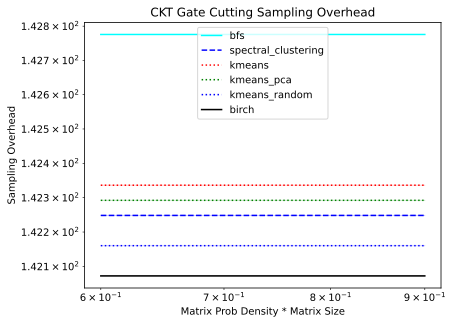

In [44]:
clustering_methods = ['bfs','spectral_clustering','kmeans','kmeans_pca','kmeans_random','birch']#,'agglom']

x = df_large['p']* df_large['n']
colors = ['cyan', 'blue', 'red', 'green', 'blue', 'black', 'orange']
linestyles = ['solid', 'dashed', 'dotted', 'dotted',':', '-', '-.']
hue = df_large['max_cluster_size'].values

#ygerr = df_std[cm]['ER Graph Largest Component']

for i,cm in enumerate(clustering_methods):
    y = df_large[cm].apply(lambda x1: np.log(x1)).mean()
    sns.lineplot(x=x, y=y, color=colors[i], linestyle=linestyles[i] , label=cm)#, hue_order=hue_order ,
   
plt.title('CKT Gate Cutting Sampling Overhead')
plt.xlabel('Matrix Prob Density * Matrix Size')
plt.ylabel('Sampling Overhead')
plt.yscale('log')
plt.xscale('log')
plt.legend()

####  Move instruction

1. find self-fragmenting sub-circuits
2. create qaoa for smaller sub-circuits
3. for the sub-circuits larger than the max-size, split them based on Spectral/Markovian chain clustering method
    - a. create qaoa for each of these clusters
    - b. insert move between them - capture the move position

#### Multiple Runs

In [163]:
def mc_move(max_cluster_size, qsubgraph_prop):
    ##append sub-circuits based on their size- if larger than max size, cut further else keep as is  
    graph_mat = []
    move_pos = []
    for j, key in enumerate(qsubgraph_prop.keys()):
        if len(key)>max_cluster_size:
            key_dict = {}
            for i, k in enumerate(key):
                key_dict[i] = k

            #cut the circuit further
            subgraph_mat = qsubgraph_prop[key]
            result = mc.run_mcl(subgraph_mat)
            mclbl = mc.get_clusters(result)
            prev_pos = 0
            for m, lbl in enumerate(mclbl):
                print(f'subgraph : {list(lbl)}') # this lbl is from markov - convert this to original mapping
                updated_lbl = [key_dict[k_] for k_ in lbl] ## Check: not sure if I really need keep track of the original qubit mapping
                graph_mat.append(subgraph_mat[np.ix_(list(lbl),list(lbl))])
                if m<len(mclbl)-1:
                    move_pos.append(j+len(lbl)+prev_pos)
                    prev_pos += len(lbl) 
        else:
            #append the circuit to list of qaoas
            graph_mat.append(qsubgraph_prop[key])

    return graph_mat, move_pos


def create_qaoa_for_mc_clusters(n,graph_mat):
    qaoa_list = []
    qc = QuantumCircuit(n)
    cnt = 0
    param_keys = list(greek_alphabet.keys())
    for m in graph_mat:
        #print(m)
        qp = create_qp_from_qmatrix(m)
        qaoa = create_qaoa_ansatz(qp)
        params = qaoa.parameters
        #print(params)
        param = {}
        for p in (params):
            cnt += 1
            param[p] = Parameter(param_keys[cnt])
        qaoa_list.append(qaoa.to_instruction(param))

    return qaoa_list
  

def compose_circuit_with_move(num_qubits, qaoa_list, move_pos):
    #find the extra qubits required for move instructions
    extra_qbits = len(move_pos)

    #compose the new circuit with qaoas for sub-circuits and move instruction between them
    qr = QuantumRegister(num_qubits)
    larger_qc = QuantumCircuit(qr)
    qc = QuantumCircuit()
    qubit_pos = 0
    partition_lbl_str = []
    for i, q in enumerate(qaoa_list):
        qubit_num = q.num_qubits
        for l in range(qubit_num):
            partition_lbl_str.append(labels[i])

        if i==0:
            #print(np.arange(qubit_pos, qubit_pos+qubit_num+1))
            qc = larger_qc.compose(q, qubits= np.arange(qubit_pos, qubit_pos+qubit_num).tolist())
        else:
            #print(f'qubit_pos:{qubit_pos}')
            qc = qc.compose(q, qubits=np.arange(qubit_pos, qubit_pos+qubit_num).tolist())
        qubit_pos = qubit_pos+qubit_num

        if qubit_pos in move_pos:
            #TODO: is the move required for disconnected sub-circuits???
            qc.append(Move(), [qubit_pos-1, qubit_pos])

    partition_label_string = ''.join(partition_lbl_str)
    return  qc, partition_label_string 

def ckt_partition_move(qc, partition_label_string, observables):
    partitioned_problem = partition_problem(
        circuit=qc, partition_labels=partition_label_string, observables=observables
    )
    subcircuits = partitioned_problem.subcircuits
    subobservables = partitioned_problem.subobservables
    bases = partitioned_problem.bases
    return np.prod([basis.overhead for basis in bases])


def ckt_move_mc(mat_size, prob, random_seeds, max_cluster_sizes):
    
    cols = ['n', 'p', 'seed', 'max_cluster_size', 'M', 'qsubgraph_prop',
            'partition_labels','sampling_overhead', 'sampling_overhead/max_cluster' ,
           'sampling_overhead/p']
    
    df = pd.DataFrame(columns=cols)
    i = 0
    for n in mat_size:
        for p in (prob): 
            for seed in random_seeds:
                M=sprandsym(n,p,seed)
                M=binarize_sparse_matrix(M)
                q=generate_graph_from_matrix(M)
                qnum_sub_graphs, largest_subgraph_size, qsubgraph_prop, max_subgraph_nodes = get_subgraph_properties1(q)
                #print(max_subgraph_nodes)

                ## qaoa for original circuit
                qp = create_qp_from_qmatrix(M)
                qp2qubo = QuadraticProgramToQubo()
                qubo = qp2qubo.convert(qp)
                qubitOp, offset = qubo.to_ising()

                qaoa = QAOAAnsatz(cost_operator=qubitOp,reps=1)
                qaoa_decomposed = qaoa.decompose().decompose().decompose().decompose()

                qaoa_observable_pat = '[A-Z]+'
                observables = PauliList(re.findall(qaoa_observable_pat, str(qubitOp)))
                #print(observables)

                for max_cluster_size in max_cluster_sizes:
                    i += 1
                    #sc partition
                    graph_mat, move_pos = mc_move(max_cluster_size, qsubgraph_prop)
                    qaoa_list = create_qaoa_for_mc_clusters(max_cluster_size, graph_mat)
                    qc, partition_labels = compose_circuit_with_move(n, qaoa_list, move_pos)
                    #print(f'qubit: {qc.num_qubits}')
                    sampling_overhead = ckt_partition_move(qc, partition_labels, observables)
                    print(f'\nPartition labels for CKT: {partition_labels}')
                    print(f'sampling_overhead:{sampling_overhead}')
                    
                    df.loc[i,'n'] = n
                    df.loc[i,'p'] = p
                    df.loc[i,'seed'] = seed
                    df.loc[i,'max_cluster_size'] = max_cluster_size
                    #df['M'] = M
                    df.loc[i,'qsubgraph_prop'] = [qsubgraph_prop]
                    df.loc[i,'partition_labels'] = partition_labels
                    df.loc[i,'sampling_overhead'] = sampling_overhead
                    df.loc[i,'sampling_overhead/max_cluster'] = sampling_overhead/max_cluster_size
                    df.loc[i,'sampling_overhead/p'] = sampling_overhead/p
    return df
  
 

In [168]:
#matrix_sizes =  [15,20]#,50,75,100]
#matrix_densities = [0.09,0.07,0.1,0.2,0.25,0.27] #[0.20,0.30,0.40,0.50,0.60,0.70]

matrix_sizes =  [15,20,25]#,50,75,100]
matrix_densities = [0.1,0.2, 0.3]#[0.05,0.07]#,0.1,0.2,0.25,0.27] #[0.20,0.30,0.40,0.50,0.60,0.70]

num_of_experiments = 20
random_seeds = [random.randint(3000, 10000) for _ in range(num_of_experiments)]
max_cluster_sizes = [3,5,7]


df_mc = ckt_move_mc(matrix_sizes, matrix_densities, random_seeds, max_cluster_sizes)


subgraph : [0, 4, 6]
subgraph : [1, 7]
subgraph : [2, 3, 5]

Partition labels for CKT: AAABBCCCDEFGGHI
sampling_overhead:256.0
subgraph : [0, 4, 6]
subgraph : [1, 7]
subgraph : [2, 3, 5]

Partition labels for CKT: AAABBCCCDEFGGHI
sampling_overhead:256.0
subgraph : [0, 4, 6]
subgraph : [1, 7]
subgraph : [2, 3, 5]

Partition labels for CKT: AAABBCCCDEFGGHI
sampling_overhead:256.0
subgraph : [0, 7]
subgraph : [1, 5, 6, 8]
subgraph : [2, 3, 4]

Partition labels for CKT: AABBBBCCCDDDEFG
sampling_overhead:256.0
subgraph : [0, 7]
subgraph : [1, 5, 6, 8]
subgraph : [2, 3, 4]

Partition labels for CKT: AABBBBCCCDDDEFG
sampling_overhead:256.0
subgraph : [0, 7]
subgraph : [1, 5, 6, 8]
subgraph : [2, 3, 4]

Partition labels for CKT: AABBBBCCCDDDEFG
sampling_overhead:256.0
subgraph : [0, 1, 5]
subgraph : [2, 3, 4]
subgraph : [0, 1]
subgraph : [2, 3]

Partition labels for CKT: AAABBBCCDDEEFGH
sampling_overhead:16.0
subgraph : [0, 1, 5]
subgraph : [2, 3, 4]

Partition labels for CKT: AAABBBCCCCDDEFG


CircuitError: 'Index 15 out of range for size 15.'

In [166]:
mc_x = df_mc['p'].values
mc_y = df_mc['sampling_overhead'].apply(lambda x: np.log(x)).values
mc_hue = df_mc['max_cluster_size'].values
mc_hue_order = df_mc['max_cluster_size'].values
mc_style = df_mc['n'].values

sns.lineplot(x=mc_x, y=mc_y, hue=mc_hue)#, hue_order=mc_hue_order)#, style=mc_style)
plt.title('Matrix Density Vs Sampling Overhead')
plt.xlabel('Matrix Prob Density')
plt.ylabel('Sampling Overhead')
plt.yscale('log')

NameError: name 'df_mc' is not defined

#### Individual Run

In [6]:
matrix_sizes =  [20] #25,50,75,100]
matrix_densities = [0.07]#,0.07,0.1,0.2,0.25,0.27] #[0.20,0.30,0.40,0.50,0.60,0.70]
num_of_experiments = 1
random_seeds = [random.randint(300, 1000) for _ in range(num_of_experiments)]
max_cluster_sizes = [3]#,5,7]


In [7]:
matrix_sizes =  [20] #25,50,75,100]
matrix_densities = [0.07]#,0.07,0.1,0.2,0.25,0.27] #[0.20,0.30,0.40,0.50,0.60,0.70]
num_of_experiments = 1
random_seeds = [random.randint(300, 1000) for _ in range(num_of_experiments)]
max_cluster_sizes = [3]#,5,7]

n=matrix_sizes[0]
p=matrix_densities[0]
seed = [random.randint(300, 1000) for _ in range(num_of_experiments)][0]

max_cluster_size = max_cluster_sizes[0]

M=sprandsym(n,p,seed)
M=binarize_sparse_matrix(M)
q=generate_graph_from_matrix(M)
qnum_sub_graphs, largest_subgraph_size, qsubgraph_prop, max_subgraph_nodes = get_subgraph_properties1(q)


/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_52015/1484174532.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  subgraph_prop[n] = nx.adjacency_matrix(s).todense()


In [8]:
qsubgraph_prop[tuple(max_subgraph_nodes)]

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [13]:
subgraph_mat = qsubgraph_prop[tuple(max_subgraph_nodes)]
result = mc.run_mcl(subgraph_mat)
mclbl = mc.get_clusters(result)

In [14]:
mclbl

[(0, 2, 8, 11), (1, 5, 6), (3, 4, 7), (9, 10, 12)]

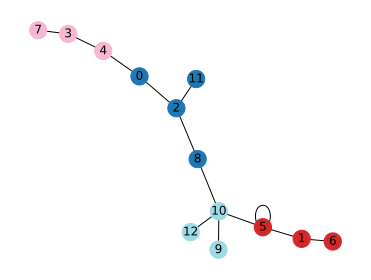

In [15]:
mc.draw_graph(subgraph_mat, mclbl)#, pos=positions, node_size=50, with_labels=False, edge_color="silver")


#### Apply Markov Chain Clustering to find the subgraphs for large subgraph (size> no. of qubits) and determine the Move instruction's positions

In [32]:
max_cluster_size

3

In [23]:
# find the right place for move instruction
# how about convertng the circuit to instruction and then manually editing the instruction string to add the move

##append sub-circuits based on their size- if larger than max size, cut further else keep as is  
graph_mat = []
move_pos = []
for j, key in enumerate(qsubgraph_prop.keys()):
    if len(key)>max_cluster_size:
        print(f'len of key: {len(key)}')
        key_dict = {}
        for i, k in enumerate(key):
            key_dict[i] = k
            
        #cut the circuit further
        subgraph_mat = qsubgraph_prop[key]
        result = mc.run_mcl(subgraph_mat)
        mclbl = mc.get_clusters(result)
        prev_pos = 0
        for m, lbl in enumerate(mclbl):
            #TODO: Any cluster larger than the max_cluster_size should be iteratively broken down 
            print(f'subgraph : {list(lbl)}') # this lbl is from markov - convert this to original mapping
            updated_lbl = [key_dict[k_] for k_ in lbl] ## Check: not sure if I really need keep track of the original qubit mapping
            graph_mat.append(subgraph_mat[np.ix_(list(lbl),list(lbl))])
            if m<len(mclbl)-1:
                print(f'j: {j}')
                print(f'm:{m}')
                move_pos.append(j+len(lbl)+prev_pos)
                prev_pos += len(lbl) 
    else:
        #append the circuit to list of qaoas
        graph_mat.append(qsubgraph_prop[key])
        


move_pos
graph_mat   

len of key: 7
subgraph : [0, 1, 2, 3, 4]
j: 0
m:0
subgraph : [5, 6]


[array([[0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 1.],
        [1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [1., 1., 1., 1., 0.]]),
 array([[0., 1.],
        [1., 0.]]),
 array([[0.]]),
 array([[0., 1.],
        [1., 0.]]),
 array([[0.]]),
 array([[0., 1., 1.],
        [1., 0., 0.],
        [1., 0., 0.]]),
 array([[0., 1.],
        [1., 0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.]])]

In [24]:
move_pos

[5]

#### Construct the qaoa ansatz for each of the identified subgraphs and rename the circuit parameters 

In [25]:
qaoa_list = []
qc = QuantumCircuit(n)
cnt = 0
param_keys = list(greek_alphabet.keys())
for m in graph_mat:
    #print(m)
    qp = create_qp_from_qmatrix(m)
    qaoa = create_qaoa_ansatz(qp)
    params = qaoa.parameters
    #print(params)
    param = {}
    for p in (params):
        cnt += 1
        param[p] = Parameter(param_keys[cnt])
    qaoa_list.append(qaoa.to_instruction(param))

qaoa_list

[Instruction(name='QAOA', num_qubits=5, num_clbits=0, params=[Parameter(δ), Parameter(ε)]),
 Instruction(name='QAOA', num_qubits=2, num_clbits=0, params=[Parameter(ζ), Parameter(η)]),
 Instruction(name='QAOA', num_qubits=1, num_clbits=0, params=[Parameter(θ)]),
 Instruction(name='QAOA', num_qubits=2, num_clbits=0, params=[Parameter(ι), Parameter(κ)]),
 Instruction(name='QAOA', num_qubits=1, num_clbits=0, params=[Parameter(λ)]),
 Instruction(name='QAOA', num_qubits=3, num_clbits=0, params=[Parameter(μ), Parameter(ν)]),
 Instruction(name='QAOA', num_qubits=2, num_clbits=0, params=[Parameter(ξ), Parameter(ο)]),
 Instruction(name='QAOA', num_qubits=1, num_clbits=0, params=[Parameter(π)]),
 Instruction(name='QAOA', num_qubits=1, num_clbits=0, params=[Parameter(ρ)]),
 Instruction(name='QAOA', num_qubits=1, num_clbits=0, params=[Parameter(σ)]),
 Instruction(name='QAOA', num_qubits=1, num_clbits=0, params=[Parameter(τ)])]

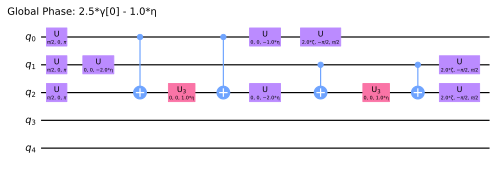

In [25]:
qaoa_list[0]
qc = QuantumCircuit(5)
qc.compose(qaoa_list[1]).decompose().decompose().decompose().draw(scale=0.6)

#### Compose the new circuit with the individual qaoas and move instructions, find the partition label string

qubit_num: 1
qubit_num: 3
qubit_num: 6
qubit_num: 2
qubit_num: 2
qubit_num: 1
qubit_num: 3
qubit_num: 1
qubit_num: 1


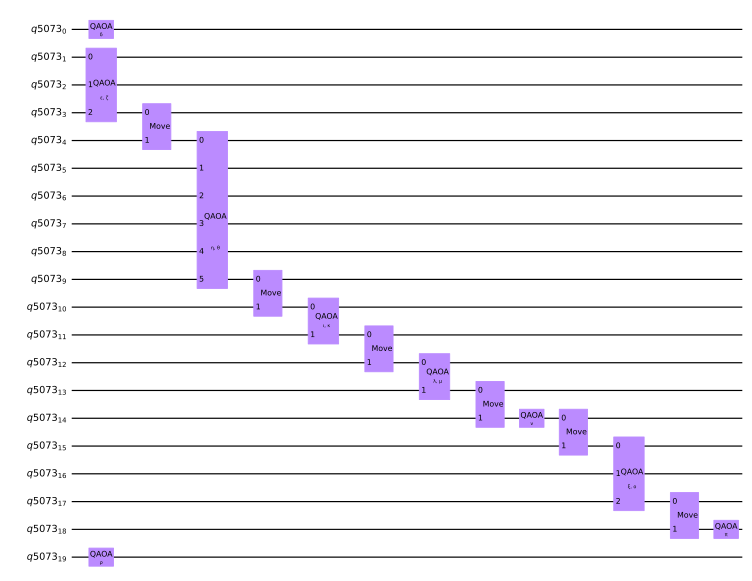

In [33]:
#find the extra qubits required for move instructions
extra_qbits = len(move_pos)

#compose the new circuit with qaoas for sub-circuits and move instruction between them
qr = QuantumRegister(n)
larger_qc = QuantumCircuit(qr)
qc = QuantumCircuit()
qubit_pos = 0
partition_lbl_str = []
for i, q in enumerate(qaoa_list):
    #print(f'qubit_pos: {qubit_pos}')
    #print(partition_lbl_str)
        
    qubit_num = q.num_qubits
    print(f'qubit_num: {qubit_num}')
    for l in range(qubit_num):
        partition_lbl_str.append(labels[i])
        
    if i==0:
        #print(np.arange(qubit_pos, qubit_pos+qubit_num+1))
        qc = larger_qc.compose(q, qubits= np.arange(qubit_pos, qubit_pos+qubit_num).tolist())
    else:
        qc = qc.compose(q, qubits=np.arange(qubit_pos, qubit_pos+qubit_num).tolist())
    qubit_pos = qubit_pos+qubit_num
    
    
    if qubit_pos in move_pos:
        #TODO: is the move required for disconnected sub-circuits???
        qc.append(Move(), [qubit_pos-1, qubit_pos])

partition_label_string = ''.join(partition_lbl_str)
qc.draw(scale=0.6)  
    

In [26]:
from circuit_knitting.cutting.instructions import CutWire
from circuit_knitting.cutting import cut_wires, expand_observables

In [34]:
qc.parameters

ParameterView([Parameter(δ), Parameter(ε), Parameter(ζ), Parameter(η), Parameter(θ), Parameter(ι), Parameter(κ), Parameter(λ), Parameter(μ), Parameter(ν), Parameter(ξ), Parameter(ο), Parameter(π), Parameter(ρ)])

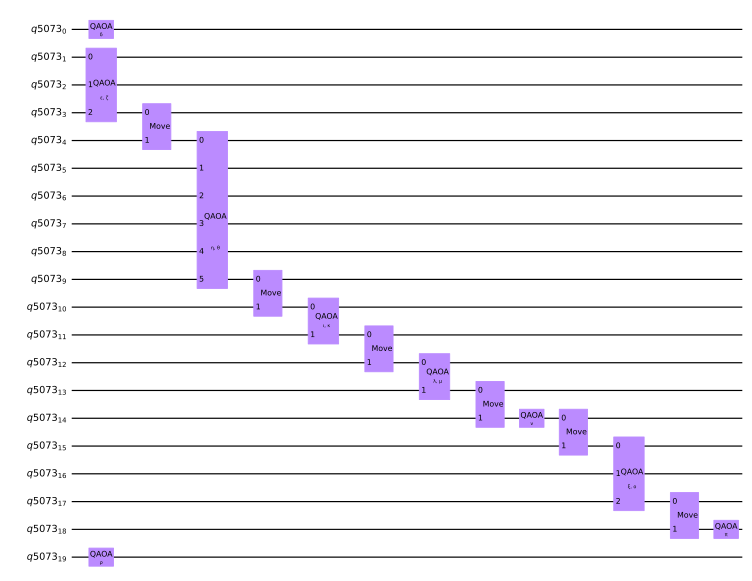

In [36]:
qc.draw(scale=0.6)

#### Get the observable for the original QAOA Ansatz

In [37]:
qp = create_qp_from_qmatrix(M)
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
qaoa_full_circuit = create_qaoa_ansatz(qp)
#qaoa_full_circuit.decompose().decompose().decompose().decompose().draw(scale=0.5)

In [38]:
qubitOp

PauliSumOp(SparsePauliOp(['IIIIIIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIZIIIIIZI', 'IIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIZIIIIIIIZI', 'IIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIZIIIZIIIII', 'IIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIZZIIIIIIII', 'IIIIIIIIIIIZIIIIIIII', 'IIIIIIIIZIIIIIIIZIII', 'IIIIIIIIZIIIIIIIIIII', 'IIIIIIIZIIIZIIIIIIII', 'IIIIIIIZIIIIIIIIIIII', 'IIIIIIIZIZIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIZI', 'IIIIIIZIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIZII', 'IIIIIZIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIZII', 'IIIZIIIIIIIIIIIIIIZI', 'IIIZIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIZIIIII', 'IIZIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIZIIIIII', 'IIZIIIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIZII', 'IZIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIZIIIIIII', 'ZIIIIIIIIIIIIIIIIZII', 'ZIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIZIIIIII'],
              coeffs=[-1. +0.j, -1. +0.j,  0.5+0.j, -2.5+0.j,

In [40]:
obs = PauliList(['IIIIIIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIZIIIIIZI', 'IIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIZIIIIIIIZI', 'IIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIZIIIZIIIII', 'IIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIZZIIIIIIII', 'IIIIIIIIIIIZIIIIIIII', 'IIIIIIIIZIIIIIIIZIII', 'IIIIIIIIZIIIIIIIIIII', 'IIIIIIIZIIIZIIIIIIII', 'IIIIIIIZIIIIIIIIIIII', 'IIIIIIIZIZIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIZI', 'IIIIIIZIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIZII', 'IIIIIZIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIZII', 'IIIZIIIIIIIIIIIIIIZI', 'IIIZIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIZIIIII', 'IIZIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIZIIIIII', 'IIZIIIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIZII', 'IZIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIZIIIIIII', 'ZIIIIIIIIIIIIIIIIZII', 'ZIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIZIIIIII'])

#### Find the partitioning sampling overhead

In [41]:
partitioned_problem = partition_problem(
    circuit=qc, partition_labels=partition_label_string, observables=obs
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

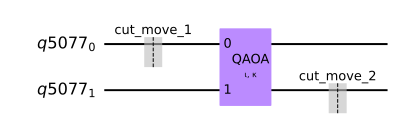

In [42]:
subcircuits["D"].draw("mpl")

In [43]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 16777216.0


#### Cut Wire

In [198]:
matrix_sizes =  [10] #25,50,75,100]
matrix_densities = [0.1]#,0.07,0.1,0.2,0.25,0.27] #[0.20,0.30,0.40,0.50,0.60,0.70]
num_of_experiments = 1
random_seeds = [random.randint(300, 1000) for _ in range(num_of_experiments)]
max_cluster_sizes = [2]#,5,7]


In [199]:
n=matrix_sizes[0]
p=matrix_densities[0]
seed = [random.randint(300, 1000) for _ in range(num_of_experiments)][0]

max_cluster_size = max_cluster_sizes[0]

M=sprandsym(n,p,seed)
M=binarize_sparse_matrix(M)
q=generate_graph_from_matrix(M)
qnum_sub_graphs, largest_subgraph_size, qsubgraph_prop, max_subgraph_nodes = get_subgraph_properties1(q)


In [200]:
qsubgraph_prop

{(0,
  1,
  2,
  4,
  9): array([[0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [1., 1., 0., 0., 0.],
        [1., 0., 1., 0., 0.]]),
 (3,): array([[0.]]),
 (8,
  5): array([[0., 1.],
        [1., 0.]]),
 (6,): array([[0.]]),
 (7,): array([[0.]])}

In [201]:
subgraph_mat = qsubgraph_prop[tuple(max_subgraph_nodes)]
result = mc.run_mcl(subgraph_mat)
mclbl = mc.get_clusters(result)

In [202]:
mclbl

[(0, 1, 3), (0, 2, 4)]

In [203]:
q

In [204]:
subgraph_mat = qsubgraph_prop[tuple(max_subgraph_nodes)]


In [205]:
subgraph_mat

array([[0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0.]])

In [206]:
tuple(max_subgraph_nodes)

(0, 1, 2, 4, 9)

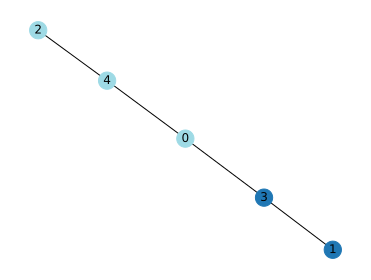

In [207]:
mc.draw_graph(subgraph_mat, mclbl)

In [208]:
B_graph = nx.from_numpy_array(subgraph_mat)

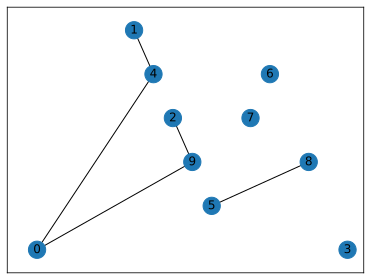

Graph with 10 nodes and 5 edges


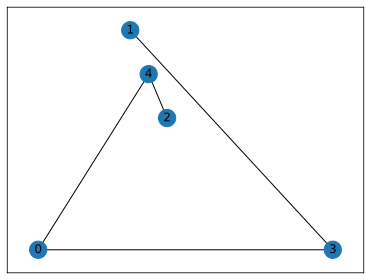

In [209]:
G = nx.from_scipy_sparse_array(M)
pos = nx.planar_layout(G)
s = G.subgraph(range(G.order()))
nx.draw_networkx(s, pos=pos)
pl.show()
print(s)

#pos = nx.spring_layout(B_graph)
#s = G.subgraph(range(G.order()))
nx.draw_networkx(B_graph, pos=pos,)
pl.show()



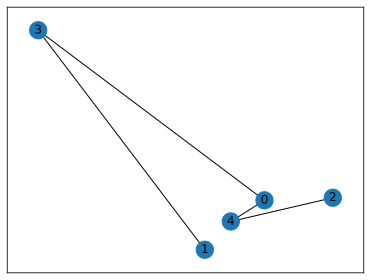

In [210]:
B_graph = nx.from_numpy_array(subgraph_mat)
pos = nx.spring_layout(G)
s = G.subgraph(range(G.order()))
nx.draw_networkx(B_graph, pos=pos)
pl.show()


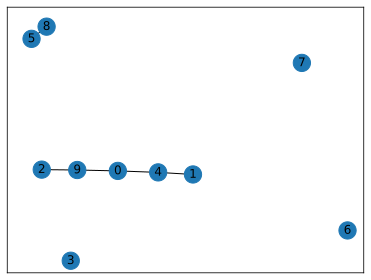

Graph with 10 nodes and 5 edges


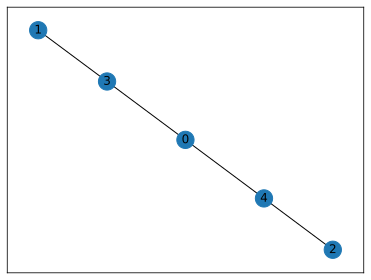

In [211]:
pos = nx.spring_layout(G)
s = G.subgraph(range(G.order()))
nx.draw_networkx(s, pos=pos)
pl.show()
print(s)

pos = nx.spring_layout(B_graph)
#s = G.subgraph(range(G.order()))
nx.draw_networkx(B_graph, pos=pos)
pl.show()

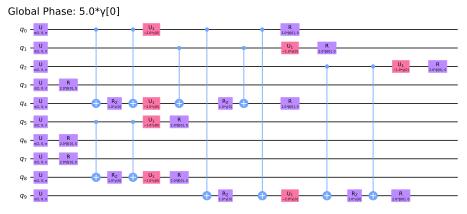

In [212]:
qp = create_qp_from_qmatrix(M)
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

qaoa = QAOAAnsatz(cost_operator=qubitOp,reps=1)
qaoa_decomposed = qaoa.decompose().decompose().decompose().decompose()
qaoa_decomposed.draw(scale=0.4)

In [213]:
qubitOp

PauliSumOp(SparsePauliOp(['IIIIIZIIIZ', 'IIIIIIIIIZ', 'IIIIIZIIII', 'IIIIIZIIZI', 'IIIIIIIIZI', 'IZIIZIIIII', 'IIIIZIIIII', 'IZIIIIIIII', 'ZIIIIIIIIZ', 'ZIIIIIIIII', 'ZIIIIIIZII', 'IIIIIIIZII'],
              coeffs=[ 0.5+0.j, -1. +0.j, -1. +0.j,  0.5+0.j, -0.5+0.j,  0.5+0.j, -0.5+0.j,
 -0.5+0.j,  0.5+0.j, -1. +0.j,  0.5+0.j, -0.5+0.j]), coeff=1.0)

In [214]:
subgraph_mat

array([[0., 0., 0., 1., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0.]])

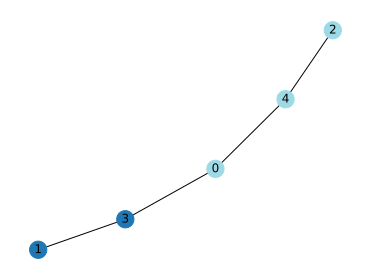

In [215]:
mc.draw_graph(subgraph_mat, mclbl)

In [216]:
max_cluster_size = 2

In [293]:
def mc_cutwire(max_cluster_size, qsubgraph_prop):
    ##append sub-circuits based on their size- if larger than max size, cut further else keep as is  
    graph_mat = []
    cut_pos = []
    for j, key in enumerate(qsubgraph_prop.keys()):
        if len(key)>max_cluster_size:
            key_dict = {}
            print(f'key exceeding max len: {key}')
            for i, k in enumerate(key):
                key_dict[i] = k

            #cut the circuit further
            subgraph_mat = qsubgraph_prop[key]
            print(subgraph_mat)
            result = mc.run_mcl(subgraph_mat, inflation=2.4)
            mclbl = mc.get_clusters(result)
            
            prev_pos = 0
            for m, lbl in enumerate(mclbl):
                print(f'subgraph : {list(lbl)}') # this lbl is from markov - convert this to original mapping
                updated_lbl = [key_dict[k_] for k_ in lbl] ## Check: not sure if I really need keep track of the original qubit mapping
                print(f'updated_lbl: {updated_lbl}')
                
                #TODO: iterate the sub-clusters further to break-down any sub cluster size>max-cluster-size
                #TODO: Keep track of the edges where the move/cut wire instruction should be placed
                graph_mat.append(subgraph_mat[np.ix_(list(lbl),list(lbl))])
                
                ##Determine the cut wire position
                # 1. scan the row. are there more than 1 1s?
                # 2. if yes, do they belong to the same sub-cluster?
                # 3. if no, place the cut wire instruction
                
                if m<len(mclbl)-1:
                    for i in range(subgraph_mat.shape[0]):
                        #print(subgraph_mat[i,:])
                        a = np.array(subgraph_mat[i,:])
                        idx = np.where(subgraph_mat[i,:]==1)
                        print(f'dict: {key_dict}')
                        conn_nodes = []
                        for x in idx:
                            print(x)
                            conn_nodes.append(i)
                            for y in range(len(x)):
                                print(key_dict[x[y]])
                                conn_nodes.append(key_dict[x[y]])
                            
                        print(f'final:{conn_nodes}')
                        
                        #check if conn nodes are in updated label - they belong to same cluster, if not, diff cluster
                        print(f'diff: {list(set(conn_nodes) - set(updated_lbl))}')
                        
                        if list(set(conn_nodes) - set(updated_lbl)):
                            cut_pos.append(m)
                    prev_pos += len(lbl) 
        else:
            #append the circuit to list of qaoas
            graph_mat.append(qsubgraph_prop[key])

    return graph_mat, cut_pos

In [294]:
graph_mat, cut_pos = mc_cutwire(max_cluster_size,qsubgraph_prop)

key exceeding max len: (0, 1, 2, 4, 9)
[[0. 0. 0. 1. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]]
subgraph : [0, 1, 3]
updated_lbl: [0, 1, 4]
dict: {0: 0, 1: 1, 2: 2, 3: 4, 4: 9}
[3 4]
4
9
final:[0, 4, 9]
diff: [9]
dict: {0: 0, 1: 1, 2: 2, 3: 4, 4: 9}
[3]
4
final:[1, 4]
diff: []
dict: {0: 0, 1: 1, 2: 2, 3: 4, 4: 9}
[4]
9
final:[2, 9]
diff: [9, 2]
dict: {0: 0, 1: 1, 2: 2, 3: 4, 4: 9}
[0 1]
0
1
final:[3, 0, 1]
diff: [3]
dict: {0: 0, 1: 1, 2: 2, 3: 4, 4: 9}
[0 2]
0
2
final:[4, 0, 2]
diff: [2]
subgraph : [0, 2, 4]
updated_lbl: [0, 2, 9]


In [295]:
#mc.draw_graph(subgraph_mat, updated_lbl)

In [296]:
graph_mat

[array([[0., 0., 1.],
        [0., 0., 1.],
        [1., 1., 0.]]),
 array([[0., 0., 1.],
        [0., 0., 1.],
        [1., 1., 0.]]),
 array([[0.]]),
 array([[0., 1.],
        [1., 0.]]),
 array([[0.]]),
 array([[0.]])]

In [299]:
set(cut_pos)

{0}

In [300]:
qaoa_list = []
qc = QuantumCircuit(n)
cnt = 0
param_keys = list(greek_alphabet.keys())
for m in graph_mat:
    #print(m)
    qp = create_qp_from_qmatrix(m)
    qaoa = create_qaoa_ansatz(qp)
    params = qaoa.parameters
    print(params)
    params_len = len(params)
    param = {}
    for p in (params):
        print(p)
        cnt += 1
        param[p] = Parameter(param_keys[cnt])
        
        #theta_range = np.linspace(0, np.pi, params_len)
        #print(theta_range)
        #qaoa_qc = qaoa.bind_parameters()

        
    qaoa_list.append(qaoa.to_instruction(param))

qaoa_list

ParameterView([])
ParameterView([])
ParameterView([])
ParameterView([])
ParameterView([])
ParameterView([])


[Instruction(name='QAOA-190', num_qubits=3, num_clbits=0, params=[]),
 Instruction(name='QAOA-192', num_qubits=3, num_clbits=0, params=[]),
 Instruction(name='QAOA-194', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='QAOA-196', num_qubits=2, num_clbits=0, params=[]),
 Instruction(name='QAOA-198', num_qubits=1, num_clbits=0, params=[]),
 Instruction(name='QAOA-200', num_qubits=1, num_clbits=0, params=[])]

In [303]:
n

10

In [302]:
qubit_pos, qubit_pos+qubit_num

(10, 11)

In [309]:
#compose the new circuit with qaoas for sub-circuits and cut wire instruction between them
qr = QuantumRegister(n)
larger_qc = QuantumCircuit(qr)
qc = QuantumCircuit()
qubit_pos = 0
partition_lbl_str = []
for i, q in enumerate(qaoa_list):
    #print(f'qubit_pos: {qubit_pos}')
    #print(partition_lbl_str)
        
    qubit_num = q.num_qubits
    print(f'qubit_num: {qubit_num}')
    for l in range(qubit_num):
        partition_lbl_str.append(labels[i])
        
    if i==0:
        #print(np.arange(qubit_pos, qubit_pos+qubit_num+1))
        qc = larger_qc.compose(q, qubits= np.arange(qubit_pos, qubit_pos+qubit_num).tolist())
    else:
        qc = qc.compose(q, qubits=np.arange(qubit_pos, qubit_pos+qubit_num).tolist())
    qubit_pos = qubit_pos+qubit_num
    
    
    if qubit_pos in cut_pos:
        #TODO: is the move required for disconnected sub-circuits???
        qc.append(CutWire(), [qubit_pos])

partition_label_string = ''.join(partition_lbl_str)
qc.draw(scale=0.6)  

qubit_num: 3


CircuitError: 'The amount of qubit(0)/clbit(0) arguments does not match the gate expectation (1).'

In [182]:
partition_label_string

'AAABBBCDEF'

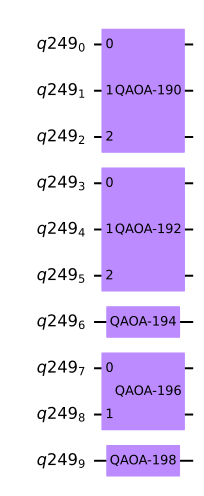

In [306]:
qc.decompose("cut_wire").draw("mpl")


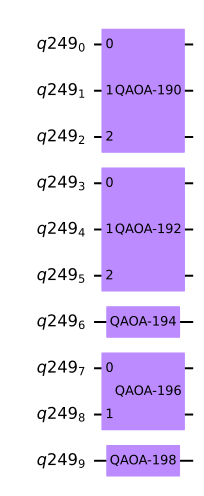

In [307]:
#transform cut wires to move
qc_1 = cut_wires(qc)
qc_1.draw("mpl")

In [185]:
qaoa_observable_pat = '[A-Z]+'
observables_0 = PauliList(re.findall(qaoa_observable_pat, str(qubitOp)))

In [186]:
observables_1 = expand_observables(observables_0, qc, qc_1)
observables_1


PauliList(['IIIIIIIIZIII', 'IIIIIIIZIIII', 'IIIIIIZIIIII',
           'IIIIZIIIIIII', 'IIIIIIZIIIIZ', 'IIIIIIIIIIIZ',
           'IIIIIIZIIIZI', 'IIIIIIIIIIZI', 'IIIZIIIIIIZI',
           'IIIZIIIIIIII', 'IIIZIIIZIIII', 'IIZIIIIIIIIZ',
           'IIZIIIIIIIII', 'IIZIIIIIZIII'])

In [187]:
partitioned_problem = partition_problem(circuit=qc_1, observables=observables_1)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables

In [188]:
subobservables

{0: PauliList(['III', 'III', 'III', 'III', 'IIZ', 'IIZ', 'IZI', 'IZI', 'IZI',
            'III', 'III', 'IIZ', 'III', 'III']),
 1: PauliList(['Z', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
            'I', 'Z']),
 2: PauliList(['III', 'IIZ', 'IZI', 'III', 'IZI', 'III', 'IZI', 'III', 'III',
            'III', 'IIZ', 'III', 'III', 'III']),
 3: PauliList(['I', 'I', 'I', 'Z', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
            'I', 'I']),
 4: PauliList(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'Z', 'Z', 'Z', 'I',
            'I', 'I']),
 5: PauliList(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'Z',
            'Z', 'Z']),
 6: PauliList(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
            'I', 'I']),
 7: PauliList(['I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I',
            'I', 'I'])}

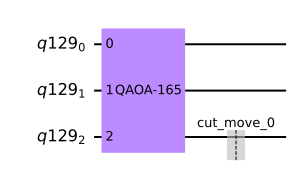

In [191]:
subcircuits[0].draw("mpl")

In [192]:
subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=np.inf,
)


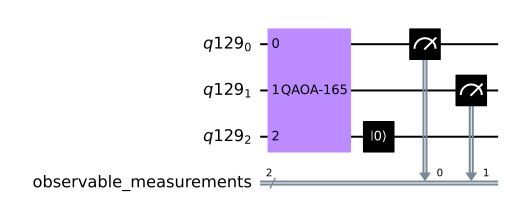

In [315]:
subexperiments[0][0].draw()

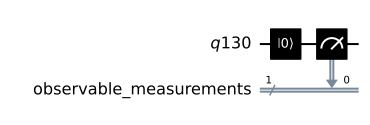

In [316]:
subexperiments[1][0].draw()

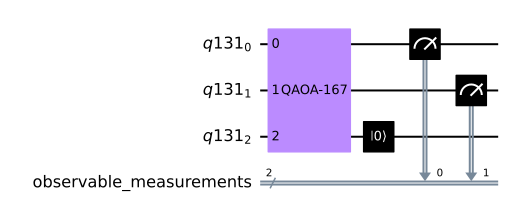

In [317]:
subexperiments[2][0].draw()

In [194]:
sampler = Sampler(run_options={"shots": 2**12})
results = {
    label: sampler.run(subexperiment).result()
    for label, subexperiment in subexperiments.items()
}


ValueError: The 0-th circuit does not have any classical bit. Sampler requires classical bits, plus measurements on the desired qubits.

In [ ]:
qr = QuantumRegister(n)
larger_qc = QuantumCircuit(qr)

qc = larger_qc.compose(qaoa_list[0])

qc.append(Move(), [2, 3])

qc1 = qc.compose(qaoa1, qubits=[3,4,5,6,7])

qc1.append(Move(), [7, 8])

qc2 = qc1.compose(qaoa2, qubits=[8])

qc2.append(Move(), [7, 8])

qc3 = qc2.compose(qaoa3, qubits=[9])
qc3.draw(scale=0.6)

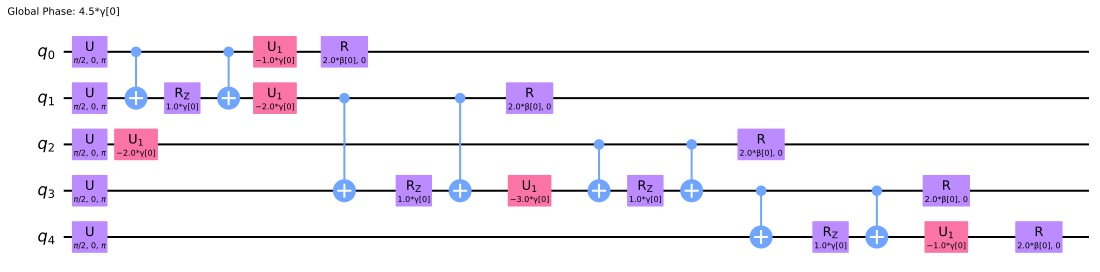

In [157]:
qaoa_list[1].draw()

In [160]:
param = qaoa_list[2].parameters[0]
param

ParameterVectorElement(β[0])

In [160]:
from qiskit.circuit import Parameter

theta = Parameter('theta')
qaoa2 = qaoa_list[2].to_instruction({param:theta})

In [161]:
qaoa2

Instruction(name='QAOA', num_qubits=1, num_clbits=0, params=[Parameter(theta)])

In [162]:
qaoa_list[1].parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])

In [163]:
param1 = qaoa_list[1].parameters[0]
param2 = qaoa_list[1].parameters[1]

In [164]:
alpha = Parameter('alpha')
phi = Parameter('phi')
qaoa1 = qaoa_list[1].to_instruction({param1:alpha, param2:phi})

In [165]:
param3 = qaoa_list[3].parameters[0]
delta = Parameter('delta')
qaoa3 = qaoa_list[3].to_instruction({param3:delta})    

In [166]:
max_size

5

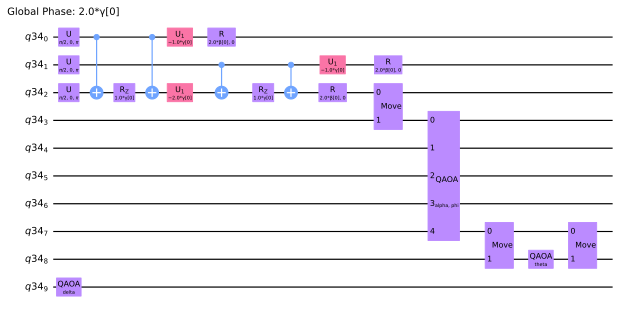

In [167]:
#TODO: extra qubit required for the move - direction flow of info - to check - if flipping is required in our case
qr = QuantumRegister(n)
larger_qc = QuantumCircuit(qr)
qc = larger_qc.compose(qaoa_list[0])

qc.append(Move(), [2, 3])

qc1 = qc.compose(qaoa1, qubits=[3,4,5,6,7])

qc1.append(Move(), [7, 8])

qc2 = qc1.compose(qaoa2, qubits=[8])

qc2.append(Move(), [7, 8])

qc3 = qc2.compose(qaoa3, qubits=[9])
qc3.draw(scale=0.6)

#### K means clustering

In [203]:
matrix_sizes =  [10] 
matrix_densities = [0.17]#,0.07,0.1,0.2,0.25,0.27] #[0.20,0.30,0.40,0.50,0.60,0.70]
num_of_experiments = 1
random_seeds = [random.randint(300, 1000) for _ in range(num_of_experiments)]
max_cluster_sizes = [3]#,5,7]

n=matrix_sizes[0]
p=matrix_densities[0]
seed = [random.randint(300, 1000) for _ in range(num_of_experiments)][0]

max_cluster_size = 3


In [204]:
M=sprandsym(n,p,seed)
M=binarize_sparse_matrix(M)
q=generate_graph_from_matrix(M)
qnum_sub_graphs, largest_subgraph_size, qsubgraph_prop, max_subgraph_nodes = get_subgraph_properties1(q)


In [205]:
l= [i for i in np.arange(n)]

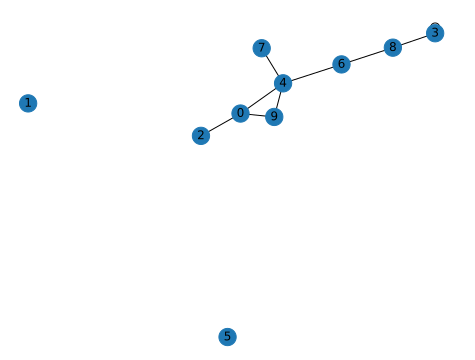

In [206]:
pos = nx.spring_layout(q, seed=3113794652)
nx.draw(q,pos, with_labels=True )


In [207]:
data = qsubgraph_prop[tuple(max_subgraph_nodes)]


In [208]:
len(max_subgraph_nodes)

8

In [209]:
data

array([[0., 1., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 1., 0., 1.],
       [0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0.]])

In [210]:
q1=nx.from_numpy_array(data)

In [211]:
node_lbl = dict(zip(list(q1.nodes), list(max_subgraph_nodes)))

In [212]:
nx.set_node_attributes(q1, values=node_lbl, name='labels')

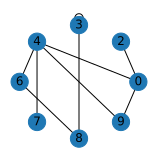

In [215]:
plt.figure(figsize=(2,2))
pos = nx.circular_layout(q1)
nx.draw(q1, with_labels=True, labels=node_lbl, pos=pos)

In [216]:
np.array(data)

array([[0., 1., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 1., 0., 1.],
       [0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0.]])

In [217]:
n_clusters = int(np.ceil(len(max_subgraph_nodes)/max_cluster_size))

In [218]:
n_clusters

3

In [219]:
data = np.array(data)

In [54]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#### k-means++

In [326]:
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=0)


In [327]:
kmeans.fit(data)

KMeans(n_clusters=3, n_init=4, random_state=0)

In [328]:
kmeans.cluster_centers_

array([[0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [3.33333333e-01, 3.33333333e-01, 6.66666667e-01, 0.00000000e+00,
        3.33333333e-01, 5.55111512e-17, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 5.55111512e-17, 0.00000000e+00,
        3.33333333e-01, 6.66666667e-01, 3.33333333e-01]])

In [329]:
kmeans_lbl = list(kmeans.labels_)

In [330]:
node_clr = dict(zip(list(q1.nodes), kmeans_lbl))

In [331]:
node_clr

{0: 1, 1: 0, 2: 1, 3: 2, 4: 2, 5: 2, 6: 1}

In [332]:
kmeans_lbl

[1, 0, 1, 2, 2, 2, 1]

In [333]:
node_lbl

{0: 0, 1: 1, 2: 2, 3: 6, 4: 7, 5: 8, 6: 9}

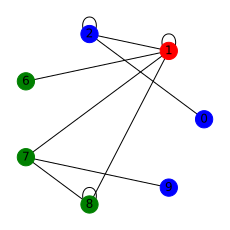

In [334]:
colors = ['red', 'blue', 'green', 'yellow']
color_map = []
for node in q1:
    color_map.append(colors[node_clr[node]])
plt.figure(figsize=(3,3))
pos = nx.circular_layout(q1)
nx.draw(q1, node_color=color_map, with_labels=True, labels=node_lbl,pos=pos )
plt.show()

In [335]:
pca = PCA(n_components=n_clusters).fit(data)
kmeans_pca = KMeans(init=pca.components_, n_clusters=n_clusters, n_init=1)
kmeans_pca.fit(data)

KMeans(init=array([[ 0.25594148, -0.32839657,  0.29212838, -0.24204074, -0.44931881,
        -0.67170095, -0.17221321],
       [ 0.11765666, -0.07383292,  0.67834629,  0.46229673,  0.39863689,
         0.04075567, -0.38244119],
       [-0.34923018, -0.60293439, -0.35665586, -0.10508772,  0.51181323,
        -0.23577703, -0.24231792]]),
       n_clusters=3, n_init=1)

In [336]:
kmeans_pca.labels_

array([1, 1, 1, 1, 0, 1, 2], dtype=int32)

In [337]:
node_clr_pca = dict(zip(list(q1.nodes), kmeans_pca.labels_))

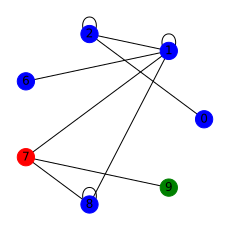

In [338]:
colors = ['red', 'blue', 'green', 'yellow']
color_map = []
for node in q1:
    color_map.append(colors[node_clr_pca[node]])
plt.figure(figsize=(3,3))
pos = nx.circular_layout(q1)
nx.draw(q1, node_color=color_map, with_labels=True, labels=node_lbl,pos=pos )
plt.show()

In [339]:
kmeans_rand = KMeans(init="random", n_clusters=n_clusters, n_init=4, random_state=0)
kmeans_rand.fit(data)

KMeans(init='random', n_clusters=3, n_init=4, random_state=0)

In [340]:
kmeans_rand.labels_

array([0, 2, 1, 1, 1, 2, 0], dtype=int32)

In [341]:
node_clr_kmeansrand = dict(zip(list(q1.nodes), kmeans_rand.labels_))

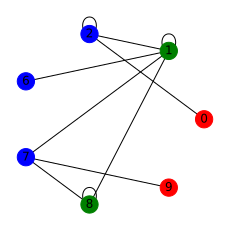

In [342]:
colors = ['red', 'blue', 'green', 'yellow']
color_map = []
for node in q1:
    color_map.append(colors[node_clr_kmeansrand[node]])
plt.figure(figsize=(3,3))
pos = nx.circular_layout(q1)
nx.draw(q1, node_color=color_map, with_labels=True, labels=node_lbl,pos=pos )
plt.show()

#### HDBSCAN

In [343]:
from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1, min_samples=5).fit(data)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 7


In [344]:
labels

array([-1, -1, -1, -1, -1, -1, -1])

#### Birch

In [345]:
from sklearn.cluster import Birch


In [346]:
brc = Birch(n_clusters=None)
brc.fit(data)
Birch(n_clusters=None)
brc.predict(data)


array([0, 1, 2, 3, 4, 5, 6])

In [347]:
brc = Birch(n_clusters=4)
brc.fit(data)
Birch(n_clusters=4)
brc.predict(data)

array([0, 1, 0, 0, 2, 1, 3])

In [348]:
birch_labels = brc.predict(data)

In [349]:
node_clr_birch = dict(zip(list(q1.nodes), birch_labels))

In [14]:
def draw_subgraph(subgraph, subgraph_labels, cluster_labels):
    colors = ['red', 'blue', 'green', 'yellow']
    color_map = []
    for node in subgraph:
        color_map.append(colors[cluster_labels[node]])
    plt.figure(figsize=(3,3))
    pos = nx.circular_layout(q1)
    nx.draw(q1, node_color=color_map, with_labels=True, labels=subgraph_labels,pos=pos )
    plt.show()

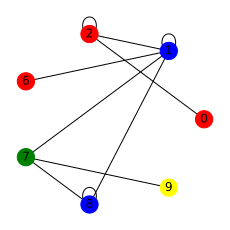

In [351]:
draw_subgraph(q1, node_lbl, node_clr_birch )

#### agglomerative clustering

In [352]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=4).fit(data)
clustering.labels_

array([0, 1, 0, 0, 2, 1, 3])

In [353]:
node_clr_agg = dict(zip(list(q1.nodes), clustering.labels_))

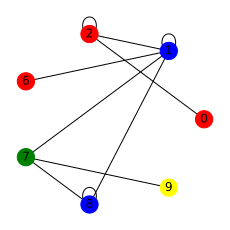

In [354]:
draw_subgraph(q1, node_lbl, node_clr_agg )

In [355]:
G = nx.planted_partition_graph(4, 3, 0.5, 0.1, seed=42)

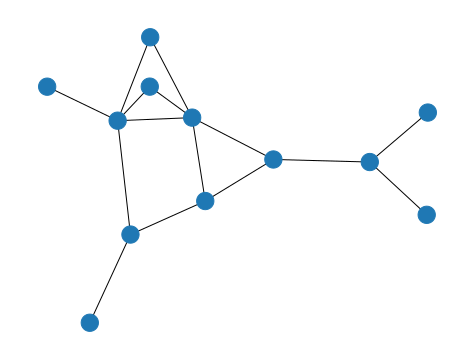

In [356]:
nx.draw(G)

In [357]:
c = nx.community.asyn_lpa_communities(q1)

In [358]:
node_lbl

{0: 0, 1: 1, 2: 2, 3: 6, 4: 7, 5: 8, 6: 9}

#### networkx min cut

In [255]:
from networkx.algorithms.flow import shortest_augmenting_path


In [261]:
q1.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))

In [364]:
q1_adj = nx.adjacency_matrix(q1).todense()

#### Minimum cut partition
- min cut partition into 2 blocks
- check the size of each block
- apply min cut if required (recursively)


#### CutQC

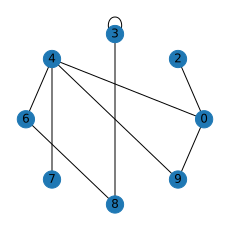

In [220]:
plt.figure(figsize=(3,3))
nx.draw(q1,with_labels=True, labels=node_lbl, pos=pos)

In [221]:
n_clusters

3

In [222]:
len(max_subgraph_nodes)

8

In [223]:
data

array([[0., 1., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 1., 0., 1.],
       [0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0.]])

In [94]:
n_qubits = 3
size = len(max_subgraph_nodes)
qp = create_qp_from_qmatrix(data)
print(qp)
qaoa = create_qaoa_ansatz(qp)
print(qaoa)

minimize 2*x1*x4 + 2*x2*x3 + 2*x2*x4 (4 variables, 0 constraints, 'QUBO Matrix Optimization')
global phase: π
     ┌────────────┐                              ┌────────┐┌──────────┐     »
q_0: ┤ U(π/2,0,π) ├───────■──────────────────■───┤ U1(-π) ├┤ R(0.0,0) ├─────»
     ├────────────┤       │                  │  ┌┴────────┤└──────────┘     »
q_1: ┤ U(π/2,0,π) ├──■────┼─────────────■────┼──┤ U1(-2π) ├──────────────■──»
     ├────────────┤┌─┴─┐  │  ┌───────┐┌─┴─┐  │  └┬────────┤┌──────────┐  │  »
q_2: ┤ U(π/2,0,π) ├┤ X ├──┼──┤ Rz(π) ├┤ X ├──┼───┤ U1(-π) ├┤ R(0.0,0) ├──┼──»
     ├────────────┤└───┘┌─┴─┐├───────┤└───┘┌─┴─┐┌┴────────┤└──────────┘┌─┴─┐»
q_3: ┤ U(π/2,0,π) ├─────┤ X ├┤ Rz(π) ├─────┤ X ├┤ U1(-2π) ├────────────┤ X ├»
     └────────────┘     └───┘└───────┘     └───┘└─────────┘            └───┘»
«                               
«q_0: ──────────────────────────
«                   ┌──────────┐
«q_1: ───────────■──┤ R(0.0,0) ├
«                │  └──────────┘
«q_2: ───────────┼─────

In [81]:
num_subcircuits = math.ceil(size/n_qubits)
num_subcircuits

2

In [83]:
cuts = cut_circuit_wires(
                        circuit=qaoa,
                        method="automatic",
                        max_subcircuit_width=n_qubits,
                        max_cuts= num_subcircuits+1,
                        num_subcircuits=[num_subcircuits]
                    )

Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 5 times.
MIP Presolve eliminated 108 rows and 24 columns.
MIP Presolve modified 15 coefficients.
Aggregator did 61 substitutions.
Reduced MIP has 41 rows, 17 columns, and 115 nonzeros.
Reduced MIP has 16 binaries, 1 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (0.86 ticks)
Found incumbent of value 1.000000 after 0.01 sec. (0.89 ticks)

Root node processing (before b&c):
  Real time             =    0.01 sec. (0.89 ticks)
Parallel b&c, 16 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.01 sec. (0.89 ticks)
--------------------
subcircuit 0
ρ qubits 

In [87]:
cuts.keys()

dict_keys(['max_subcircuit_width', 'subcircuits', 'complete_path_map', 'num_cuts', 'counter', 'classical_cost'])

In [138]:
cuts['classical_cost']

64

In [146]:
print(cuts['complete_path_map'])

{Qubit(QuantumRegister(4, 'q'), 0): [{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 0)}], Qubit(QuantumRegister(4, 'q'), 1): [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 0)}], Qubit(QuantumRegister(4, 'q'), 2): [{'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 1)}], Qubit(QuantumRegister(4, 'q'), 3): [{'subcircuit_idx': 1, 'subcircuit_qubit': Qubit(QuantumRegister(2, 'q'), 1)}, {'subcircuit_idx': 0, 'subcircuit_qubit': Qubit(QuantumRegister(3, 'q'), 2)}]}


Qubit(QuantumRegister(4, 'q'), 0)
1
Qubit(QuantumRegister(4, 'q'), 1)
0
Qubit(QuantumRegister(4, 'q'), 2)
0
Qubit(QuantumRegister(4, 'q'), 3)
1
0


In [143]:
cuts['counter']

{0: {'effective': 3, 'rho': 1, 'O': 0, 'd': 3, 'depth': 9, 'size': 14},
 1: {'effective': 1, 'rho': 0, 'O': 1, 'd': 2, 'depth': 6, 'size': 7}}

In [144]:
cuts['num_cuts']

1

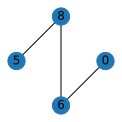

In [128]:
plt.figure(figsize=(1.5,1.5))
nx.draw(q1,with_labels=True, labels=node_lbl, pos=pos)

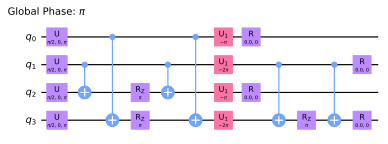

In [98]:
qaoa.draw(scale=0.6)

In [129]:
data

array([[0., 0., 0., 1.],
       [0., 0., 1., 1.],
       [0., 1., 0., 0.],
       [1., 1., 0., 0.]])

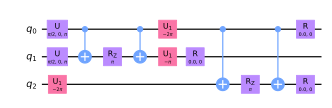

In [96]:
cuts['subcircuits'][0].draw(scale=0.6)

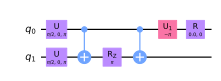

In [97]:
cuts['subcircuits'][1].draw(scale=0.6)

In [132]:
a_sub1 = np.array([[ 0., 1., 1.],
           [ 1., 0., 0.],
           [ 1., 0., 0.]])

minimize 2*x1*x2 + 2*x1*x3 (3 variables, 0 constraints, 'QUBO Matrix Optimization')


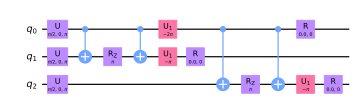

In [133]:
qp_sub1 = create_qp_from_qmatrix(a_sub1)
print(qp_sub1)
qaoa_sub1 = create_qaoa_ansatz(qp_sub1)
qaoa_sub1.draw(scale=0.6)

In [134]:
a_sub2 = np.array([[0.,1],
                  [1,0.]])

minimize 2*x1*x2 (2 variables, 0 constraints, 'QUBO Matrix Optimization')


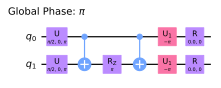

In [135]:
qp_sub2 = create_qp_from_qmatrix(a_sub2)
print(qp_sub2)
qp_sub2 = create_qaoa_ansatz(qp_sub2)
qp_sub2.draw(scale=0.6)

In [136]:
result = mc.run_mcl(data, inflation=2.4)

In [137]:
mc.get_clusters(result)

[(0, 3), (1, 2)]

#### graph partitioning

In [247]:
data

array([[0., 1., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 1., 0., 1.],
       [0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0.]])

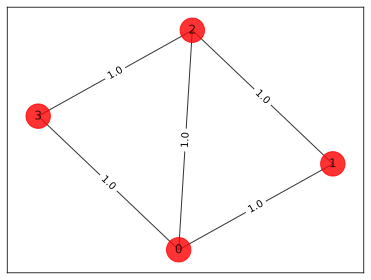

In [244]:
# Generating a graph of 4 nodes

n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [245]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)



[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


In [264]:
max_cut = Maxcut(data)
gp = GraphPartition(data)

In [303]:
n_qubits = max_cluster_size
size = len(max_subgraph_nodes)
max_cut = Maxcut(w)
qp_mc = max_cut.to_quadratic_program()
print(qp_mc.prettyprint())



Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_0*x_7 - 2*x_2^2 - 2*x_2*x_6 - 2*x_3*x_4
  - 2*x_3*x_5 - 2*x_3*x_7 - 2*x_4*x_6 + 3*x_0 + x_1 + 3*x_2 + 4*x_3 + 2*x_4
  + x_5 + 2*x_6 + 2*x_7

Subject to
  No constraints

  Binary variables (8)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7



In [304]:
qubitOp_mc, offset_mc = qp_mc.to_ising()
print("Offset:", offset_mc)
print("Ising Hamiltonian:")
print(str(qubitOp_mc))

Offset: -4.0
Ising Hamiltonian:
0.5 * IIIIIIZZ
+ 0.5 * IIIIZIIZ
+ 0.5 * IIIZZIII
+ 0.5 * IIZIZIII
+ 0.5 * IZIIIZII
+ 0.5 * IZIZIIII
+ 0.5 * ZIIIIIIZ
+ 0.5 * ZIIIZIII


In [305]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp_mc)
print(result.prettyprint())


objective function value: 7.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=1.0, x_6=0.0, x_7=1.0
status: SUCCESS


In [268]:
n=data.shape[0]

In [290]:
#colors = ["r" for node in q1.nodes()]
#pos = nx.spring_layout(q1)
pos = nx.circular_layout(q1)
node_lbl = dict(zip(list(q1.nodes), list(max_subgraph_nodes)))

In [291]:
def draw_graph(G, colors, pos, node_lbl):
    default_axes = plt.axes(frameon=True)
    #nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw(G, with_labels=True, pos=pos, labels=node_lbl, node_color=colors, node_size=600, alpha=0.8, ax=default_axes)
#plt.figure(figsize=(3,3))
#nx.draw(q1,with_labels=True, labels=node_lbl, pos=pos)

In [271]:
w=data
G=q1

In [306]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp_mc)

x_mc = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset_mc)
print("solution:", x_mc)
print("solution objective:", qp_mc.objective.evaluate(x))


energy: -3.0
max-cut objective: -7.0
solution: [1. 0. 1. 0. 1. 1. 0. 1.]
solution objective: 2.0


In [307]:
x_mc

array([1., 0., 1., 0., 1., 1., 0., 1.])

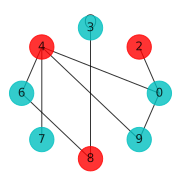

In [309]:
plt.figure(figsize=(3,3))
colors = ["r" if x_mc[i] == 0 else "c" for i in range(n)]
draw_graph(q1, colors, pos, node_lbl)

In [298]:
### GP

In [301]:
n_qubits = max_cluster_size
size = len(max_subgraph_nodes)
qp = gp.to_quadratic_program()
print(qp.prettyprint())

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Problem name: Graph partition

Minimize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_0*x_7 - 2*x_2^2 - 2*x_2*x_6 - 2*x_3*x_4
  - 2*x_3*x_5 - 2*x_3*x_7 - 2*x_4*x_6 + 3*x_0 + x_1 + 3*x_2 + 4*x_3 + 2*x_4
  + x_5 + 2*x_6 + 2*x_7

Subject to
  Linear constraints (1)
    x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 == 4  'c0'

  Binary variables (8)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7

Offset: 78.0
Ising Hamiltonian:
18.0 * IIIIIIZZ
+ 18.5 * IIIIIZIZ
+ 18.5 * IIIIIZZI
+ 18.0 * IIIIZIIZ
+ 18.5 * IIIIZIZI
+ 18.5 * IIIIZZII
+ 18.5 * IIIZIIIZ
+ 18.5 * IIIZIIZI
+ 18.5 * IIIZIZII
+ 18.0 * IIIZZIII
+ 18.5 * IIZIIIIZ
+ 18.5 * IIZIIIZI
+ 18.5 * IIZIIZII
+ 18.0 * IIZIZIII
+ 18.5 * IIZZIIII
+ 18.5 * IZIIIIIZ
+ 18.5 * IZIIIIZI
+ 18.0 * IZIIIZII
+ 18.5 * IZIIZIII
+ 18.0 * IZIZIIII
+ 18.5 * IZZIIIII
+ 18.0 * ZIIIIIIZ
+ 18.5 * ZIIIIIZI
+ 18.5 * ZIIIIZII
+ 18.0 * ZIIIZIII
+ 18.5 * ZIIZIIII
+ 18.5 * ZIZIIIII
+ 18.5 * ZZIIIIII


energy: -76.0
max-cut objective: 2.0
solution: [1. 1. 0. 1. 0. 0. 0. 1.]
solution objective: 2.0


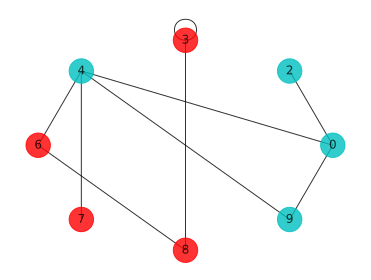

In [302]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = gp.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(data.shape[0])]
draw_graph(q1, colors, pos, node_lbl)

[1., 0., 1., 0., 1., 1., 0., 1.])

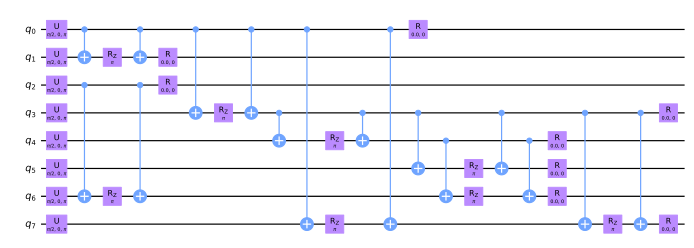

In [295]:
qaoa_ansatz = QAOAAnsatz(cost_operator=qubitOp, reps=1, )
qaoa_ansatz.entanglement = 'linear'
params = len(qaoa_ansatz.parameters)
theta_range = np.linspace(0, np.pi, params)
qaoa_qc = qaoa_ansatz.bind_parameters(theta_range)
decomposed_qaoa_ansatz = qaoa_qc.decompose().decompose().decompose().decompose()
qaoa.draw(scale=0.6)

case = [0, 0, 0, 0, 0, 0, 0, 0] cost = 0.0
case = [1, 0, 0, 0, 0, 0, 0, 0] cost = 3.0
case = [0, 1, 0, 0, 0, 0, 0, 0] cost = 1.0
case = [1, 1, 0, 0, 0, 0, 0, 0] cost = 2.0
case = [0, 0, 1, 0, 0, 0, 0, 0] cost = 1.0
case = [1, 0, 1, 0, 0, 0, 0, 0] cost = 4.0
case = [0, 1, 1, 0, 0, 0, 0, 0] cost = 2.0
case = [1, 1, 1, 0, 0, 0, 0, 0] cost = 3.0
case = [0, 0, 0, 1, 0, 0, 0, 0] cost = 4.0
case = [1, 0, 0, 1, 0, 0, 0, 0] cost = 5.0
case = [0, 1, 0, 1, 0, 0, 0, 0] cost = 5.0
case = [1, 1, 0, 1, 0, 0, 0, 0] cost = 4.0
case = [0, 0, 1, 1, 0, 0, 0, 0] cost = 5.0
case = [1, 0, 1, 1, 0, 0, 0, 0] cost = 6.0
case = [0, 1, 1, 1, 0, 0, 0, 0] cost = 6.0
case = [1, 1, 1, 1, 0, 0, 0, 0] cost = 5.0
case = [0, 0, 0, 0, 1, 0, 0, 0] cost = 2.0
case = [1, 0, 0, 0, 1, 0, 0, 0] cost = 5.0
case = [0, 1, 0, 0, 1, 0, 0, 0] cost = 3.0
case = [1, 1, 0, 0, 1, 0, 0, 0] cost = 4.0
case = [0, 0, 1, 0, 1, 0, 0, 0] cost = 3.0
case = [1, 0, 1, 0, 1, 0, 0, 0] cost = 6.0
case = [0, 1, 1, 0, 1, 0, 0, 0] cost = 4.0
case = [1, 

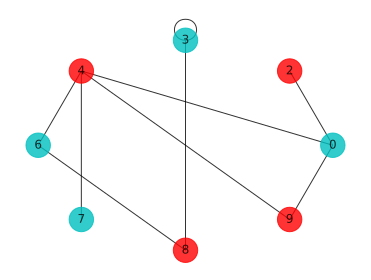

In [294]:
w=data
G=q1
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    print("case = " + str(x) + " cost = " + str(cost))

colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(q1, colors, pos, node_lbl)
print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))



In [ ]:
gp : solution: [1. 0. 1. 0. 1. 1. 0. 1.]
bf : solution: [1, 0, 1, 0, 1, 1, 0, 0]
maxc: solution:[1. 0. 1. 0. 1. 1. 0. 1.]